In [1]:
# Dependencies
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
import flwr as fl
from collections import OrderedDict
from typing import List, Tuple, Dict
from sklearn.metrics import confusion_matrix
from typing import Optional
import os
from pytorch_tcn import TCN
import logging

# Set logging level to critical to reduce output noise
logging.getLogger("flwr").setLevel(logging.CRITICAL)

# Define device for computation (GPU if available, else CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLIENTS = 5  # Number of federated clients

In [2]:
# Load and preprocess data
def load_and_preprocess(train_file, val_file):
    """
    Load and preprocess the data from CSV files.

    Parameters:
        train_file (str): Path to the training CSV file.
        val_file (str): Path to the validation CSV file.

    Returns:
        Tuple containing training samples, training labels, validation samples, and validation labels.
    """
    # Load datasets
    train_df = pd.read_csv(train_file, header=None)
    val_df = pd.read_csv(val_file, header=None)
    
    # Extract samples and labels, converting to float
    train_samples = train_df.iloc[1:-1, 1:].values.astype(float)
    train_labels = train_df.iloc[-1, 1:].values.astype(float)
    val_samples = val_df.iloc[1:-1, 1:].values.astype(float)
    val_labels = val_df.iloc[-1, 1:].values.astype(float)
    
    # Standardize the samples
    scaler = StandardScaler()
    train_samples = scaler.fit_transform(train_samples.T).T
    val_samples = scaler.transform(val_samples.T).T
    
    return train_samples, train_labels, val_samples, val_labels

In [3]:
# Define TCN model
class TCNModel(nn.Module):
    def __init__(self):
        super(TCNModel, self).__init__()
        # Temporal Convolutional Network layers
        self.tcn = TCN(
            num_inputs=1,  # Number of input channels
            num_channels=[16, 16, 16, 16],  # Number of filters per layer
            kernel_size=4,  # Kernel size for convolutions
            dropout=0.3,  # Dropout rate
            causal=False  # Non-causal convolutions
        )
        self.linear = nn.Linear(16 * 300, 1)  # Linear layer for output

    def forward(self, x):
        # Forward pass through TCN and linear layer
        x = self.tcn(x).view(x.size(0), -1)
        x = self.linear(x)
        return x

In [4]:
# Early stopping criteria
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Initialize the early stopping mechanism.

        Parameters:
            patience (int): Number of epochs to wait for improvement before stopping.
            min_delta (float): Minimum change to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        """
        Check if training should stop based on validation loss.

        Parameters:
            val_loss (float): Current validation loss.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [5]:
# Federated learning utility functions

def get_client_parameters(net) -> List[np.ndarray]:
    """
    Extract model parameters for federated learning.

    Parameters:
        net (nn.Module): The neural network model.

    Returns:
        List[np.ndarray]: Model parameters.
    """
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_client_parameters(net, parameters: List[np.ndarray]):
    """
    Set model parameters for federated learning.

    Parameters:
        net (nn.Module): The neural network model.
        parameters (List[np.ndarray]): List of model parameters.
    """
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [6]:
# Test the client model
def test_client_model(net, testloader):
    """
    Evaluate the model on the test set.

    Parameters:
        net (nn.Module): The neural network model.
        testloader (DataLoader): DataLoader for the test set.

    Returns:
        Tuple containing loss, accuracy, precision, recall, and F1 score.
    """
    criterion = nn.BCEWithLogitsLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = net(inputs).squeeze()
            loss += criterion(outputs, labels).item()
            preds = torch.sigmoid(outputs) > 0.5  # Apply sigmoid to get probabilities
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Calculate metrics
    loss /= len(testloader.dataset)
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return loss, accuracy, precision, recall, f1

In [7]:
# Train the client model
def train_client_model(net, trainloader, valloader, epochs: int, patience: int = 5, client_id: int = 0):
    """
    Train the model on the client's local dataset.

    Parameters:
        net (nn.Module): The neural network model.
        trainloader (DataLoader): DataLoader for the training set.
        valloader (DataLoader): DataLoader for the validation set.
        epochs (int): Number of training epochs.
        patience (int): Patience for early stopping.
        client_id (int): Identifier for the client.
    """
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        net.train()  # Set model to training mode
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        val_loss, val_accuracy, _, _, _ = test_client_model(net, valloader)
        print(f"Epoch {epoch+1}: val loss {val_loss:.4f}, val accuracy {val_accuracy:.4f}")

        # Save the best model
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(net.state_dict(), f"best_model_client_{client_id}.pt")
        else:
            patience_counter += 1

        # Stop training if 100% accuracy is achieved
        if val_accuracy == 1.0:
            print(f"Early stopping due to reaching 100% accuracy")
            break

In [8]:
# Define the FlowerClient class for federated learning
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        """
        Initialize a federated learning client.

        Parameters:
            cid (int): Client ID.
            net (nn.Module): The neural network model.
            trainloader (DataLoader): DataLoader for the training set.
            valloader (DataLoader): DataLoader for the validation set.
        """
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        """Return the model parameters."""
        print(f"[Client {self.cid}] get_parameters")
        return get_client_parameters(self.net)

    def fit(self, parameters, config):
        """Train the model on local data."""
        print(f"[Client {self.cid}] fit, config: {config}")
        # Set the model parameters from the global model
        set_client_parameters(self.net, parameters)
        # Train the model using local data
        train_client_model(self.net, self.trainloader, self.valloader, epochs=20, patience=5, client_id=self.cid)
        # Return the updated model parameters and the number of training samples
        return get_client_parameters(self.net), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        """Evaluate the model on local validation data."""
        print(f"[Client {self.cid}] evaluate, config: {config}")
        # Set the model parameters with the latest global parameters
        set_client_parameters(self.net, parameters)
        # Evaluate the model
        loss, accuracy, precision, recall, f1 = test_client_model(self.net, self.valloader)
        # Return the evaluation metrics
        return float(loss), len(self.valloader.dataset), {
            "accuracy": float(accuracy),
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1)
        }

In [9]:
# Create a Flower client
def client_fn(cid) -> FlowerClient:
    """
    Create and initialize a FlowerClient instance for a given client ID.

    Parameters:
        cid (int): Client ID.

    Returns:
        FlowerClient: Configured FlowerClient instance.
    """
    # Initialize the TCN model
    net = TCNModel().to(DEVICE)
    # Define file paths for training and validation data
    train_file = f"../No_MSC/Seed_{seed_index}/Client_{cid}_Train.csv"
    val_file = f"../No_MSC/Seed_{seed_index}/Client_{cid}_Validation.csv"
    
    # Load and preprocess the data
    train_samples, train_labels, val_samples, val_labels = load_and_preprocess(train_file, val_file)
    
    # Convert data to PyTorch tensors and add channel dimension for TCN
    X_train = torch.tensor(train_samples.T, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(train_labels, dtype=torch.float32)
    X_val = torch.tensor(val_samples.T, dtype=torch.float32).unsqueeze(1)
    y_val = torch.tensor(val_labels, dtype=torch.float32)

    # Create TensorDatasets and DataLoaders for training and validation
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return FlowerClient(cid, net, train_loader, val_loader)

In [10]:
# Load combined validation dataset for evaluation
def load_combined_validation(seed_index):
    """
    Load and preprocess the combined validation dataset for all clients.

    Parameters:
        seed_index (int): Index of the seed for data partitioning.

    Returns:
        DataLoader: DataLoader for the combined validation dataset.
    """
    # Define file path for the combined validation set
    val_file = f"../No_MSC/Seed_{seed_index}/Combined_Validation.csv"
    # Load and preprocess the combined validation data
    _, _, val_samples, val_labels = load_and_preprocess(val_file, val_file)
    # Convert samples and labels to PyTorch tensors
    X_val = torch.tensor(val_samples.T, dtype=torch.float32).unsqueeze(1)
    y_val = torch.tensor(val_labels, dtype=torch.float32)
    # Create TensorDataset and DataLoader
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    return val_loader

In [11]:
# Evaluate the aggregated model on the combined validation dataset
def evaluate_aggregated_model(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    """
    Evaluate the aggregated model on the combined validation dataset.

    Parameters:
        server_round (int): Current round of federated learning.
        parameters (fl.common.NDArrays): Aggregated model parameters from the server.
        config (Dict[str, fl.common.Scalar]): Configuration dictionary.

    Returns:
        Optional[Tuple[float, Dict[str, fl.common.Scalar]]]: 
        Evaluation loss and a dictionary of aggregated evaluation metrics.
    """
    global best_aggregated_acc
    # Initialize the TCN model
    net = TCNModel().to(DEVICE)
    # Load the latest parameters into the model
    set_client_parameters(net, parameters)
    # Evaluate the model on the combined validation set
    loss, accuracy, precision, recall, f1 = test_client_model(net, combined_val_loader)
    print(f"Server-side evaluation - loss: {loss}, accuracy: {accuracy}")

    # Save the best model based on validation accuracy
    if accuracy > best_aggregated_acc:
        best_aggregated_acc = accuracy
        torch.save(net.state_dict(), "best_aggregated_model.pt")
        print(f"Best aggregated model saved with accuracy {accuracy}")

    return loss, {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [12]:
# Define metric aggregation function using arithmetic mean
def arithmetic_mean(metrics: List[Tuple[int, Dict[str, fl.common.Scalar]]]) -> Dict[str, fl.common.Scalar]:
    """
    Compute the arithmetic mean of metrics across all clients.

    Parameters:
        metrics (List[Tuple[int, Dict[str, fl.common.Scalar]]]): 
        List of tuples containing number of samples and metric dictionaries from clients.

    Returns:
        Dict[str, fl.common.Scalar]: Aggregated metrics.
    """
    # Extract accuracy and calculate mean
    accuracies = [m["accuracy"] for _, m in metrics]
    mean_acc = np.mean(accuracies)
    # Extract precision and calculate mean
    precisions = [m["precision"] for _, m in metrics]
    mean_precision = np.mean(precisions)
    # Extract recall and calculate mean
    recalls = [m["recall"] for _, m in metrics]
    mean_recall = np.mean(recalls)
    # Extract F1 score and calculate mean
    f1_scores = [m["f1"] for _, m in metrics]
    mean_f1 = np.mean(f1_scores)
    return {"accuracy": mean_acc, "precision": mean_precision, "recall": mean_recall, "f1": mean_f1}

In [13]:
# Training and evaluation loop for federated learning
# Initialize the combined validation dataset loader for each seed
combined_val_loaders = []

# Store metrics for analysis
all_metrics = []

# Train and evaluate the federated model across 30 seeds
for seed_index in range(30):
    print(f"Seed {seed_index+1}/30")

    # Load the combined validation dataset for the current seed
    combined_val_loader = load_combined_validation(seed_index)
    combined_val_loaders.append(combined_val_loader)

    # Reset best aggregated accuracy for each seed
    best_aggregated_acc = 0.0

    # Define the federated learning strategy
    strategy = fl.server.strategy.FedAvg(
        fraction_fit=1.0,  # Use all clients for training in each round
        fraction_evaluate=1.0,  # Use all clients for evaluation in each round
        min_fit_clients=5,  # Minimum number of clients required for training
        min_evaluate_clients=5,  # Minimum number of clients required for evaluation
        min_available_clients=NUM_CLIENTS,  # Minimum number of total clients
        initial_parameters=fl.common.ndarrays_to_parameters(get_client_parameters(TCNModel())),
        evaluate_fn=evaluate_aggregated_model,  # Evaluation function for server-side evaluation
        evaluate_metrics_aggregation_fn=arithmetic_mean,  # Metric aggregation function
    )

    client_resources = None
    if DEVICE.type == "cuda":
        client_resources = {"num_gpus": 1}

    # Start the federated learning simulation
    fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=50),  # Number of training rounds
        strategy=strategy,
        client_resources=client_resources,
    )

    # Load and evaluate the best aggregated model for the current seed
    aggregated_model_path = "best_aggregated_model.pt"
    aggregated_model = TCNModel().to(DEVICE)
    if os.path.exists(aggregated_model_path):
        aggregated_model.load_state_dict(torch.load(aggregated_model_path))
        loss, accuracy, precision, recall, f1 = test_client_model(aggregated_model, combined_val_loader)
        print(f"Aggregated model evaluation - loss: {loss}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1}")
        all_metrics.append((loss, accuracy, precision, recall, f1))

Seed 1/30


2024-08-03 16:25:46,406	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.024908655771502742, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=11178) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11178) [Client 3] fit, config: {}
(ClientAppActor pid=11178) Epoch 1: val loss 0.0217, val accuracy 0.8095
(ClientAppActor pid=11174) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11178) Early stopping at epoch 8
Server-side evaluation - loss: 0.016135607880574686, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
(ClientAppActor pid=11178) [Client 3] evaluate, config: {}
(ClientAppActor pid=11174) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.013807116835205644, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
(ClientAppActor pid=11178) [Client 3] fit, config: {} [repeated 10x across cluster]


(ClientAppActor pid=11178) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 18x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


(ClientAppActor pid=11178) Epoch 7: val loss 0.0161, val accuracy 0.8571 [repeated 130x across cluster]
(ClientAppActor pid=11176) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11174) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.012574032500938134, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
(ClientAppActor pid=11178) Early stopping at epoch 15 [repeated 7x across cluster]
(ClientAppActor pid=11177) [Client 3] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.012325952174486938, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297
Server-side evaluation - loss: 0.011689874033133188, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888
(ClientAppActor pid=11177) [Client 1] fit, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.010819064522231067, accuracy: 0.85

(ClientAppActor pid=11178) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 37x across cluster]


(ClientAppActor pid=11174) Epoch 4: val loss 0.0114, val accuracy 0.9048 [repeated 102x across cluster]
(ClientAppActor pid=11178) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
Server-side evaluation - loss: 0.011428079947277351, accuracy: 0.8796296296296297
(ClientAppActor pid=11175) Early stopping at epoch 9 [repeated 10x across cluster]
(ClientAppActor pid=11177) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.010757859658311915, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.011001155470256452, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.009840062371006719, accuracy: 0.8796296296296297
(ClientAppActor pid=11178) [Client 0] fit, config: {} [repeated 21x across cluster]
(ClientAppActor pid=11178) Epoch 6: val loss 0.0427, val accuracy 0.9583 [repeated 94x across cluster]
(ClientAppActor pid=11176) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server

(ClientAppActor pid=11178) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


(ClientAppActor pid=11174) Early stopping at epoch 10 [repeated 9x across cluster]
Server-side evaluation - loss: 0.009300010761728993, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
(ClientAppActor pid=11176) 
(ClientAppActor pid=11176) [Client 1] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.008953262396432736, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.008860186984141668, accuracy: 0.8981481481481481
(ClientAppActor pid=11177) [Client 0] fit, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.008743235772406613, accuracy: 0.8981481481481481
(ClientAppActor pid=11177) Epoch 7: val loss 0.0628, val accuracy 0.9583 [repeated 80x across cluster]
(ClientAppActor pid=11176) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=11175) Early stopping at epoch 7 [repeated 9x across cluster]
Server-side evaluation - loss: 0.0082430

(ClientAppActor pid=11178) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=11177) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.008260277410348257, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.008929024415987509, accuracy: 0.8888888888888888
(ClientAppActor pid=11177) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.008278512154464368, accuracy: 0.8703703703703703
(ClientAppActor pid=11178) Epoch 5: val loss 0.0430, val accuracy 0.9583 [repeated 92x across cluster]
(ClientAppActor pid=11174) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
Server-side evaluation - loss: 0.008967696516602128, accuracy: 0.8981481481481481
(ClientAppActor pid=11178) Early stopping at epoch 8 [repeated 9x across cluster]
Server-side evaluation - loss: 0.009562271957596144, accuracy: 0.8888888888888888


(ClientAppActor pid=11178) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


(ClientAppActor pid=11177) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.008140645990217174, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.009171805241041713, accuracy: 0.8888888888888888
(ClientAppActor pid=11177) [Client 1] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.009691968146297667, accuracy: 0.8796296296296297
(ClientAppActor pid=11177) Epoch 2: val loss 0.0030, val accuracy 1.0000 [repeated 85x across cluster]
(ClientAppActor pid=11177) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
Server-side evaluation - loss: 0.007397491691841019, accuracy: 0.8796296296296297
(ClientAppActor pid=11176) Early stopping at epoch 9 [repeated 10x across cluster]
Server-side evaluation - loss: 0.008220588995350732, accuracy: 0.8888888888888888
(ClientAppActor pid=11178) [Client 3] evaluate, config: {} [repeated 21x across cluster]


(ClientAppActor pid=11178) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


Server-side evaluation - loss: 0.00842659899757968, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.007759982375083146, accuracy: 0.8888888888888888
(ClientAppActor pid=11177) [Client 3] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.008282040004377012, accuracy: 0.8888888888888888
(ClientAppActor pid=11175) Epoch 6: val loss 0.0581, val accuracy 0.9583 [repeated 78x across cluster]
(ClientAppActor pid=11176) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
Server-side evaluation - loss: 0.008066736127215403, accuracy: 0.8981481481481481
(ClientAppActor pid=11178) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.006841084471455327, accuracy: 0.8981481481481481
(ClientAppActor pid=11177) [Client 1] evaluate, config: {} [repeated 29x across cluster]


(ClientAppActor pid=11178) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 55x across cluster]


Server-side evaluation - loss: 0.007610470539441815, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.006756475643703231, accuracy: 0.8981481481481481
(ClientAppActor pid=11177) [Client 3] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.008555518980655406, accuracy: 0.9074074074074074
(ClientAppActor pid=11174) Epoch 2: val loss 0.0018, val accuracy 1.0000 [repeated 83x across cluster]
(ClientAppActor pid=11175) Early stopping due to reaching 100% accuracy [repeated 17x across cluster]
Server-side evaluation - loss: 0.008339065920423579, accuracy: 0.8888888888888888
(ClientAppActor pid=11178) Early stopping at epoch 7 [repeated 9x across cluster]
Server-side evaluation - loss: 0.0070104023648632895, accuracy: 0.8888888888888888
(ClientAppActor pid=11177) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.007933370838010753, accuracy: 0.8888888888888888


(ClientAppActor pid=11178) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 55x across cluster]


Server-side evaluation - loss: 0.007183130554578922, accuracy: 0.8981481481481481
(ClientAppActor pid=11177) [Client 3] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.00899997536368944, accuracy: 0.9074074074074074
(ClientAppActor pid=11174) Epoch 3: val loss 0.0411, val accuracy 0.9167 [repeated 82x across cluster]
(ClientAppActor pid=11176) Early stopping due to reaching 100% accuracy [repeated 18x across cluster]
Server-side evaluation - loss: 0.006913865364536091, accuracy: 0.8981481481481481
(ClientAppActor pid=11174) Early stopping at epoch 7 [repeated 8x across cluster]
Server-side evaluation - loss: 0.007499956732822789, accuracy: 0.9074074074074074
(ClientAppActor pid=11177) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.00813416081170241, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.007549832850970604, accuracy: 0.8981481481481481


(ClientAppActor pid=11178) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


Server-side evaluation - loss: 0.00571762228867522, accuracy: 0.9074074074074074
(ClientAppActor pid=11178) [Client 2] fit, config: {} [repeated 26x across cluster]
Server-side evaluation - loss: 0.006904493982869166, accuracy: 0.8981481481481481
(ClientAppActor pid=11177) Epoch 6: val loss 0.0551, val accuracy 0.9583 [repeated 76x across cluster]
(ClientAppActor pid=11178) Early stopping due to reaching 100% accuracy [repeated 17x across cluster]
Server-side evaluation - loss: 0.007062646215436635, accuracy: 0.8981481481481481
(ClientAppActor pid=11178) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.009341938472870324, accuracy: 0.8981481481481481
(ClientAppActor pid=11177) [Client 4] evaluate, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.0068855417409428845, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.00567483286269837, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166

(ClientAppActor pid=11178) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 61x across cluster]


(ClientAppActor pid=11177) [Client 3] fit, config: {} [repeated 29x across cluster]
Server-side evaluation - loss: 0.0059547604027169725, accuracy: 0.9166666666666666
Aggregated model evaluation - loss: 0.00567483286269837, accuracy: 0.9166666666666666, precision: 0.9090909090909091, recall: 0.9523809523809523, f1: 0.9302325581395349
Seed 2/30
(ClientAppActor pid=11176) Epoch 6: val loss 0.0584, val accuracy 0.9583 [repeated 62x across cluster]
(ClientAppActor pid=11178) Early stopping due to reaching 100% accuracy [repeated 19x across cluster]
(ClientAppActor pid=11176) Early stopping at epoch 7 [repeated 4x across cluster]
(ClientAppActor pid=11177) [Client 2] evaluate, config: {} [repeated 15x across cluster]


(ClientAppActor pid=11177) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 13x across cluster]
2024-08-03 16:26:48,469	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.026345469885402255, accuracy: 0.4722222222222222
Best aggregated model saved with accuracy 0.4722222222222222


(ClientAppActor pid=11227) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11229) [Client 3] fit, config: {}
(ClientAppActor pid=11229) Epoch 1: val loss 0.0243, val accuracy 0.8095
(ClientAppActor pid=11230) Early stopping at epoch 7
Server-side evaluation - loss: 0.01783004927414435, accuracy: 0.7777777777777778
Best aggregated model saved with accuracy 0.7777777777777778
(ClientAppActor pid=11229) [Client 2] evaluate, config: {}
(ClientAppActor pid=11230) [Client 0] fit, config: {} [repeated 9x across cluster]
Server-side evaluation - loss: 0.015146078886809173, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
(ClientAppActor pid=11230) Early stopping due to reaching 100% accuracy


(ClientAppActor pid=11227) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 16x across cluster]


(ClientAppActor pid=11229) Epoch 1: val loss 0.0060, val accuracy 0.9565 [repeated 132x across cluster]
(ClientAppActor pid=11227) Early stopping at epoch 10 [repeated 4x across cluster]
Server-side evaluation - loss: 0.01643686686401014, accuracy: 0.7777777777777778
(ClientAppActor pid=11230) [Client 2] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.013030016311892757, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
(ClientAppActor pid=11230) [Client 4] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11227) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActor pid=11231) Epoch 7: val loss 0.0259, val accuracy 0.9524 [repeated 102x across cluster]
(ClientAppActor pid=11231) Early stopping at epoch 9 [repeated 6x across cluster]
Server-side evaluation - loss: 0.01369741283081196, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796

(ClientAppActor pid=11227) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]


Server-side evaluation - loss: 0.012479535131542771, accuracy: 0.8796296296296297
(ClientAppActor pid=11229) [Client 0] evaluate, config: {} [repeated 11x across cluster]
(ClientAppActor pid=11230) [Client 0] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=11230) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
Server-side evaluation - loss: 0.011381026357412338, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888
(ClientAppActor pid=11228) Epoch 20: val loss 0.0050, val accuracy 0.9500 [repeated 85x across cluster]
(ClientAppActor pid=11231) Early stopping at epoch 13 [repeated 5x across cluster]
Server-side evaluation - loss: 0.01162458211183548, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481


(ClientAppActor pid=11227) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 32x across cluster]


(ClientAppActor pid=11230) [Client 3] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.01113794081740909, accuracy: 0.8888888888888888
(ClientAppActor pid=11230) [Client 3] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11227) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActor pid=11231) Epoch 15: val loss 0.0065, val accuracy 0.9500 [repeated 94x across cluster]
(ClientAppActor pid=11230) Early stopping at epoch 8 [repeated 7x across cluster]
Server-side evaluation - loss: 0.01216639150623922, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.013495029674635993, accuracy: 0.8796296296296297


(ClientAppActor pid=11227) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 28x across cluster]


(ClientAppActor pid=11230) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.012425491103419551, accuracy: 0.8703703703703703
(ClientAppActor pid=11230) [Client 2] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11230) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.01387231590019332, accuracy: 0.8703703703703703
(ClientAppActor pid=11229) Epoch 1: val loss 0.0067, val accuracy 0.9500 [repeated 88x across cluster]
(ClientAppActor pid=11231) Early stopping at epoch 15 [repeated 9x across cluster]
Server-side evaluation - loss: 0.01134189232080071, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.012621030763343529, accuracy: 0.8981481481481481


(ClientAppActor pid=11227) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11230) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.012270276193265562, accuracy: 0.8981481481481481
(ClientAppActor pid=11230) [Client 1] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01341625458250443, accuracy: 0.8888888888888888
(ClientAppActor pid=11230) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=11229) Epoch 5: val loss 0.0052, val accuracy 0.9500 [repeated 105x across cluster]
Server-side evaluation - loss: 0.011872610836117356, accuracy: 0.8703703703703703
(ClientAppActor pid=11228) Early stopping at epoch 8 [repeated 11x across cluster]
Server-side evaluation - loss: 0.011482295304260872, accuracy: 0.8981481481481481
(ClientAppActor pid=11230) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.010832582358960752, accuracy: 0.8981481481481481


(ClientAppActor pid=11227) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


Server-side evaluation - loss: 0.013651476879776627, accuracy: 0.8981481481481481
(ClientAppActor pid=11230) [Client 1] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11228) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=11231) Epoch 6: val loss 0.0086, val accuracy 0.9524 [repeated 82x across cluster]
(ClientAppActor pid=11231) Early stopping at epoch 7 [repeated 6x across cluster]
Server-side evaluation - loss: 0.014647358942225023, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.013563228443402934, accuracy: 0.8981481481481481
(ClientAppActor pid=11230) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.017441655259096512, accuracy: 0.8888888888888888


(ClientAppActor pid=11229) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11230) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.010744427641232809, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
(ClientAppActor pid=11227) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
(ClientAppActor pid=11229) Epoch 1: val loss 0.0060, val accuracy 0.9000 [repeated 81x across cluster]
(ClientAppActor pid=11230) Early stopping at epoch 8 [repeated 6x across cluster]
Server-side evaluation - loss: 0.013819271336413093, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.012250563060795819, accuracy: 0.8888888888888888
(ClientAppActor pid=11230) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.015270828976537342, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.014662044786813634, accuracy: 0.8888888888888888
(ClientAppActor pid=11229) [Client 2] fit, config: {} [repeated 21x ac

(ClientAppActor pid=11227) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


(ClientAppActor pid=11229) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
(ClientAppActor pid=11231) Epoch 6: val loss 0.0240, val accuracy 0.9524 [repeated 97x across cluster]
Server-side evaluation - loss: 0.011287161183577997, accuracy: 0.8981481481481481
(ClientAppActor pid=11230) Early stopping at epoch 9 [repeated 10x across cluster]
Server-side evaluation - loss: 0.010399965258936087, accuracy: 0.9074074074074074
(ClientAppActor pid=11230) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.011379812499163327, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.012834874706135856, accuracy: 0.9074074074074074
(ClientAppActor pid=11231) [Client 3] fit, config: {} [repeated 24x across cluster]
(ClientAppActor pid=11230) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=11228) Epoch 14: val loss 0.0055, val accuracy 0.9500 [repeated 85x across cluster]
Serve

(ClientAppActor pid=11227) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11228) Early stopping at epoch 15 [repeated 6x across cluster]
Server-side evaluation - loss: 0.011734170873683912, accuracy: 0.8981481481481481
(ClientAppActor pid=11230) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.010831553488969803, accuracy: 0.8888888888888888
(ClientAppActor pid=11230) [Client 3] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.013710976664528803, accuracy: 0.8981481481481481
(ClientAppActor pid=11231) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=11229) Epoch 2: val loss 0.0014, val accuracy 1.0000 [repeated 87x across cluster]
(ClientAppActor pid=11230) Early stopping at epoch 7 [repeated 8x across cluster]
Server-side evaluation - loss: 0.011936690037449202, accuracy: 0.8888888888888888


(ClientAppActor pid=11227) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.011092182352311082, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
(ClientAppActor pid=11230) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01489416758219401, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.012666910231389382, accuracy: 0.9074074074074074
(ClientAppActor pid=11230) [Client 2] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11228) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=11229) Epoch 9: val loss 0.0040, val accuracy 0.9500 [repeated 99x across cluster]
(ClientAppActor pid=11231) Early stopping at epoch 7 [repeated 8x across cluster]
Server-side evaluation - loss: 0.011879023026537013, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.010616192525183712, accuracy: 0.9074074074074074


(ClientAppActor pid=11227) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=11230) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.012686568553800936, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.01191845056773336, accuracy: 0.9074074074074074
(ClientAppActor pid=11230) [Client 0] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11230) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=11231) Epoch 9: val loss 0.0109, val accuracy 0.8500 [repeated 71x across cluster]
Server-side evaluation - loss: 0.010379193005738434, accuracy: 0.9166666666666666
(ClientAppActor pid=11231) Early stopping at epoch 10 [repeated 6x across cluster]
Server-side evaluation - loss: 0.012310165463498345, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.009885671962466504, accuracy: 0.9166666666666666


(ClientAppActor pid=11227) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.01010257726604188, accuracy: 0.9166666666666666
(ClientAppActor pid=11229) [Client 1] evaluate, config: {} [repeated 26x across cluster]
Server-side evaluation - loss: 0.009156621233732612, accuracy: 0.9074074074074074
Aggregated model evaluation - loss: 0.011092182352311082, accuracy: 0.9166666666666666, precision: 0.8857142857142857, recall: 0.9841269841269841, f1: 0.9323308270676691
Seed 3/30
(ClientAppActor pid=11230) [Client 0] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11230) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=11228) Epoch 6: val loss 0.0098, val accuracy 0.9500 [repeated 64x across cluster]
(ClientAppActor pid=11228) Early stopping at epoch 7 [repeated 5x across cluster]
(ClientAppActor pid=11230) [Client 0] evaluate, config: {} [repeated 9x across cluster]


(ClientAppActor pid=11228) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 24x across cluster]
2024-08-03 16:28:04,185	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.027900917110619722, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667
(ClientAppActor pid=11270) [Client 4] fit, config: {}


(ClientAppActor pid=11270) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11270) Epoch 1: val loss 0.0312, val accuracy 0.6000
(ClientAppActor pid=11272) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11271) Early stopping at epoch 7
Server-side evaluation - loss: 0.019289415191721032, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185
(ClientAppActor pid=11270) [Client 2] evaluate, config: {}
Server-side evaluation - loss: 0.017698068861608154, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
(ClientAppActor pid=11271) [Client 2] fit, config: {} [repeated 14x across cluster]
(ClientAppActor pid=11272) Epoch 12: val loss 0.0184, val accuracy 0.9000 [repeated 113x across cluster]
Server-side evaluation - loss: 0.01569894563268732, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148


(ClientAppActor pid=11270) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 26x across cluster]


(ClientAppActor pid=11268) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=11272) Early stopping at epoch 14 [repeated 7x across cluster]
Server-side evaluation - loss: 0.015248974992169274, accuracy: 0.8055555555555556
(ClientAppActor pid=11270) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.015535296113402755, accuracy: 0.8055555555555556
(ClientAppActor pid=11270) [Client 0] fit, config: {} [repeated 11x across cluster]
(ClientAppActor pid=11270) Epoch 4: val loss 0.0034, val accuracy 1.0000 [repeated 98x across cluster]
(ClientAppActor pid=11270) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActor pid=11269) Early stopping at epoch 10 [repeated 7x across cluster]
Server-side evaluation - loss: 0.015440741760863198, accuracy: 0.7962962962962963


(ClientAppActor pid=11270) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]


(ClientAppActor pid=11271) [Client 0] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.013263792903335006, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
(ClientAppActor pid=11271) [Client 4] fit, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.01314619928598404, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
(ClientAppActor pid=11270) Epoch 2: val loss 0.0121, val accuracy 0.9048 [repeated 92x across cluster]
(ClientAppActor pid=11268) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=11272) Early stopping at epoch 7 [repeated 7x across cluster]
Server-side evaluation - loss: 0.011910247581976431, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
Server-side evaluation - loss: 0.012812376574233727, accuracy: 0.8611111111111112


(ClientAppActor pid=11270) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11271) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014693794841015781, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.01357479559050666, accuracy: 0.8611111111111112
(ClientAppActor pid=11271) [Client 0] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11270) Epoch 3: val loss 0.0023, val accuracy 1.0000 [repeated 109x across cluster]
(ClientAppActor pid=11270) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
Server-side evaluation - loss: 0.01343583439787229, accuracy: 0.8611111111111112
(ClientAppActor pid=11269) Early stopping at epoch 8 [repeated 14x across cluster]
(ClientAppActor pid=11271) [Client 4] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.013994666575281709, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297


(ClientAppActor pid=11270) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


Server-side evaluation - loss: 0.013326607368610523, accuracy: 0.8796296296296297
(ClientAppActor pid=11271) [Client 1] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11272) Epoch 8: val loss 0.0046, val accuracy 0.9500 [repeated 98x across cluster]
(ClientAppActor pid=11268) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.012221296076421384, accuracy: 0.8796296296296297
(ClientAppActor pid=11271) Early stopping at epoch 8 [repeated 8x across cluster]
Server-side evaluation - loss: 0.01199277048861539, accuracy: 0.8796296296296297
(ClientAppActor pid=11271) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.011703137860254006, accuracy: 0.8796296296296297


(ClientAppActor pid=11270) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.012911066274952006, accuracy: 0.8796296296296297
(ClientAppActor pid=11271) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.013701115769368631, accuracy: 0.8796296296296297
(ClientAppActor pid=11270) Epoch 1: val loss 0.0036, val accuracy 0.9500 [repeated 98x across cluster]
(ClientAppActor pid=11272) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
(ClientAppActor pid=11269) Early stopping at epoch 8 [repeated 10x across cluster]
Server-side evaluation - loss: 0.013976833886570401, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.013897635042667389, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888
(ClientAppActor pid=11271) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.011524457898404863, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.01208844360102106, accuracy: 0.8796

(ClientAppActor pid=11270) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


Server-side evaluation - loss: 0.011731929456194242, accuracy: 0.8888888888888888
(ClientAppActor pid=11270) [Client 0] fit, config: {} [repeated 28x across cluster]
(ClientAppActor pid=11270) Epoch 4: val loss 0.0018, val accuracy 1.0000 [repeated 109x across cluster]
Server-side evaluation - loss: 0.011728821529282464, accuracy: 0.8888888888888888
(ClientAppActor pid=11270) Early stopping due to reaching 100% accuracy [repeated 17x across cluster]
(ClientAppActor pid=11271) Early stopping at epoch 7 [repeated 8x across cluster]
Server-side evaluation - loss: 0.010998661043467346, accuracy: 0.8796296296296297
(ClientAppActor pid=11271) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.011763481630219353, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.012205385913451513, accuracy: 0.8888888888888888


(ClientAppActor pid=11270) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11271) [Client 4] fit, config: {} [repeated 22x across cluster]
Server-side evaluation - loss: 0.012410229830830186, accuracy: 0.8888888888888888
(ClientAppActor pid=11270) Epoch 1: val loss 0.0003, val accuracy 1.0000 [repeated 91x across cluster]
(ClientAppActor pid=11272) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
Server-side evaluation - loss: 0.012582711737464976, accuracy: 0.8888888888888888
(ClientAppActor pid=11271) Early stopping at epoch 7 [repeated 9x across cluster]
Server-side evaluation - loss: 0.012094628686706224, accuracy: 0.8888888888888888
(ClientAppActor pid=11271) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01384703759793882, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.012295628449431172, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481


(ClientAppActor pid=11270) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 55x across cluster]


Server-side evaluation - loss: 0.012865208434285942, accuracy: 0.8981481481481481
(ClientAppActor pid=11271) [Client 4] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11270) Epoch 4: val loss 0.0171, val accuracy 0.8571 [repeated 102x across cluster]
Server-side evaluation - loss: 0.012202911354877331, accuracy: 0.8888888888888888
(ClientAppActor pid=11269) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
(ClientAppActor pid=11271) Early stopping at epoch 7 [repeated 9x across cluster]
Server-side evaluation - loss: 0.011326044797897339, accuracy: 0.8888888888888888
(ClientAppActor pid=11271) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.013645849432106371, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.01297802754022457, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.013962195634290023, accuracy: 0.8888888888888888


(ClientAppActor pid=11270) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 55x across cluster]


(ClientAppActor pid=11272) [Client 3] fit, config: {} [repeated 30x across cluster]
(ClientAppActor pid=11272) Epoch 6: val loss 0.0195, val accuracy 0.9048 [repeated 87x across cluster]
Server-side evaluation - loss: 0.016366027847484307, accuracy: 0.8703703703703703
(ClientAppActor pid=11272) Early stopping due to reaching 100% accuracy [repeated 21x across cluster]
(ClientAppActor pid=11272) Early stopping at epoch 7 [repeated 6x across cluster]
Server-side evaluation - loss: 0.013188532519119757, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.013897702580800763, accuracy: 0.8888888888888888
(ClientAppActor pid=11269) [Client 1] evaluate, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.016062884281078976, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.013224424725329434, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.013692541047930717, accuracy: 0.8888888888888888
(ClientAppActor pid=11271) [Client 3] fit, confi

(ClientAppActor pid=11270) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


(ClientAppActor pid=11272) Epoch 4: val loss 0.0191, val accuracy 0.9048 [repeated 89x across cluster]
Server-side evaluation - loss: 0.01255755361031603, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
(ClientAppActor pid=11268) Early stopping due to reaching 100% accuracy [repeated 23x across cluster]
(ClientAppActor pid=11272) Early stopping at epoch 7 [repeated 6x across cluster]
Server-side evaluation - loss: 0.015157704207080382, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.013389739449377413, accuracy: 0.8888888888888888
(ClientAppActor pid=11271) [Client 4] evaluate, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.017407881440939726, accuracy: 0.8796296296296297
Aggregated model evaluation - loss: 0.01255755361031603, accuracy: 0.9074074074074074, precision: 0.8955223880597015, recall: 0.9523809523809523, f1: 0.9230769230769231
Seed 4/30
(ClientAppActor pid=11272) [Client 3] fit, config: {} [re

(ClientAppActor pid=11271) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 44x across cluster]
2024-08-03 16:29:08,684	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.029639791007395142, accuracy: 0.4074074074074074
Best aggregated model saved with accuracy 0.4074074074074074
(ClientAppActor pid=11307) [Client 2] fit, config: {}


(ClientAppActor pid=11307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11307) Epoch 1: val loss 0.0299, val accuracy 0.6957
(ClientAppActor pid=11305) Early stopping at epoch 7
Server-side evaluation - loss: 0.02020047301495517, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=11307) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.02440874057787436, accuracy: 0.6759259259259259
(ClientAppActor pid=11308) [Client 4] fit, config: {} [repeated 9x across cluster]


(ClientAppActor pid=11307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 15x across cluster]


(ClientAppActor pid=11307) Epoch 3: val loss 0.0248, val accuracy 0.8750 [repeated 137x across cluster]
(ClientAppActor pid=11307) Early stopping at epoch 7 [repeated 7x across cluster]
Server-side evaluation - loss: 0.023673348404743052, accuracy: 0.7037037037037037
(ClientAppActor pid=11308) [Client 2] evaluate, config: {} [repeated 14x across cluster]
(ClientAppActor pid=11307) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.021127101447847154, accuracy: 0.7129629629629629
(ClientAppActor pid=11308) [Client 0] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.018808803624576993, accuracy: 0.7314814814814815
Best aggregated model saved with accuracy 0.7314814814814815


(ClientAppActor pid=11307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=11307) Epoch 1: val loss 0.0147, val accuracy 0.9000 [repeated 135x across cluster]
(ClientAppActor pid=11306) Early stopping at epoch 7 [repeated 13x across cluster]
Server-side evaluation - loss: 0.024131984070495324, accuracy: 0.7037037037037037
(ClientAppActor pid=11309) [Client 3] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.02159837743750325, accuracy: 0.7222222222222222
(ClientAppActor pid=11308) Early stopping due to reaching 100% accuracy [repeated 2x across cluster]
Server-side evaluation - loss: 0.021635166196911422, accuracy: 0.7222222222222222
(ClientAppActor pid=11308) [Client 3] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11306) Epoch 9: val loss 0.0147, val accuracy 0.8500 [repeated 130x across cluster]
Server-side evaluation - loss: 0.018216921499481908, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185


(ClientAppActor pid=11307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11306) Early stopping at epoch 10 [repeated 13x across cluster]
Server-side evaluation - loss: 0.021415355580824393, accuracy: 0.75
Server-side evaluation - loss: 0.014653834203879038, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
(ClientAppActor pid=11307) [Client 0] evaluate, config: {} [repeated 21x across cluster]
Server-side evaluation - loss: 0.02088453675861712, accuracy: 0.7685185185185185
(ClientAppActor pid=11306) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
Server-side evaluation - loss: 0.013895813513685155, accuracy: 0.7962962962962963
(ClientAppActor pid=11308) [Client 2] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11307) Epoch 4: val loss 0.0651, val accuracy 0.9167 [repeated 121x across cluster]
Server-side evaluation - loss: 0.017699274751875136, accuracy: 0.8055555555555556


(ClientAppActor pid=11307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=11307) Early stopping at epoch 7 [repeated 15x across cluster]
Server-side evaluation - loss: 0.01867879913360984, accuracy: 0.7870370370370371
(ClientAppActor pid=11308) [Client 0] evaluate, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.014449735206586344, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss: 0.01737660555927842, accuracy: 0.7962962962962963
(ClientAppActor pid=11307) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.016068268567323685, accuracy: 0.8148148148148148
(ClientAppActor pid=11308) [Client 2] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11309) Epoch 3: val loss 0.0118, val accuracy 0.9000 [repeated 125x across cluster]
Server-side evaluation - loss: 0.020006786342020386, accuracy: 0.8148148148148148


(ClientAppActor pid=11307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11305) Early stopping at epoch 7 [repeated 16x across cluster]
Server-side evaluation - loss: 0.020793736946803552, accuracy: 0.7962962962962963
(ClientAppActor pid=11308) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.016371188754284824, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
Server-side evaluation - loss: 0.01860309461200679, accuracy: 0.8055555555555556
(ClientAppActor pid=11307) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
Server-side evaluation - loss: 0.019687480810615752, accuracy: 0.7870370370370371
(ClientAppActor pid=11308) [Client 2] fit, config: {} [repeated 30x across cluster]
(ClientAppActor pid=11307) Epoch 4: val loss 0.0818, val accuracy 0.9167 [repeated 137x across cluster]
Server-side evaluation - loss: 0.016873789330323536, accuracy: 0.8240740740740741
(ClientAppActor pid=11307) Early stopping at epoch 7 [repeated 18x ac

(ClientAppActor pid=11307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 61x across cluster]


(ClientAppActor pid=11308) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.019051104508064413, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.0211186025429655, accuracy: 0.7962962962962963
(ClientAppActor pid=11305) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
Server-side evaluation - loss: 0.016051839899133752, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
(ClientAppActor pid=11308) [Client 2] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11307) Epoch 5: val loss 0.0241, val accuracy 0.9000 [repeated 131x across cluster]
Server-side evaluation - loss: 0.024194477608910313, accuracy: 0.7962962962962963
(ClientAppActor pid=11308) Early stopping at epoch 7 [repeated 15x across cluster]
Server-side evaluation - loss: 0.014853106328734645, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297


(ClientAppActor pid=11307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11308) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.02198922151216754, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.0192050535093855, accuracy: 0.8333333333333334
(ClientAppActor pid=11306) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.018001495963997312, accuracy: 0.8425925925925926
(ClientAppActor pid=11307) [Client 0] fit, config: {} [repeated 21x across cluster]
(ClientAppActor pid=11307) Epoch 3: val loss 0.0490, val accuracy 0.8750 [repeated 113x across cluster]
Server-side evaluation - loss: 0.017297244872207993, accuracy: 0.8518518518518519
(ClientAppActor pid=11308) Early stopping at epoch 7 [repeated 16x across cluster]
Server-side evaluation - loss: 0.022837327310332545, accuracy: 0.8148148148148148
(ClientAppActor pid=11308) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.0199861574

(ClientAppActor pid=11307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 59x across cluster]


(ClientAppActor pid=11305) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
Server-side evaluation - loss: 0.015758018112844892, accuracy: 0.8703703703703703
(ClientAppActor pid=11308) [Client 1] fit, config: {} [repeated 24x across cluster]
(ClientAppActor pid=11307) Epoch 5: val loss 0.0100, val accuracy 0.9000 [repeated 106x across cluster]
Server-side evaluation - loss: 0.017576791070125723, accuracy: 0.8611111111111112
(ClientAppActor pid=11306) Early stopping at epoch 7 [repeated 12x across cluster]
Server-side evaluation - loss: 0.022762300653590098, accuracy: 0.8333333333333334
(ClientAppActor pid=11308) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.018759112667154382, accuracy: 0.8796296296296297


(ClientAppActor pid=11307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 48x across cluster]


Server-side evaluation - loss: 0.018704428027073543, accuracy: 0.8611111111111112
(ClientAppActor pid=11309) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.02061066003861251, accuracy: 0.8611111111111112
(ClientAppActor pid=11308) [Client 0] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11309) Epoch 6: val loss 0.0386, val accuracy 0.9000 [repeated 131x across cluster]
Server-side evaluation - loss: 0.019158096225173386, accuracy: 0.8611111111111112
(ClientAppActor pid=11308) Early stopping at epoch 7 [repeated 17x across cluster]
Server-side evaluation - loss: 0.02679157519230136, accuracy: 0.8240740740740741
(ClientAppActor pid=11308) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.022375916993176495, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.019327112370067172, accuracy: 0.8703703703703703


(ClientAppActor pid=11307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 53x across cluster]


(ClientAppActor pid=11309) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.02313232973769859, accuracy: 0.8518518518518519
(ClientAppActor pid=11308) [Client 3] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11307) Epoch 6: val loss 0.0989, val accuracy 0.9565 [repeated 124x across cluster]
Server-side evaluation - loss: 0.02004765056901508, accuracy: 0.8703703703703703
(ClientAppActor pid=11306) Early stopping at epoch 7 [repeated 16x across cluster]
Server-side evaluation - loss: 0.02172216648856799, accuracy: 0.8611111111111112
(ClientAppActor pid=11308) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.021689329710271623, accuracy: 0.8611111111111112
(ClientAppActor pid=11309) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
Aggregated model evaluation - loss: 0.014853106328734645, accuracy: 0.8796296296296297, precision: 0.87878787878

(ClientAppActor pid=11307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]
(ClientAppActor pid=11309) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
2024-08-03 16:30:14,177	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.029169778029123943, accuracy: 0.42592592592592593
Best aggregated model saved with accuracy 0.42592592592592593
(ClientAppActor pid=11354) [Client 0] fit, config: {}


(ClientAppActor pid=11356) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11354) Epoch 1: val loss 0.0203, val accuracy 0.6667
(ClientAppActor pid=11354) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11352) Early stopping at epoch 9
Server-side evaluation - loss: 0.023627348520137644, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
(ClientAppActor pid=11352) [Client 1] evaluate, config: {}
(ClientAppActor pid=11353) [Client 0] fit, config: {} [repeated 9x across cluster]
Server-side evaluation - loss: 0.028720325617878524, accuracy: 0.75


(ClientAppActor pid=11352) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 15x across cluster]


(ClientAppActor pid=11352) Epoch 3: val loss 0.0928, val accuracy 0.9565 [repeated 112x across cluster]
(ClientAppActor pid=11354) Early stopping due to reaching 100% accuracy [repeated 2x across cluster]
Server-side evaluation - loss: 0.027111012074682448, accuracy: 0.75
(ClientAppActor pid=11353) Early stopping at epoch 8 [repeated 8x across cluster]
Server-side evaluation - loss: 0.03074720143168061, accuracy: 0.75
(ClientAppActor pid=11354) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.03125288116711157, accuracy: 0.75
(ClientAppActor pid=11356) 
(ClientAppActor pid=11353) [Client 4] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11353) Epoch 16: val loss 0.0236, val accuracy 0.8500 [repeated 130x across cluster]
Server-side evaluation - loss: 0.0324708573796131, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963


(ClientAppActor pid=11356) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11355) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=11353) Early stopping at epoch 17 [repeated 10x across cluster]
Server-side evaluation - loss: 0.03916708021252244, accuracy: 0.7685185185185185
(ClientAppActor pid=11355) [Client 0] evaluate, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.03484363771147198, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
(ClientAppActor pid=11353) [Client 3] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.037023107762689945, accuracy: 0.7962962962962963
(ClientAppActor pid=11354) Epoch 13: val loss 0.0205, val accuracy 0.9500 [repeated 104x across cluster]
(ClientAppActor pid=11353) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.03954611001191316, accuracy: 0.7962962962962963
(ClientAppActor pid=11354) Early stopping at epoch

(ClientAppActor pid=11356) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


Server-side evaluation - loss: 0.03675499392880334, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
(ClientAppActor pid=11353) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.03881689299035956, accuracy: 0.8148148148148148
(ClientAppActor pid=11353) [Client 2] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11354) Epoch 17: val loss 0.0179, val accuracy 0.9500 [repeated 115x across cluster]
Server-side evaluation - loss: 0.042120712222876375, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
(ClientAppActor pid=11353) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=11354) Early stopping at epoch 7 [repeated 11x across cluster]
Server-side evaluation - loss: 0.039431068356390354, accuracy: 0.7962962962962963
(ClientAppActor pid=11354) [Client 4] evaluate, config: {} [repeated 12x across cluster]


(ClientAppActor pid=11355) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


Server-side evaluation - loss: 0.04602842088098879, accuracy: 0.8148148148148148
(ClientAppActor pid=11353) [Client 4] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11352) Epoch 6: val loss 0.0032, val accuracy 0.9583 [repeated 95x across cluster]
Server-side evaluation - loss: 0.03750767075905093, accuracy: 0.8240740740740741
(ClientAppActor pid=11355) Early stopping due to reaching 100% accuracy [repeated 3x across cluster]
(ClientAppActor pid=11352) Early stopping at epoch 11 [repeated 8x across cluster]
Server-side evaluation - loss: 0.03993746955637579, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
(ClientAppActor pid=11354) [Client 1] evaluate, config: {} [repeated 14x across cluster]


(ClientAppActor pid=11356) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


Server-side evaluation - loss: 0.03760018958537667, accuracy: 0.8425925925925926
(ClientAppActor pid=11353) [Client 2] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.03891680030911057, accuracy: 0.8333333333333334
(ClientAppActor pid=11354) Epoch 1: val loss 0.0192, val accuracy 0.9500 [repeated 117x across cluster]
Server-side evaluation - loss: 0.038754926097613794, accuracy: 0.8425925925925926
(ClientAppActor pid=11352) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=11353) Early stopping at epoch 8 [repeated 15x across cluster]
Server-side evaluation - loss: 0.042655877493045946, accuracy: 0.8148148148148148
(ClientAppActor pid=11356) [Client 0] evaluate, config: {} [repeated 19x across cluster]


(ClientAppActor pid=11356) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


Server-side evaluation - loss: 0.03619956666672671, accuracy: 0.7962962962962963
(ClientAppActor pid=11353) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.040116361169903365, accuracy: 0.8240740740740741
(ClientAppActor pid=11354) Epoch 2: val loss 0.1006, val accuracy 0.9565 [repeated 126x across cluster]
(ClientAppActor pid=11353) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=11354) Early stopping at epoch 7 [repeated 13x across cluster]
Server-side evaluation - loss: 0.03548452906586506, accuracy: 0.8425925925925926
(ClientAppActor pid=11353) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.031942547816369266, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519


(ClientAppActor pid=11356) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.044379462453502196, accuracy: 0.8148148148148148
(ClientAppActor pid=11352) 
(ClientAppActor pid=11353) [Client 1] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.03318506755210735, accuracy: 0.8425925925925926
(ClientAppActor pid=11354) Epoch 3: val loss 0.1017, val accuracy 0.9565 [repeated 128x across cluster]
Server-side evaluation - loss: 0.039062087389606016, accuracy: 0.8240740740740741
(ClientAppActor pid=11354) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
(ClientAppActor pid=11355) Early stopping at epoch 7 [repeated 14x across cluster]
Server-side evaluation - loss: 0.035897919494244784, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
(ClientAppActor pid=11353) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.04013496796014132, accuracy: 0.8240740740740741


(ClientAppActor pid=11356) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


Server-side evaluation - loss: 0.039578750177665996, accuracy: 0.8518518518518519
(ClientAppActor pid=11353) [Client 0] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.03517352768944369, accuracy: 0.8611111111111112
(ClientAppActor pid=11354) Epoch 2: val loss 0.0036, val accuracy 0.9583 [repeated 126x across cluster]
(ClientAppActor pid=11354) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
(ClientAppActor pid=11355) Early stopping at epoch 9 [repeated 14x across cluster]
Server-side evaluation - loss: 0.03915524924242938, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
(ClientAppActor pid=11353) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.0419940087530348, accuracy: 0.8611111111111112


(ClientAppActor pid=11355) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.03611640321711699, accuracy: 0.8611111111111112
(ClientAppActor pid=11353) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.03981902815953449, accuracy: 0.8518518518518519
(ClientAppActor pid=11354) Epoch 2: val loss 0.0081, val accuracy 0.9524 [repeated 98x across cluster]
Server-side evaluation - loss: 0.03942597995477694, accuracy: 0.8703703703703703
(ClientAppActor pid=11352) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=11353) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.03725739223537622, accuracy: 0.8611111111111112
(ClientAppActor pid=11356) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.037113341261391285, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.038165244515295384, accuracy: 0.8611111111111112


(ClientAppActor pid=11356) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


(ClientAppActor pid=11353) [Client 1] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.03549215107880257, accuracy: 0.8611111111111112
(ClientAppActor pid=11354) Epoch 2: val loss 0.0090, val accuracy 0.9524 [repeated 109x across cluster]
Server-side evaluation - loss: 0.035720654452840485, accuracy: 0.8703703703703703
(ClientAppActor pid=11354) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=11354) Early stopping at epoch 8 [repeated 10x across cluster]
Server-side evaluation - loss: 0.039145281124446124, accuracy: 0.8703703703703703
(ClientAppActor pid=11353) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.044993571661136766, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.032769707755910024, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297
Server-side evaluation - loss: 0.028510547898433828, accuracy: 0.861

(ClientAppActor pid=11356) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


(ClientAppActor pid=11356) Epoch 5: val loss 0.1454, val accuracy 0.9565 [repeated 110x across cluster]
Server-side evaluation - loss: 0.048581853370975564, accuracy: 0.8703703703703703
(ClientAppActor pid=11356) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=11355) Early stopping at epoch 7 [repeated 12x across cluster]
Server-side evaluation - loss: 0.045469063299673575, accuracy: 0.8518518518518519
(ClientAppActor pid=11353) [Client 0] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.04095286627610525, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.04029304347932339, accuracy: 0.8703703703703703
Aggregated model evaluation - loss: 0.032769707755910024, accuracy: 0.8796296296296297, precision: 0.8289473684210527, recall: 1.0, f1: 0.9064748201438849
Seed 6/30
(ClientAppActor pid=11353) [Client 0] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11355) Epoch 8: val loss 0.

(ClientAppActor pid=11353) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 44x across cluster]
2024-08-03 16:31:24,581	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02820304532845815, accuracy: 0.42592592592592593
Best aggregated model saved with accuracy 0.42592592592592593
(ClientAppActor pid=11398) [Client 2] fit, config: {}


(ClientAppActor pid=11397) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11398) Epoch 1: val loss 0.0207, val accuracy 0.8696
(ClientAppActor pid=11395) Early stopping at epoch 7
Server-side evaluation - loss: 0.021271734325974075, accuracy: 0.7129629629629629
Best aggregated model saved with accuracy 0.7129629629629629
(ClientAppActor pid=11394) [Client 3] evaluate, config: {}
Server-side evaluation - loss: 0.022988319396972656, accuracy: 0.7407407407407407
Best aggregated model saved with accuracy 0.7407407407407407
(ClientAppActor pid=11396) [Client 3] fit, config: {} [repeated 14x across cluster]
(ClientAppActor pid=11395) Epoch 9: val loss 0.0238, val accuracy 0.8500 [repeated 127x across cluster]
(ClientAppActor pid=11394) Early stopping at epoch 7 [repeated 11x across cluster]
Server-side evaluation - loss: 0.023449285162819758, accuracy: 0.7037037037037037


(ClientAppActor pid=11396) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 25x across cluster]


(ClientAppActor pid=11395) [Client 2] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.022276904295991967, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
(ClientAppActor pid=11396) [Client 3] fit, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.023021127890657495, accuracy: 0.7222222222222222
(ClientAppActor pid=11398) Epoch 4: val loss 0.0826, val accuracy 0.9130 [repeated 129x across cluster]
(ClientAppActor pid=11396) Early stopping at epoch 7 [repeated 15x across cluster]
Server-side evaluation - loss: 0.024609186859042557, accuracy: 0.7685185185185185
(ClientAppActor pid=11398) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11394) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.018487495542676362, accuracy: 0.7407407407407407


(ClientAppActor pid=11397) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.026417508721351624, accuracy: 0.7592592592592593
(ClientAppActor pid=11396) [Client 4] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11397) Epoch 14: val loss 0.0044, val accuracy 0.9500 [repeated 124x across cluster]
Server-side evaluation - loss: 0.017768290169813013, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
(ClientAppActor pid=11395) Early stopping at epoch 7 [repeated 12x across cluster]
(ClientAppActor pid=11394) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
Server-side evaluation - loss: 0.025310391077288875, accuracy: 0.7777777777777778
(ClientAppActor pid=11396) [Client 3] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.01940904944031327, accuracy: 0.7962962962962963


(ClientAppActor pid=11397) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11396) [Client 4] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.022096593208886958, accuracy: 0.8148148148148148
(ClientAppActor pid=11396) Epoch 14: val loss 0.0095, val accuracy 0.9500 [repeated 112x across cluster]
(ClientAppActor pid=11396) Early stopping at epoch 15 [repeated 12x across cluster]
(ClientAppActor pid=11395) Early stopping due to reaching 100% accuracy [repeated 3x across cluster]
Server-side evaluation - loss: 0.02093291144680094, accuracy: 0.8055555555555556
(ClientAppActor pid=11396) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01789776704929493, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.023866420749712874, accuracy: 0.8240740740740741


(ClientAppActor pid=11397) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11396) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.021574330274705535, accuracy: 0.7962962962962963
(ClientAppActor pid=11394) Epoch 6: val loss 0.1262, val accuracy 0.8750 [repeated 108x across cluster]
(ClientAppActor pid=11394) Early stopping at epoch 7 [repeated 13x across cluster]
Server-side evaluation - loss: 0.017411789270462812, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
(ClientAppActor pid=11398) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
(ClientAppActor pid=11397) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.020222049206495285, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.023544346844708477, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.012579068541526794, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888


(ClientAppActor pid=11397) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


(ClientAppActor pid=11396) [Client 1] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.020317471413700668, accuracy: 0.8425925925925926
(ClientAppActor pid=11395) Epoch 6: val loss 0.1227, val accuracy 0.8750 [repeated 127x across cluster]
(ClientAppActor pid=11395) Early stopping at epoch 7 [repeated 14x across cluster]
(ClientAppActor pid=11398) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
Server-side evaluation - loss: 0.018702625814411376, accuracy: 0.8425925925925926
(ClientAppActor pid=11396) [Client 0] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01811664120328647, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.0166005483587031, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.019489908452939103, accuracy: 0.8333333333333334


(ClientAppActor pid=11397) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=11396) [Client 1] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11398) Epoch 6: val loss 0.0709, val accuracy 0.9565 [repeated 122x across cluster]
Server-side evaluation - loss: 0.01796952559164277, accuracy: 0.8518518518518519
(ClientAppActor pid=11397) Early stopping at epoch 7 [repeated 13x across cluster]
(ClientAppActor pid=11396) Early stopping due to reaching 100% accuracy [repeated 13x across cluster]
Server-side evaluation - loss: 0.019528977848865366, accuracy: 0.8240740740740741
(ClientAppActor pid=11396) [Client 0] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.016075017517087637, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.015271856173597, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.020556099022980088, accuracy: 0.8333333333333334


(ClientAppActor pid=11397) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 55x across cluster]


(ClientAppActor pid=11396) [Client 0] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11396) Epoch 6: val loss 0.1290, val accuracy 0.8750 [repeated 115x across cluster]
Server-side evaluation - loss: 0.016046944591734145, accuracy: 0.8518518518518519
(ClientAppActor pid=11396) Early stopping at epoch 7 [repeated 12x across cluster]
Server-side evaluation - loss: 0.01436506391123489, accuracy: 0.8518518518518519
(ClientAppActor pid=11395) Early stopping due to reaching 100% accuracy [repeated 13x across cluster]
(ClientAppActor pid=11396) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.02245490804866508, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.013093841089694589, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.011827419684441001, accuracy: 0.8888888888888888
(ClientAppActor pid=11397) [Client 3] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.0229271985590

(ClientAppActor pid=11397) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 55x across cluster]


(ClientAppActor pid=11395) Early stopping at epoch 7 [repeated 12x across cluster]
Server-side evaluation - loss: 0.017379478172019677, accuracy: 0.8333333333333334
(ClientAppActor pid=11397) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
Server-side evaluation - loss: 0.021458404621592275, accuracy: 0.8425925925925926
(ClientAppActor pid=11398) [Client 3] evaluate, config: {} [repeated 26x across cluster]
Server-side evaluation - loss: 0.018540534432287568, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.014450961482469682, accuracy: 0.8518518518518519
(ClientAppActor pid=11396) [Client 1] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.02154971431526873, accuracy: 0.8240740740740741
(ClientAppActor pid=11394) Epoch 2: val loss 0.0082, val accuracy 0.9500 [repeated 109x across cluster]
Server-side evaluation - loss: 0.01684627192163909, accuracy: 0.8425925925925926
(ClientAppActor pid=11397) Early stopping at epo

(ClientAppActor pid=11397) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 61x across cluster]


(ClientAppActor pid=11398) Early stopping due to reaching 100% accuracy [repeated 13x across cluster]
Server-side evaluation - loss: 0.021346482086098857, accuracy: 0.8703703703703703
(ClientAppActor pid=11396) [Client 0] evaluate, config: {} [repeated 29x across cluster]
Server-side evaluation - loss: 0.01812504414744951, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.017734743723714794, accuracy: 0.8425925925925926
(ClientAppActor pid=11396) [Client 1] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.025427065720712697, accuracy: 0.8425925925925926
(ClientAppActor pid=11398) Epoch 1: val loss 0.0294, val accuracy 0.9565 [repeated 101x across cluster]
Server-side evaluation - loss: 0.017755643844052597, accuracy: 0.8425925925925926
(ClientAppActor pid=11395) Early stopping at epoch 7 [repeated 11x across cluster]


(ClientAppActor pid=11397) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11398) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
Server-side evaluation - loss: 0.024192151199612353, accuracy: 0.8611111111111112
(ClientAppActor pid=11396) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.02111161645087931, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.020114929173831588, accuracy: 0.8518518518518519
Aggregated model evaluation - loss: 0.012579068541526794, accuracy: 0.8888888888888888, precision: 0.8805970149253731, recall: 0.9365079365079365, f1: 0.9076923076923077
Seed 7/30
(ClientAppActor pid=11396) [Client 1] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11396) Epoch 9: val loss 0.0019, val accuracy 1.0000 [repeated 72x across cluster]
(ClientAppActor pid=11397) Early stopping at epoch 7 [repeated 6x across cluster]
(ClientAppActor pid=11396) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActo

(ClientAppActor pid=11396) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 33x across cluster]
2024-08-03 16:32:29,622	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025466521581013996, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=11438) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11437) [Client 0] fit, config: {}
(ClientAppActor pid=11437) Epoch 1: val loss 0.0156, val accuracy 0.9583
(ClientAppActor pid=11435) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11437) Early stopping at epoch 10
Server-side evaluation - loss: 0.021415161589781444, accuracy: 0.6851851851851852
Best aggregated model saved with accuracy 0.6851851851851852
(ClientAppActor pid=11437) [Client 3] evaluate, config: {}
Server-side evaluation - loss: 0.01890071095139892, accuracy: 0.75
Best aggregated model saved with accuracy 0.75
(ClientAppActor pid=11436) [Client 2] fit, config: {} [repeated 14x across cluster]
(ClientAppActor pid=11439) Epoch 10: val loss 0.0064, val accuracy 0.9583 [repeated 150x across cluster]
Server-side evaluation - loss: 0.017932201701181906, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185


(ClientAppActor pid=11438) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 26x across cluster]


(ClientAppActor pid=11437) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=11439) Early stopping at epoch 14 [repeated 8x across cluster]
(ClientAppActor pid=11436) [Client 2] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.016239215240434365, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963
(ClientAppActor pid=11436) [Client 4] fit, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.015654498918188944, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
(ClientAppActor pid=11439) Epoch 16: val loss 0.0104, val accuracy 0.9583 [repeated 96x across cluster]
(ClientAppActor pid=11435) Early stopping due to reaching 100% accuracy [repeated 3x across cluster]
(ClientAppActor pid=11438) Early stopping at epoch 7 [repeated 8x across cluster]
(ClientAppActor pid=11436) [Client 3] evaluate, config: {} [repeated 1

(ClientAppActor pid=11438) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]


Server-side evaluation - loss: 0.014630603155604115, accuracy: 0.8333333333333334
(ClientAppActor pid=11436) [Client 2] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11437) Epoch 10: val loss 0.0040, val accuracy 0.9500 [repeated 125x across cluster]
Server-side evaluation - loss: 0.013747157804943897, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
(ClientAppActor pid=11439) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
(ClientAppActor pid=11439) Early stopping at epoch 11 [repeated 7x across cluster]
Server-side evaluation - loss: 0.014192710044207397, accuracy: 0.8518518518518519
(ClientAppActor pid=11437) [Client 1] evaluate, config: {} [repeated 16x across cluster]
Server-side evaluation - loss: 0.013231094512674544, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888


(ClientAppActor pid=11438) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


Server-side evaluation - loss: 0.012661419256969734, accuracy: 0.8518518518518519
(ClientAppActor pid=11437) [Client 3] fit, config: {} [repeated 16x across cluster]
(ClientAppActor pid=11437) Epoch 6: val loss 0.0056, val accuracy 0.9524 [repeated 116x across cluster]
Server-side evaluation - loss: 0.014739082919226753, accuracy: 0.8703703703703703
(ClientAppActor pid=11439) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=11439) Early stopping at epoch 12 [repeated 13x across cluster]
(ClientAppActor pid=11436) [Client 0] evaluate, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.012153323187872215, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.012513051706331747, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.01264934766071814, accuracy: 0.8888888888888888


(ClientAppActor pid=11436) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=11436) [Client 1] fit, config: {} [repeated 24x across cluster]
(ClientAppActor pid=11435) Epoch 7: val loss 0.0035, val accuracy 0.9583 [repeated 112x across cluster]
Server-side evaluation - loss: 0.012403804256960197, accuracy: 0.8888888888888888
(ClientAppActor pid=11437) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=11435) Early stopping at epoch 13 [repeated 12x across cluster]
(ClientAppActor pid=11436) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.012737045271529092, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.01212561171915796, accuracy: 0.8796296296296297
(ClientAppActor pid=11436) [Client 4] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.014031192632736984, accuracy: 0.8888888888888888


(ClientAppActor pid=11438) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11436) Epoch 10: val loss 0.0383, val accuracy 0.8500 [repeated 92x across cluster]
(ClientAppActor pid=11437) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActor pid=11439) Early stopping at epoch 7 [repeated 11x across cluster]
Server-side evaluation - loss: 0.012998021725151274, accuracy: 0.8703703703703703
(ClientAppActor pid=11436) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.013294047227612248, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481
Server-side evaluation - loss: 0.015248283605884623, accuracy: 0.8518518518518519
(ClientAppActor pid=11436) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014337498004789706, accuracy: 0.8796296296296297
(ClientAppActor pid=11437) Epoch 2: val loss 0.0320, val accuracy 0.8500 [repeated 92x across cluster]
Server-side evaluation - loss: 0.01313629801626

(ClientAppActor pid=11438) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11436) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=11436) Early stopping at epoch 7 [repeated 11x across cluster]
(ClientAppActor pid=11436) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.013872374263074663, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.01745182744882725, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.014430363007165768, accuracy: 0.8888888888888888
(ClientAppActor pid=11436) [Client 3] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11435) Epoch 8: val loss 0.0027, val accuracy 0.9500 [repeated 107x across cluster]
Server-side evaluation - loss: 0.015041974683602652, accuracy: 0.8703703703703703


(ClientAppActor pid=11438) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11439) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=11435) Early stopping at epoch 14 [repeated 11x across cluster]
(ClientAppActor pid=11436) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01579573529737967, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.013509764025608698, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.012202014594718261, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
(ClientAppActor pid=11436) [Client 3] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11435) Epoch 3: val loss 0.0180, val accuracy 0.9500 [repeated 93x across cluster]
Server-side evaluation - loss: 0.016529217500377585, accuracy: 0.8888888888888888


(ClientAppActor pid=11438) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 43x across cluster]


(ClientAppActor pid=11439) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
(ClientAppActor pid=11436) Early stopping at epoch 7 [repeated 11x across cluster]
(ClientAppActor pid=11438) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.017720789545112185, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.013135466586660456, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
Server-side evaluation - loss: 0.01724310591816902, accuracy: 0.8796296296296297
(ClientAppActor pid=11436) [Client 1] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11436) Epoch 10: val loss 0.0020, val accuracy 0.9500 [repeated 111x across cluster]
Server-side evaluation - loss: 0.01504163071513176, accuracy: 0.8981481481481481


(ClientAppActor pid=11438) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 38x across cluster]


(ClientAppActor pid=11436) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=11436) Early stopping at epoch 16 [repeated 9x across cluster]
(ClientAppActor pid=11436) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014555631964295, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.017107337023373, accuracy: 0.8888888888888888
(ClientAppActor pid=11436) [Client 2] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11437) Epoch 13: val loss 0.0033, val accuracy 0.9500 [repeated 68x across cluster]
(ClientAppActor pid=11436) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=11438) Early stopping at epoch 7 [repeated 6x across cluster]
Server-side evaluation - loss: 0.01758399674737895, accuracy: 0.8981481481481481


(ClientAppActor pid=11438) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=11436) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.014213607956965765, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.013447699723420319, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.015547650417795888, accuracy: 0.8981481481481481
(ClientAppActor pid=11436) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01212124816245503, accuracy: 0.9166666666666666
(ClientAppActor pid=11438) Epoch 6: val loss 0.0121, val accuracy 0.9583 [repeated 82x across cluster]
(ClientAppActor pid=11435) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
(ClientAppActor pid=11438) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.014927921195824942, accuracy: 0.8796296296296297


(ClientAppActor pid=11438) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 56x across cluster]


(ClientAppActor pid=11435) [Client 0] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.010359947949096008, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.022573028725606424, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.01958972795142068, accuracy: 0.8981481481481481
(ClientAppActor pid=11436) [Client 4] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.015517154639517819, accuracy: 0.8981481481481481
(ClientAppActor pid=11435) Epoch 7: val loss 0.0167, val accuracy 0.9583 [repeated 99x across cluster]
(ClientAppActor pid=11436) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
Server-side evaluation - loss: 0.015707149549766822, accuracy: 0.8796296296296297
(ClientAppActor pid=11435) Early stopping at epoch 8 [repeated 11x across cluster]
(ClientAppActor pid=11436) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01411018

(ClientAppActor pid=11438) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 53x across cluster]
(ClientAppActor pid=11439) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
2024-08-03 16:33:43,613	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.027831965574511775, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667


(ClientAppActor pid=11496) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11496) [Client 4] fit, config: {}
(ClientAppActor pid=11496) Epoch 1: val loss 0.0304, val accuracy 0.6500
(ClientAppActor pid=11499) Early stopping at epoch 7
(ClientAppActor pid=11498) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.020778462566711283, accuracy: 0.6759259259259259
Best aggregated model saved with accuracy 0.6759259259259259
(ClientAppActor pid=11496) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.02008402044022525, accuracy: 0.6944444444444444
Best aggregated model saved with accuracy 0.6944444444444444
Server-side evaluation - loss: 0.01852306558026208, accuracy: 0.7129629629629629
Best aggregated model saved with accuracy 0.7129629629629629
Server-side evaluation - loss: 0.01640635949594003, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=11496) [Client 2] fit, config: {} [repeated 20x across cluster]


(ClientAppActor pid=11496) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11496) Epoch 6: val loss 0.0017, val accuracy 1.0000 [repeated 156x across cluster]
Server-side evaluation - loss: 0.015341392131867233, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
(ClientAppActor pid=11497) Early stopping at epoch 7 [repeated 19x across cluster]
(ClientAppActor pid=11496) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
Server-side evaluation - loss: 0.01431322056386206, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
(ClientAppActor pid=11498) [Client 1] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.014931553491839656, accuracy: 0.8055555555555556
Server-side evaluation - loss: 0.013230576973270488, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss: 0.013640281916768462, accuracy: 0.8333333333333334
Best aggregated model saved wit

(ClientAppActor pid=11497) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 45x across cluster]


(ClientAppActor pid=11496) Epoch 5: val loss 0.0919, val accuracy 0.8750 [repeated 159x across cluster]
(ClientAppActor pid=11500) Early stopping at epoch 9 [repeated 19x across cluster]
(ClientAppActor pid=11498) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=11499) [Client 2] evaluate, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.011736961012637173, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
Server-side evaluation - loss: 0.010402116372629448, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
Server-side evaluation - loss: 0.011060883256572264, accuracy: 0.8703703703703703
(ClientAppActor pid=11499) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01038927371027293, accuracy: 0.8518518518518519
(ClientAppActor pid=11496) Epoch 6: val loss 0.0748, val accuracy 0.8750 [repeated 120x ac

(ClientAppActor pid=11496) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11496) Early stopping at epoch 7 [repeated 13x across cluster]
(ClientAppActor pid=11499) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
Server-side evaluation - loss: 0.009355240811904272, accuracy: 0.9074074074074074
(ClientAppActor pid=11499) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01312743306711868, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.009529346876122334, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
(ClientAppActor pid=11499) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.009986377700611396, accuracy: 0.8981481481481481
(ClientAppActor pid=11496) Epoch 3: val loss 0.0392, val accuracy 0.8571 [repeated 123x across cluster]
(ClientAppActor pid=11496) Early stopping at epoch 8 [repeated 16x across cluster]
Server-side evaluation - loss: 0.009287166857609042, accuracy: 0.898

(ClientAppActor pid=11496) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=11500) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.008645118007229434, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.00828504107064671, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
(ClientAppActor pid=11500) 
Server-side evaluation - loss: 0.008621854638611828, accuracy: 0.8981481481481481
(ClientAppActor pid=11498) [Client 2] fit, config: {} [repeated 22x across cluster]
(ClientAppActor pid=11496) Epoch 7: val loss 0.0110, val accuracy 0.9000 [repeated 132x across cluster]
Server-side evaluation - loss: 0.008632594995476582, accuracy: 0.9166666666666666
(ClientAppActor pid=11497) Early stopping at epoch 8 [repeated 17x across cluster]
(ClientAppActor pid=11499) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.010659616647495164, accuracy: 0.8611111111111112
(ClientAppActor pid=11496) [Client 2] eva

(ClientAppActor pid=11496) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.007778705856590359, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.00943849273715858, accuracy: 0.9074074074074074
(ClientAppActor pid=11496) 
(ClientAppActor pid=11499) [Client 0] fit, config: {} [repeated 23x across cluster]
Server-side evaluation - loss: 0.00815404351386759, accuracy: 0.8796296296296297
(ClientAppActor pid=11498) Epoch 5: val loss 0.0730, val accuracy 0.8571 [repeated 117x across cluster]
Server-side evaluation - loss: 0.009620321017724497, accuracy: 0.8981481481481481
(ClientAppActor pid=11497) Early stopping at epoch 9 [repeated 17x across cluster]
(ClientAppActor pid=11499) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActor pid=11499) [Client 4] evaluate, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.009030439787440829, accuracy: 0.8981481481481481


(ClientAppActor pid=11496) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.0080013500733508, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.008559019477279097, accuracy: 0.8703703703703703
(ClientAppActor pid=11499) [Client 3] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01081818535372063, accuracy: 0.8981481481481481
(ClientAppActor pid=11496) Epoch 1: val loss 0.0373, val accuracy 0.8750 [repeated 127x across cluster]
(ClientAppActor pid=11499) Early stopping at epoch 8 [repeated 15x across cluster]
(ClientAppActor pid=11500) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActor pid=11499) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.008448136246038808, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.011025350575369817, accuracy: 0.8703703703703703


(ClientAppActor pid=11496) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.008513497706088755, accuracy: 0.8981481481481481
(ClientAppActor pid=11500) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.009386131108772976, accuracy: 0.8981481481481481
(ClientAppActor pid=11496) Epoch 4: val loss 0.0791, val accuracy 0.8750 [repeated 117x across cluster]
Server-side evaluation - loss: 0.011401380343293702, accuracy: 0.8888888888888888
(ClientAppActor pid=11496) Early stopping at epoch 7 [repeated 17x across cluster]
(ClientAppActor pid=11499) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=11499) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01128144938222788, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.008353840370007136, accuracy: 0.8796296296296297


(ClientAppActor pid=11499) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.01037679286673665, accuracy: 0.8888888888888888
(ClientAppActor pid=11499) [Client 4] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01108279399987724, accuracy: 0.8796296296296297
(ClientAppActor pid=11498) Epoch 2: val loss 0.0067, val accuracy 0.9500 [repeated 126x across cluster]
(ClientAppActor pid=11498) Early stopping at epoch 9 [repeated 15x across cluster]
(ClientAppActor pid=11496) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.009724419012113853, accuracy: 0.8796296296296297
(ClientAppActor pid=11496) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.009908322969244586, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.009913296438753605, accuracy: 0.8796296296296297


(ClientAppActor pid=11496) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11499) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.011816131675408946, accuracy: 0.8888888888888888
(ClientAppActor pid=11496) Epoch 2: val loss 0.1496, val accuracy 0.9000 [repeated 122x across cluster]
(ClientAppActor pid=11496) Early stopping at epoch 7 [repeated 17x across cluster]
(ClientAppActor pid=11500) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
Server-side evaluation - loss: 0.010573270109792551, accuracy: 0.8888888888888888
(ClientAppActor pid=11499) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.011807274590763781, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.012528319067011276, accuracy: 0.8888888888888888


(ClientAppActor pid=11496) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 46x across cluster]


(ClientAppActor pid=11499) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.012871551016966501, accuracy: 0.8888888888888888
(ClientAppActor pid=11497) Epoch 17: val loss 0.0753, val accuracy 0.9000 [repeated 105x across cluster]
(ClientAppActor pid=11497) Early stopping at epoch 18 [repeated 13x across cluster]
(ClientAppActor pid=11496) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.010603663132146553, accuracy: 0.8796296296296297
(ClientAppActor pid=11499) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.012619737380494675, accuracy: 0.8796296296296297
Aggregated model evaluation - loss: 0.00828504107064671, accuracy: 0.9259259259259259, precision: 0.9230769230769231, recall: 0.9523809523809523, f1: 0.9375
Seed 9/30
(ClientAppActor pid=11499) [Client 2] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=11497) Epoch 9: val 

(ClientAppActor pid=11498) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 28x across cluster]
2024-08-03 16:34:47,264	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025395049541084853, accuracy: 0.5092592592592593
Best aggregated model saved with accuracy 0.5092592592592593


(ClientAppActor pid=11533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11535) [Client 2] fit, config: {}
(ClientAppActor pid=11535) Epoch 1: val loss 0.0111, val accuracy 0.9130
(ClientAppActor pid=11535) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11537) Early stopping at epoch 9
Server-side evaluation - loss: 0.01735084972999714, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185
(ClientAppActor pid=11535) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.014175755972111667, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
(ClientAppActor pid=11534) [Client 1] fit, config: {} [repeated 9x across cluster]


(ClientAppActor pid=11535) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 16x across cluster]


(ClientAppActor pid=11533) Epoch 4: val loss 0.0065, val accuracy 0.9167 [repeated 137x across cluster]
(ClientAppActor pid=11537) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11537) Early stopping at epoch 13 [repeated 6x across cluster]
(ClientAppActor pid=11536) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.011724513851934008, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297
(ClientAppActor pid=11534) [Client 4] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.011982033098185504, accuracy: 0.8425925925925926
(ClientAppActor pid=11534) [Client 4] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11537) Epoch 8: val loss 0.0087, val accuracy 0.9167 [repeated 124x across cluster]
Server-side evaluation - loss: 0.010291602186582706, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888


(ClientAppActor pid=11533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]


(ClientAppActor pid=11537) Early stopping at epoch 12 [repeated 9x across cluster]
(ClientAppActor pid=11535) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActor pid=11534) [Client 3] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.009995298529112781, accuracy: 0.8888888888888888
(ClientAppActor pid=11534) [Client 2] fit, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.008792366349586734, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
(ClientAppActor pid=11536) Epoch 17: val loss 0.0066, val accuracy 0.9583 [repeated 84x across cluster]
(ClientAppActor pid=11533) Early stopping at epoch 8 [repeated 6x across cluster]
(ClientAppActor pid=11535) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
Server-side evaluation - loss: 0.00862966008760311, accuracy: 0.9074074074074074


(ClientAppActor pid=11533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 31x across cluster]


(ClientAppActor pid=11534) [Client 4] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.008440593740454427, accuracy: 0.9166666666666666
(ClientAppActor pid=11534) [Client 3] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.007923656729636368, accuracy: 0.9166666666666666
(ClientAppActor pid=11533) Epoch 20: val loss 0.0061, val accuracy 0.9500 [repeated 113x across cluster]
(ClientAppActor pid=11536) Early stopping at epoch 11 [repeated 7x across cluster]
(ClientAppActor pid=11534) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.009580516428859145, accuracy: 0.8888888888888888
(ClientAppActor pid=11534) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.007529432436934224, accuracy: 0.9166666666666666


(ClientAppActor pid=11533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.007620249219514706, accuracy: 0.9166666666666666
(ClientAppActor pid=11534) [Client 4] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11535) Epoch 6: val loss 0.0171, val accuracy 0.8571 [repeated 103x across cluster]
Server-side evaluation - loss: 0.009623886430980983, accuracy: 0.8981481481481481
(ClientAppActor pid=11534) Early stopping at epoch 12 [repeated 10x across cluster]
(ClientAppActor pid=11536) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.006826475573082765, accuracy: 0.9166666666666666
(ClientAppActor pid=11534) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.007653013768571394, accuracy: 0.9074074074074074


(ClientAppActor pid=11533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=11534) [Client 0] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11534) Epoch 10: val loss 0.0146, val accuracy 0.9583 [repeated 105x across cluster]
Server-side evaluation - loss: 0.007391617288468061, accuracy: 0.9166666666666666
(ClientAppActor pid=11534) Early stopping at epoch 12 [repeated 6x across cluster]
(ClientAppActor pid=11536) Early stopping due to reaching 100% accuracy [repeated 11x across cluster]
Server-side evaluation - loss: 0.007521706322828929, accuracy: 0.9166666666666666
(ClientAppActor pid=11534) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.007359188015538233, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.00699359488983949, accuracy: 0.9166666666666666


(ClientAppActor pid=11533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11534) [Client 1] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.007648043713911816, accuracy: 0.9074074074074074
(ClientAppActor pid=11533) Epoch 1: val loss 0.0047, val accuracy 0.9500 [repeated 105x across cluster]
(ClientAppActor pid=11535) Early stopping at epoch 7 [repeated 9x across cluster]
(ClientAppActor pid=11536) Early stopping due to reaching 100% accuracy [repeated 13x across cluster]
Server-side evaluation - loss: 0.008370570355543384, accuracy: 0.9166666666666666
(ClientAppActor pid=11533) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.007825518026947975, accuracy: 0.9166666666666666
(ClientAppActor pid=11534) [Client 2] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.008391890709322912, accuracy: 0.8981481481481481
(ClientAppActor pid=11533) Epoch 20: val loss 0.0059, val accuracy 0.9500 [repeated 100x across cluster]


(ClientAppActor pid=11533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=11535) Early stopping at epoch 7 [repeated 6x across cluster]
(ClientAppActor pid=11536) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.009707379189354402, accuracy: 0.8981481481481481
(ClientAppActor pid=11534) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.008054107772531334, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.008199881865746446, accuracy: 0.8981481481481481
(ClientAppActor pid=11534) [Client 1] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11533) Epoch 8: val loss 0.0083, val accuracy 0.9500 [repeated 112x across cluster]
Server-side evaluation - loss: 0.008187796161682517, accuracy: 0.9166666666666666


(ClientAppActor pid=11533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11533) Early stopping at epoch 11 [repeated 11x across cluster]
(ClientAppActor pid=11536) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.008034657479988204, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
(ClientAppActor pid=11536) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.008587595592770312, accuracy: 0.8981481481481481
(ClientAppActor pid=11534) [Client 0] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.009058705462073838, accuracy: 0.9074074074074074
(ClientAppActor pid=11535) Epoch 3: val loss 0.0215, val accuracy 0.9048 [repeated 97x across cluster]
Server-side evaluation - loss: 0.0077979231460226905, accuracy: 0.9074074074074074


(ClientAppActor pid=11533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11536) Early stopping at epoch 7 [repeated 12x across cluster]
(ClientAppActor pid=11537) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.00830655613983119, accuracy: 0.9074074074074074
(ClientAppActor pid=11534) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.009164467902371177, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.008172082542269319, accuracy: 0.9074074074074074
(ClientAppActor pid=11537) [Client 0] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11535) Epoch 6: val loss 0.0269, val accuracy 0.9048 [repeated 102x across cluster]
(ClientAppActor pid=11534) Early stopping at epoch 11 [repeated 11x across cluster]
(ClientAppActor pid=11533) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.01059831709911426, accuracy: 0.9074074074074074


(ClientAppActor pid=11533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11534) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.00881862333389344, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.00910466598967711, accuracy: 0.9166666666666666
(ClientAppActor pid=11534) [Client 1] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11535) Epoch 7: val loss 0.0112, val accuracy 0.9524 [repeated 96x across cluster]
Server-side evaluation - loss: 0.011482825916674402, accuracy: 0.9166666666666666
(ClientAppActor pid=11537) Early stopping at epoch 12 [repeated 9x across cluster]
(ClientAppActor pid=11533) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=11534) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.010939753907560199, accuracy: 0.9166666666666666


(ClientAppActor pid=11533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.010505030173118468, accuracy: 0.9074074074074074
(ClientAppActor pid=11535) [Client 1] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.011969107004848344, accuracy: 0.9074074074074074
(ClientAppActor pid=11534) Epoch 6: val loss 0.0175, val accuracy 0.9583 [repeated 93x across cluster]
(ClientAppActor pid=11535) Early stopping at epoch 7 [repeated 11x across cluster]
(ClientAppActor pid=11536) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.011410120521085683, accuracy: 0.9074074074074074
(ClientAppActor pid=11534) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.009394944817931563, accuracy: 0.9166666666666666


(ClientAppActor pid=11536) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


Server-side evaluation - loss: 0.008873689091867872, accuracy: 0.9166666666666666
(ClientAppActor pid=11534) [Client 1] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11535) Epoch 7: val loss 0.0088, val accuracy 0.9000 [repeated 99x across cluster]
Server-side evaluation - loss: 0.009318130435766998, accuracy: 0.9259259259259259
(ClientAppActor pid=11535) Early stopping at epoch 14 [repeated 10x across cluster]
(ClientAppActor pid=11533) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.009297661828222099, accuracy: 0.9166666666666666
(ClientAppActor pid=11535) [Client 2] evaluate, config: {} [repeated 16x across cluster]
Server-side evaluation - loss: 0.010829453356564045, accuracy: 0.9166666666666666


(ClientAppActor pid=11533) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


Server-side evaluation - loss: 0.011201955102108143, accuracy: 0.9166666666666666
(ClientAppActor pid=11534) [Client 0] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11535) Epoch 5: val loss 0.0005, val accuracy 1.0000 [repeated 100x across cluster]
Server-side evaluation - loss: 0.011778026543281696, accuracy: 0.9074074074074074
Aggregated model evaluation - loss: 0.008034657479988204, accuracy: 0.9259259259259259, precision: 0.9230769230769231, recall: 0.9523809523809523, f1: 0.9375
Seed 10/30
(ClientAppActor pid=11534) Early stopping at epoch 7 [repeated 12x across cluster]
(ClientAppActor pid=11535) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=11534) [Client 3] evaluate, config: {} [repeated 19x across cluster]
(ClientAppActor pid=11534) Epoch 6: val loss 0.0222, val accuracy 0.9583 [repeated 7x across cluster]


(ClientAppActor pid=11534) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 23x across cluster]
2024-08-03 16:36:09,666	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.026279206077257793, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334
(ClientAppActor pid=11576) [Client 2] fit, config: {}


(ClientAppActor pid=11576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11576) Epoch 1: val loss 0.0162, val accuracy 0.8696
(ClientAppActor pid=11579) Early stopping due to reaching 100% accuracy


(ClientAppActor pid=11577) /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=11577)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(ClientAppActor pid=11575) Early stopping at epoch 9
Server-side evaluation - loss: 0.020381647403593415, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=11576) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.01640164852142334, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
(ClientAppActor pid=11579) [Client 1] fit, config: {} [repeated 14x across cluster]
(ClientAppActor pid=11576) Epoch 9: val loss 0.0070, val accuracy 0.9524 [repeated 123x across cluster]
(ClientAppActor pid=11577) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
Server-side evaluation - loss: 0.01598918410363021, accuracy: 0.7777777777777778
(ClientAppActor pid=11576) Early stopping at epoch 16 [repeated 8x across cluster]


(ClientAppActor pid=11576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 25x across cluster]


(ClientAppActor pid=11579) [Client 2] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.014570260489428485, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
(ClientAppActor pid=11579) [Client 4] fit, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.015737400976596056, accuracy: 0.8240740740740741
(ClientAppActor pid=11576) Epoch 4: val loss 0.0111, val accuracy 0.9048 [repeated 102x across cluster]
(ClientAppActor pid=11577) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.016227356675598357, accuracy: 0.8240740740740741
(ClientAppActor pid=11575) Early stopping at epoch 9 [repeated 5x across cluster]
(ClientAppActor pid=11579) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.016027921741759335, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519


(ClientAppActor pid=11576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.014800721296557674, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
(ClientAppActor pid=11579) [Client 1] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01329293909172217, accuracy: 0.8425925925925926
(ClientAppActor pid=11577) Epoch 6: val loss 0.0351, val accuracy 0.7500 [repeated 101x across cluster]
(ClientAppActor pid=11576) Early stopping due to reaching 100% accuracy [repeated 18x across cluster]
Server-side evaluation - loss: 0.014376923441886902, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
(ClientAppActor pid=11577) Early stopping at epoch 12 [repeated 4x across cluster]
(ClientAppActor pid=11579) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014926058205741423, accuracy: 0.8703703703703703


(ClientAppActor pid=11576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.01494972531994184, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.014909096407117668, accuracy: 0.8703703703703703
(ClientAppActor pid=11579) [Client 1] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11575) Epoch 6: val loss 0.0448, val accuracy 0.7500 [repeated 77x across cluster]
(ClientAppActor pid=11578) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
Server-side evaluation - loss: 0.01692178624647635, accuracy: 0.8240740740740741
(ClientAppActor pid=11575) Early stopping at epoch 9 [repeated 6x across cluster]
Server-side evaluation - loss: 0.015536272622368954, accuracy: 0.8518518518518519
(ClientAppActor pid=11576) [Client 4] evaluate, config: {} [repeated 21x across cluster]
Server-side evaluation - loss: 0.01578264897344289, accuracy: 0.8518518518518519


(ClientAppActor pid=11575) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11579) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.016109919589426782, accuracy: 0.8703703703703703
(ClientAppActor pid=11579) Epoch 6: val loss 0.0358, val accuracy 0.7500 [repeated 72x across cluster]
(ClientAppActor pid=11578) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
Server-side evaluation - loss: 0.014068371236876206, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297
(ClientAppActor pid=11579) Early stopping at epoch 7 [repeated 5x across cluster]
(ClientAppActor pid=11579) [Client 1] evaluate, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.014402281906869676, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.01604493672925013, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.017919286671611998, accuracy: 0.8240740740740741


(ClientAppActor pid=11576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11579) [Client 0] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.014592823399989694, accuracy: 0.8611111111111112
(ClientAppActor pid=11576) Epoch 11: val loss 0.0388, val accuracy 0.7500 [repeated 75x across cluster]
(ClientAppActor pid=11575) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
(ClientAppActor pid=11576) Early stopping at epoch 12 [repeated 6x across cluster]
Server-side evaluation - loss: 0.01397210918366909, accuracy: 0.8796296296296297
(ClientAppActor pid=11579) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01405917490935988, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.013442397600522748, accuracy: 0.8611111111111112


(ClientAppActor pid=11576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11579) [Client 1] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.013536425376379932, accuracy: 0.8333333333333334
(ClientAppActor pid=11578) Epoch 11: val loss 0.0516, val accuracy 0.7500 [repeated 82x across cluster]
(ClientAppActor pid=11575) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
(ClientAppActor pid=11578) Early stopping at epoch 13 [repeated 6x across cluster]
Server-side evaluation - loss: 0.013994012441900041, accuracy: 0.8703703703703703
(ClientAppActor pid=11579) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.017649426366443986, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.013894959939298806, accuracy: 0.8518518518518519


(ClientAppActor pid=11576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11579) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014325377910777374, accuracy: 0.8518518518518519
(ClientAppActor pid=11579) Epoch 8: val loss 0.0480, val accuracy 0.8000 [repeated 89x across cluster]
(ClientAppActor pid=11578) Early stopping due to reaching 100% accuracy [repeated 11x across cluster]
(ClientAppActor pid=11576) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.01269492729463511, accuracy: 0.8611111111111112
(ClientAppActor pid=11579) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.015034430694800836, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.013248626867102252, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888


(ClientAppActor pid=11576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11579) [Client 2] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11578) Epoch 8: val loss 0.0546, val accuracy 0.7500 [repeated 94x across cluster]
(ClientAppActor pid=11575) Early stopping due to reaching 100% accuracy [repeated 11x across cluster]
(ClientAppActor pid=11577) Early stopping at epoch 11 [repeated 7x across cluster]
Server-side evaluation - loss: 0.015715728444909607, accuracy: 0.8703703703703703
(ClientAppActor pid=11579) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.013612964811424414, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.013747381934620164, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.01493547234201321, accuracy: 0.8888888888888888


(ClientAppActor pid=11576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11579) [Client 1] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.013998710218368581, accuracy: 0.8703703703703703
(ClientAppActor pid=11578) Epoch 7: val loss 0.0639, val accuracy 0.7500 [repeated 70x across cluster]
(ClientAppActor pid=11576) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=11576) Early stopping at epoch 7 [repeated 8x across cluster]
Server-side evaluation - loss: 0.018644602900301968, accuracy: 0.8796296296296297
(ClientAppActor pid=11579) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.017073888435131974, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.015148814573573569, accuracy: 0.8796296296296297
(ClientAppActor pid=11579) [Client 4] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11575) Epoch 8: val loss 0.0107, val accuracy 0.9167 [repeated 101x across cluster]
(ClientAppActor pid=1157

(ClientAppActor pid=11576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


(ClientAppActor pid=11579) Early stopping at epoch 12 [repeated 8x across cluster]
Server-side evaluation - loss: 0.018007111149253668, accuracy: 0.8518518518518519
(ClientAppActor pid=11579) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01605713594256452, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.015725798652662586, accuracy: 0.8796296296296297
(ClientAppActor pid=11579) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.018486699408472137, accuracy: 0.8703703703703703
(ClientAppActor pid=11576) Epoch 3: val loss 0.0366, val accuracy 0.8500 [repeated 83x across cluster]
(ClientAppActor pid=11575) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=11576) Early stopping at epoch 9 [repeated 8x across cluster]
Server-side evaluation - loss: 0.015398369610516561, accuracy: 0.8703703703703703


(ClientAppActor pid=11576) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=11579) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014867037983128318, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.014021513888750363, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.01601326006844088, accuracy: 0.8796296296296297
(ClientAppActor pid=11576) [Client 2] fit, config: {} [repeated 20x across cluster]
Aggregated model evaluation - loss: 0.013248626867102252, accuracy: 0.8888888888888888, precision: 0.9473684210526315, recall: 0.8571428571428571, f1: 0.9
Seed 11/30
(ClientAppActor pid=11579) Epoch 8: val loss 0.0081, val accuracy 0.9583 [repeated 64x across cluster]
(ClientAppActor pid=11578) Early stopping due to reaching 100% accuracy [repeated 11x across cluster]
(ClientAppActor pid=11579) Early stopping at epoch 9 [repeated 6x across cluster]
(ClientAppActor pid=11579) [Client 1] evaluate, config: {} [repeated 15x across cluster]


(ClientAppActor pid=11579) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 34x across cluster]
2024-08-03 16:37:20,798	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.0268332251796016, accuracy: 0.5277777777777778
Best aggregated model saved with accuracy 0.5277777777777778
(ClientAppActor pid=11616) [Client 3] fit, config: {}


(ClientAppActor pid=11616) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11616) Epoch 1: val loss 0.0240, val accuracy 0.7619
(ClientAppActor pid=11614) Early stopping due to reaching 100% accuracy


(ClientAppActor pid=11618) /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=11618)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(ClientAppActor pid=11617) Early stopping at epoch 7
Server-side evaluation - loss: 0.020270610297167743, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
(ClientAppActor pid=11618) [Client 2] evaluate, config: {}
Server-side evaluation - loss: 0.019461715386973485, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185
(ClientAppActor pid=11614) [Client 3] fit, config: {} [repeated 14x across cluster]
(ClientAppActor pid=11618) Epoch 14: val loss 0.0202, val accuracy 0.8500 [repeated 103x across cluster]
(ClientAppActor pid=11616) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=11614) Early stopping at epoch 9 [repeated 6x across cluster]
Server-side evaluation - loss: 0.017212634561238466, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963


(ClientAppActor pid=11616) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 25x across cluster]


(ClientAppActor pid=11614) [Client 3] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.017111949070736213, accuracy: 0.7870370370370371
Server-side evaluation - loss: 0.016043153625947458, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
(ClientAppActor pid=11616) [Client 0] fit, config: {} [repeated 11x across cluster]
(ClientAppActor pid=11617) Epoch 5: val loss 0.0209, val accuracy 0.8000 [repeated 91x across cluster]
(ClientAppActor pid=11615) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActor pid=11614) Early stopping at epoch 10 [repeated 7x across cluster]
Server-side evaluation - loss: 0.016856064123136026, accuracy: 0.8055555555555556


(ClientAppActor pid=11616) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=11614) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.015352697560080775, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.016922183886722283, accuracy: 0.7962962962962963
(ClientAppActor pid=11614) [Client 1] fit, config: {} [repeated 19x across cluster]
(ClientAppActor pid=11616) Epoch 11: val loss 0.0274, val accuracy 0.9000 [repeated 98x across cluster]
(ClientAppActor pid=11617) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.016162588640495582, accuracy: 0.8240740740740741
(ClientAppActor pid=11616) Early stopping at epoch 14 [repeated 10x across cluster]
Server-side evaluation - loss: 0.017874383402091486, accuracy: 0.8333333333333334
(ClientAppActor pid=11616) [Client 1] evaluate, config: {} [repeated 16x across cluster]


(ClientAppActor pid=11616) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.017420160549658316, accuracy: 0.8333333333333334
(ClientAppActor pid=11614) [Client 2] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.01624758279433957, accuracy: 0.8333333333333334
(ClientAppActor pid=11616) Epoch 2: val loss 0.0292, val accuracy 0.9000 [repeated 96x across cluster]
(ClientAppActor pid=11618) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=11614) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.01908215935583468, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
(ClientAppActor pid=11617) [Client 2] evaluate, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.020605948236253526, accuracy: 0.8425925925925926


(ClientAppActor pid=11616) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11615) [Client 2] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.0162846927565557, accuracy: 0.8518518518518519
(ClientAppActor pid=11616) Epoch 1: val loss 0.0097, val accuracy 0.9000 [repeated 96x across cluster]
(ClientAppActor pid=11614) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActor pid=11616) Early stopping at epoch 7 [repeated 9x across cluster]
Server-side evaluation - loss: 0.016348004479099204, accuracy: 0.8425925925925926
(ClientAppActor pid=11614) [Client 3] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.01751484390762117, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.0184244422449006, accuracy: 0.8518518518518519


(ClientAppActor pid=11615) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=11614) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.017203801759967097, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
(ClientAppActor pid=11617) Epoch 3: val loss 0.0230, val accuracy 0.9048 [repeated 112x across cluster]
(ClientAppActor pid=11618) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.01648919242951605, accuracy: 0.8333333333333334
(ClientAppActor pid=11615) Early stopping at epoch 8 [repeated 14x across cluster]
Server-side evaluation - loss: 0.02314376555107258, accuracy: 0.8703703703703703
(ClientAppActor pid=11614) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.017624846349159878, accuracy: 0.8518518518518519
(ClientAppActor pid=11614) [Client 4] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11615) Epoch 18: val loss 0.0160, val accuracy 0

(ClientAppActor pid=11615) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11618) Early stopping at epoch 7 [repeated 8x across cluster]
Server-side evaluation - loss: 0.019333793678217463, accuracy: 0.8611111111111112
(ClientAppActor pid=11614) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.021203126344415877, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.022583503552057124, accuracy: 0.8703703703703703
(ClientAppActor pid=11616) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.02144191552091528, accuracy: 0.8518518518518519
(ClientAppActor pid=11617) Epoch 3: val loss 0.0696, val accuracy 0.9000 [repeated 108x across cluster]
(ClientAppActor pid=11615) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
(ClientAppActor pid=11614) Early stopping at epoch 7 [repeated 13x across cluster]
Server-side evaluation - loss: 0.018770514538994542, accuracy: 0.8518518518518519


(ClientAppActor pid=11616) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


Server-side evaluation - loss: 0.023532573961549334, accuracy: 0.8703703703703703
(ClientAppActor pid=11614) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01918266561848146, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.02467885282304552, accuracy: 0.8703703703703703
(ClientAppActor pid=11614) [Client 0] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01964811263261018, accuracy: 0.8518518518518519
(ClientAppActor pid=11617) Epoch 1: val loss 0.0012, val accuracy 1.0000 [repeated 112x across cluster]
(ClientAppActor pid=11618) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
(ClientAppActor pid=11616) Early stopping at epoch 7 [repeated 16x across cluster]
Server-side evaluation - loss: 0.02208937069884053, accuracy: 0.8703703703703703


(ClientAppActor pid=11616) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 54x across cluster]


Server-side evaluation - loss: 0.023243571045222105, accuracy: 0.8611111111111112
(ClientAppActor pid=11618) [Client 3] evaluate, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.021368297437826794, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.021273987436736072, accuracy: 0.8518518518518519
(ClientAppActor pid=11616) [Client 2] fit, config: {} [repeated 21x across cluster]
(ClientAppActor pid=11614) Epoch 7: val loss 0.0536, val accuracy 0.9000 [repeated 118x across cluster]
(ClientAppActor pid=11615) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=11618) Early stopping at epoch 7 [repeated 12x across cluster]
Server-side evaluation - loss: 0.02499968875889425, accuracy: 0.8611111111111112


(ClientAppActor pid=11616) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 35x across cluster]


(ClientAppActor pid=11614) [Client 4] evaluate, config: {} [repeated 16x across cluster]
Server-side evaluation - loss: 0.021570155604018107, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.03424391316043006, accuracy: 0.8703703703703703
(ClientAppActor pid=11614) [Client 0] fit, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.02616839842111976, accuracy: 0.8703703703703703
(ClientAppActor pid=11616) Epoch 1: val loss 0.0124, val accuracy 0.9524 [repeated 83x across cluster]
(ClientAppActor pid=11618) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=11616) Early stopping at epoch 8 [repeated 11x across cluster]
Server-side evaluation - loss: 0.030044485849362833, accuracy: 0.8703703703703703
(ClientAppActor pid=11614) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.028755783758781576, accuracy: 0.8425925925925926


(ClientAppActor pid=11616) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.02763633167854062, accuracy: 0.8518518518518519
(ClientAppActor pid=11614) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.031954801744884916, accuracy: 0.8703703703703703
(ClientAppActor pid=11616) Epoch 1: val loss 0.0001, val accuracy 1.0000 [repeated 101x across cluster]
(ClientAppActor pid=11616) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=11617) Early stopping at epoch 7 [repeated 12x across cluster]
Server-side evaluation - loss: 0.027658764893809955, accuracy: 0.8425925925925926
(ClientAppActor pid=11614) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.026004438874898134, accuracy: 0.8518518518518519


(ClientAppActor pid=11616) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11614) [Client 2] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.0279518549365026, accuracy: 0.8425925925925926
(ClientAppActor pid=11616) Epoch 2: val loss 0.0713, val accuracy 0.9000 [repeated 93x across cluster]
(ClientAppActor pid=11617) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=11616) Early stopping at epoch 9 [repeated 10x across cluster]
Server-side evaluation - loss: 0.02732702413642848, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.0292014974962782, accuracy: 0.8518518518518519
(ClientAppActor pid=11614) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.028430945619388862, accuracy: 0.8518518518518519
Aggregated model evaluation - loss: 0.017203801759967097, accuracy: 0.8703703703703703, precision: 0.855072463768116, recall: 0.9365079365079365, f1: 0.8939393939393939
Seed 12/30
(ClientAppActor pid=11614) [Client 3]

(ClientAppActor pid=11618) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 43x across cluster]
2024-08-03 16:38:35,672	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02551103245328974, accuracy: 0.5555555555555556
Best aggregated model saved with accuracy 0.5555555555555556


(ClientAppActor pid=11656) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11656) [Client 2] fit, config: {}
(ClientAppActor pid=11656) Epoch 1: val loss 0.0124, val accuracy 0.9130
(ClientAppActor pid=11655) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11654) Early stopping at epoch 8
Server-side evaluation - loss: 0.02424307581451204, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=11657) [Client 2] evaluate, config: {}
(ClientAppActor pid=11654) [Client 4] fit, config: {} [repeated 9x across cluster]
Server-side evaluation - loss: 0.016298017292111007, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741


(ClientAppActor pid=11656) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 16x across cluster]


(ClientAppActor pid=11656) Epoch 4: val loss 0.0460, val accuracy 0.8000 [repeated 110x across cluster]
(ClientAppActor pid=11653) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=11655) Early stopping at epoch 9 [repeated 5x across cluster]
Server-side evaluation - loss: 0.018420229355494182, accuracy: 0.7407407407407407
(ClientAppActor pid=11654) [Client 3] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.012613663794817749, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
(ClientAppActor pid=11657) [Client 4] fit, config: {} [repeated 12x across cluster]
(ClientAppActor pid=11656) Epoch 6: val loss 0.0080, val accuracy 0.9500 [repeated 110x across cluster]
(ClientAppActor pid=11654) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11653) Early stopping at epoch 7 [repeated 8x across cluster]
(ClientAppActor pid=11656) Early stopping due to reaching

(ClientAppActor pid=11656) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]


(ClientAppActor pid=11656) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11654) [Client 1] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.011233872837490506, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297
Server-side evaluation - loss: 0.012125517207163351, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.00876220736514639, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
(ClientAppActor pid=11657) [Client 3] fit, config: {} [repeated 18x across cluster]
(ClientAppActor pid=11657) Epoch 6: val loss 0.0147, val accuracy 0.9048 [repeated 106x across cluster]
Server-side evaluation - loss: 0.008960629020024228, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
(ClientAppActor pid=11653) Early stopping at epoch 9 [repeated 9x across cluster]
(ClientAppActor pid=11656) Early stopping due to reaching 1

(ClientAppActor pid=11656) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.008936235750163044, accuracy: 0.9259259259259259
(ClientAppActor pid=11654) [Client 3] evaluate, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.01050006329185433, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.010603162149588266, accuracy: 0.8796296296296297
(ClientAppActor pid=11656) [Client 4] fit, config: {} [repeated 26x across cluster]
(ClientAppActor pid=11656) Epoch 8: val loss 0.0469, val accuracy 0.8000 [repeated 93x across cluster]
Server-side evaluation - loss: 0.009912255737516616, accuracy: 0.8981481481481481
(ClientAppActor pid=11656) Early stopping at epoch 10 [repeated 10x across cluster]
(ClientAppActor pid=11656) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
Server-side evaluation - loss: 0.01120661461242923, accuracy: 0.8796296296296297


(ClientAppActor pid=11656) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.008944947686460283, accuracy: 0.8981481481481481
(ClientAppActor pid=11656) [Client 2] evaluate, config: {} [repeated 21x across cluster]
Server-side evaluation - loss: 0.007470181418789757, accuracy: 0.9444444444444444
Best aggregated model saved with accuracy 0.9444444444444444
(ClientAppActor pid=11654) [Client 4] fit, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.009194440518816313, accuracy: 0.9074074074074074
(ClientAppActor pid=11655) Epoch 5: val loss 0.0199, val accuracy 0.9524 [repeated 89x across cluster]
Server-side evaluation - loss: 0.006907132868137624, accuracy: 0.9259259259259259
(ClientAppActor pid=11654) Early stopping at epoch 10 [repeated 10x across cluster]
(ClientAppActor pid=11657) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
Server-side evaluation - loss: 0.009601071545923198, accuracy: 0.8981481481481481


(ClientAppActor pid=11656) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11654) [Client 3] evaluate, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.007513405755162239, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.008149686648889824, accuracy: 0.9259259259259259
(ClientAppActor pid=11654) [Client 2] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.0055296145103595875, accuracy: 0.9351851851851852
(ClientAppActor pid=11656) Epoch 1: val loss 0.0002, val accuracy 1.0000 [repeated 90x across cluster]
(ClientAppActor pid=11653) Early stopping at epoch 9 [repeated 9x across cluster]
Server-side evaluation - loss: 0.006356870824540103, accuracy: 0.9444444444444444
(ClientAppActor pid=11657) Early stopping due to reaching 100% accuracy [repeated 11x across cluster]
Server-side evaluation - loss: 0.008854980304561279, accuracy: 0.9074074074074074


(ClientAppActor pid=11656) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11654) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.005462207831442356, accuracy: 0.9444444444444444
Server-side evaluation - loss: 0.005114758456194842, accuracy: 0.9537037037037037
Best aggregated model saved with accuracy 0.9537037037037037
(ClientAppActor pid=11656) [Client 4] fit, config: {} [repeated 21x across cluster]
(ClientAppActor pid=11656) Epoch 7: val loss 0.0283, val accuracy 0.8500 [repeated 91x across cluster]
Server-side evaluation - loss: 0.00509354442840925, accuracy: 0.9351851851851852
(ClientAppActor pid=11655) Early stopping at epoch 8 [repeated 11x across cluster]
(ClientAppActor pid=11654) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
Server-side evaluation - loss: 0.006460664724862134, accuracy: 0.9444444444444444
(ClientAppActor pid=11653) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.006670393981039524, accuracy:

(ClientAppActor pid=11653) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.0047923191967937685, accuracy: 0.9444444444444444
(ClientAppActor pid=11654) [Client 3] fit, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.006160216768168741, accuracy: 0.9351851851851852
(ClientAppActor pid=11656) Epoch 1: val loss 0.0002, val accuracy 1.0000 [repeated 93x across cluster]
(ClientAppActor pid=11655) Early stopping at epoch 7 [repeated 10x across cluster]
(ClientAppActor pid=11657) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.005603907077952668, accuracy: 0.9444444444444444
Server-side evaluation - loss: 0.005477004098119559, accuracy: 0.9259259259259259
(ClientAppActor pid=11656) [Client 3] evaluate, config: {} [repeated 21x across cluster]
Server-side evaluation - loss: 0.006778569202180262, accuracy: 0.9259259259259259


(ClientAppActor pid=11656) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11656) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.004765020372966926, accuracy: 0.9444444444444444
(ClientAppActor pid=11657) Epoch 4: val loss 0.0272, val accuracy 0.9524 [repeated 90x across cluster]
Server-side evaluation - loss: 0.004950428243588518, accuracy: 0.9351851851851852
(ClientAppActor pid=11654) Early stopping at epoch 8 [repeated 9x across cluster]
Server-side evaluation - loss: 0.004581281242685186, accuracy: 0.9351851851851852
(ClientAppActor pid=11654) Early stopping due to reaching 100% accuracy [repeated 18x across cluster]
Server-side evaluation - loss: 0.004999607870424235, accuracy: 0.9537037037037037
(ClientAppActor pid=11654) [Client 1] evaluate, config: {} [repeated 29x across cluster]
Server-side evaluation - loss: 0.004459067472015266, accuracy: 0.9351851851851852
Server-side evaluation - loss: 0.003983265823788113, accuracy: 0.9444444444444444


(ClientAppActor pid=11657) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


(ClientAppActor pid=11654) [Client 4] fit, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.004917480534425488, accuracy: 0.9351851851851852
(ClientAppActor pid=11653) Epoch 7: val loss 0.0090, val accuracy 0.9583 [repeated 88x across cluster]
(ClientAppActor pid=11653) Early stopping at epoch 8 [repeated 7x across cluster]
(ClientAppActor pid=11657) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
Server-side evaluation - loss: 0.004554408912857373, accuracy: 0.9537037037037037
Server-side evaluation - loss: 0.0059330848356088, accuracy: 0.9259259259259259
(ClientAppActor pid=11654) [Client 3] evaluate, config: {} [repeated 21x across cluster]
Server-side evaluation - loss: 0.004864882677793503, accuracy: 0.9351851851851852
(ClientAppActor pid=11654) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.004385705485388085, accuracy: 0.9444444444444444


(ClientAppActor pid=11656) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11656) Epoch 3: val loss 0.0038, val accuracy 0.9524 [repeated 88x across cluster]
(ClientAppActor pid=11657) Early stopping at epoch 8 [repeated 10x across cluster]
(ClientAppActor pid=11655) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.003861344350432908, accuracy: 0.9444444444444444
Server-side evaluation - loss: 0.0040910738623804515, accuracy: 0.9444444444444444
(ClientAppActor pid=11656) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.00460801099392551, accuracy: 0.9444444444444444
(ClientAppActor pid=11655) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.004853784848280527, accuracy: 0.9537037037037037
Aggregated model evaluation - loss: 0.005114758456194842, accuracy: 0.9537037037037037, precision: 0.9393939393939394, recall: 0.9841269841269841, f1: 0.9612403100775194
Seed 13/30
(ClientAppActor pid=11653) Epo

(ClientAppActor pid=11653) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 44x across cluster]
2024-08-03 16:39:42,052	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.024818447453004343, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334
(ClientAppActor pid=11694) [Client 1] fit, config: {}


(ClientAppActor pid=11695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11694) Epoch 1: val loss 0.0350, val accuracy 0.6000
(ClientAppActor pid=11695) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11694) Early stopping at epoch 7
Server-side evaluation - loss: 0.021502835331139742, accuracy: 0.7037037037037037
Best aggregated model saved with accuracy 0.7037037037037037
(ClientAppActor pid=11694) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.019682678359526175, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
(ClientAppActor pid=11695) 
Server-side evaluation - loss: 0.01856410613766423, accuracy: 0.7777777777777778
Best aggregated model saved with accuracy 0.7777777777777778
(ClientAppActor pid=11695) [Client 4] fit, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.016836205842318357, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
(ClientAppActor pid=11694) Epoch 7: val loss 0.0075, val acc

(ClientAppActor pid=11695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 36x across cluster]


(ClientAppActor pid=11693) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=11696) Early stopping at epoch 9 [repeated 15x across cluster]
Server-side evaluation - loss: 0.017425888390452775, accuracy: 0.8055555555555556
(ClientAppActor pid=11695) [Client 4] evaluate, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.01559730343244694, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.015698420228781523, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
(ClientAppActor pid=11695) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014426850748282892, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888
(ClientAppActor pid=11694) Epoch 3: val loss 0.0393, val accuracy 0.7500 [repeated 118x across cluster]
(ClientAppActor pid=11693) Early stopping due to reaching 100% accuracy [repeated 7x acros

(ClientAppActor pid=11695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=11695) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.012571431765401805, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.01304659971760379, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.012218990328687208, accuracy: 0.8796296296296297
(ClientAppActor pid=11696) [Client 3] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11697) Epoch 12: val loss 0.0570, val accuracy 0.9500 [repeated 120x across cluster]
Server-side evaluation - loss: 0.011221175116521341, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
(ClientAppActor pid=11694) 
(ClientAppActor pid=11697) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=11697) Early stopping at epoch 13 [repeated 14x across cluster]
Server-side evaluation - loss: 0.01067840639087889, accuracy: 0.9074074074074074


(ClientAppActor pid=11695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11695) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.010088745573604549, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.013081336807873514, accuracy: 0.8796296296296297
(ClientAppActor pid=11695) [Client 1] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.010296863503754139, accuracy: 0.9074074074074074
(ClientAppActor pid=11694) Epoch 1: val loss 0.0235, val accuracy 0.9500 [repeated 111x across cluster]
(ClientAppActor pid=11697) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=11694) Early stopping at epoch 7 [repeated 14x across cluster]
Server-side evaluation - loss: 0.010387583325306574, accuracy: 0.9166666666666666
(ClientAppActor pid=11695) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01099334041484528, accuracy: 0.9166666666666666


(ClientAppActor pid=11697) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.010490505473205337, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
(ClientAppActor pid=11696) [Client 4] fit, config: {} [repeated 19x across cluster]
(ClientAppActor pid=11696) Epoch 7: val loss 0.0406, val accuracy 0.8000 [repeated 107x across cluster]
(ClientAppActor pid=11697) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.010819617313919243, accuracy: 0.8981481481481481
(ClientAppActor pid=11696) Early stopping at epoch 12 [repeated 11x across cluster]
(ClientAppActor pid=11695) [Client 3] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.010839249869739567, accuracy: 0.9074074074074074


(ClientAppActor pid=11695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


Server-side evaluation - loss: 0.010364679257488914, accuracy: 0.9166666666666666
(ClientAppActor pid=11695) [Client 1] fit, config: {} [repeated 16x across cluster]
Server-side evaluation - loss: 0.010490624406547458, accuracy: 0.9074074074074074
(ClientAppActor pid=11694) Epoch 4: val loss 0.0459, val accuracy 0.8000 [repeated 98x across cluster]
Server-side evaluation - loss: 0.010549305662236831, accuracy: 0.9166666666666666
(ClientAppActor pid=11697) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
(ClientAppActor pid=11693) Early stopping at epoch 8 [repeated 11x across cluster]
Server-side evaluation - loss: 0.0102605065330863, accuracy: 0.9166666666666666
(ClientAppActor pid=11695) [Client 0] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01009811150530974, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.01027942172907017, accuracy: 0.8981481481481481
(ClientAppActor pid=11694) [Client 1] fit, config: {

(ClientAppActor pid=11695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 61x across cluster]


(ClientAppActor pid=11696) Epoch 6: val loss 0.0243, val accuracy 0.9524 [repeated 117x across cluster]
(ClientAppActor pid=11697) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.01027788801325692, accuracy: 0.9074074074074074
(ClientAppActor pid=11693) Early stopping at epoch 10 [repeated 14x across cluster]
Server-side evaluation - loss: 0.010308071557018492, accuracy: 0.8981481481481481
(ClientAppActor pid=11695) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.009864022851818137, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.009993162075126613, accuracy: 0.9259259259259259
(ClientAppActor pid=11697) [Client 4] fit, config: {} [repeated 19x across cluster]


(ClientAppActor pid=11695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=11694) Epoch 6: val loss 0.0106, val accuracy 0.8750 [repeated 95x across cluster]
Server-side evaluation - loss: 0.010116246649650511, accuracy: 0.9166666666666666
(ClientAppActor pid=11697) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
(ClientAppActor pid=11694) Early stopping at epoch 8 [repeated 11x across cluster]
Server-side evaluation - loss: 0.009874022600275499, accuracy: 0.9074074074074074
(ClientAppActor pid=11697) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.010013738388402594, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.01073827199568903, accuracy: 0.9074074074074074
(ClientAppActor pid=11695) [Client 4] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.010729534310047273, accuracy: 0.9166666666666666


(ClientAppActor pid=11695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11694) Epoch 2: val loss 0.0100, val accuracy 0.9524 [repeated 99x across cluster]
(ClientAppActor pid=11697) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.0100170339078263, accuracy: 0.9166666666666666
(ClientAppActor pid=11693) Early stopping at epoch 7 [repeated 13x across cluster]
Server-side evaluation - loss: 0.010537098248109774, accuracy: 0.8981481481481481
(ClientAppActor pid=11695) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.010371650103479624, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.010727649399389824, accuracy: 0.8981481481481481
(ClientAppActor pid=11695) [Client 1] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01113295217079145, accuracy: 0.9166666666666666
(ClientAppActor pid=11696) Epoch 7: val loss 0.0079, val accuracy 0.9583 [repeated 97x across cluster]


(ClientAppActor pid=11695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


(ClientAppActor pid=11697) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=11696) Early stopping at epoch 8 [repeated 11x across cluster]
Server-side evaluation - loss: 0.011129770151994846, accuracy: 0.9074074074074074
(ClientAppActor pid=11695) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01030547632318404, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.011125747390367367, accuracy: 0.9074074074074074
(ClientAppActor pid=11695) [Client 1] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11697) Epoch 14: val loss 0.0116, val accuracy 0.9524 [repeated 94x across cluster]
(ClientAppActor pid=11695) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.011034587294691138, accuracy: 0.9166666666666666
(ClientAppActor pid=11697) Early stopping at epoch 19 [repeated 10x across cluster]


(ClientAppActor pid=11695) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


Server-side evaluation - loss: 0.01057995517772657, accuracy: 0.9074074074074074
(ClientAppActor pid=11695) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01066758621622015, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.011790014682682577, accuracy: 0.9166666666666666
(ClientAppActor pid=11695) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.0122959914582747, accuracy: 0.8888888888888888
(ClientAppActor pid=11694) Epoch 7: val loss 0.0095, val accuracy 0.9583 [repeated 96x across cluster]
Aggregated model evaluation - loss: 0.010490505473205337, accuracy: 0.9259259259259259, precision: 0.9104477611940298, recall: 0.9682539682539683, f1: 0.9384615384615385
Seed 14/30
(ClientAppActor pid=11696) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
(ClientAppActor pid=11694) Early stopping at epoch 8 [repeated 11x across cluster]
(ClientAppActor pid=11695) [Client 

(ClientAppActor pid=11694) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 44x across cluster]
2024-08-03 16:40:48,969	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.027284661928812664, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667
(ClientAppActor pid=11735) [Client 0] fit, config: {}


(ClientAppActor pid=11733) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11735) Epoch 1: val loss 0.0198, val accuracy 0.7917
(ClientAppActor pid=11733) Early stopping at epoch 7
(ClientAppActor pid=11731) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.015771134584038345, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
(ClientAppActor pid=11735) [Client 2] evaluate, config: {}
(ClientAppActor pid=11734) [Client 2] fit, config: {} [repeated 9x across cluster]
(ClientAppActor pid=11731) Epoch 18: val loss 0.0122, val accuracy 0.8750 [repeated 108x across cluster]
Server-side evaluation - loss: 0.01425456393648077, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703


(ClientAppActor pid=11733) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 16x across cluster]


(ClientAppActor pid=11735) Early stopping at epoch 9 [repeated 4x across cluster]
(ClientAppActor pid=11733) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=11734) [Client 1] evaluate, config: {} [repeated 9x across cluster]
Server-side evaluation - loss: 0.014532188850420492, accuracy: 0.8611111111111112
(ClientAppActor pid=11734) [Client 1] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=11733) Epoch 14: val loss 0.0056, val accuracy 0.8750 [repeated 87x across cluster]
(ClientAppActor pid=11731) Early stopping at epoch 12 [repeated 5x across cluster]
Server-side evaluation - loss: 0.011012018830687911, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297


(ClientAppActor pid=11733) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 19x across cluster]


(ClientAppActor pid=11735) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11735) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.012263537143115644, accuracy: 0.8611111111111112
(ClientAppActor pid=11734) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.009405002411868837, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
(ClientAppActor pid=11734) [Client 0] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.012236349146675181, accuracy: 0.8240740740740741
(ClientAppActor pid=11733) Epoch 10: val loss 0.0081, val accuracy 0.9524 [repeated 107x across cluster]
(ClientAppActor pid=11733) Early stopping at epoch 11 [repeated 10x across cluster]
Server-side evaluation - loss: 0.00755120158471443, accuracy: 0.9351851851851852
Best aggregated model saved with accuracy 0.9351851851851852


(ClientAppActor pid=11733) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11732) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=11734) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.016126290101695945, accuracy: 0.75
(ClientAppActor pid=11734) [Client 0] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.011188165871081528, accuracy: 0.8703703703703703
(ClientAppActor pid=11733) Epoch 5: val loss 0.0458, val accuracy 0.9500 [repeated 113x across cluster]
Server-side evaluation - loss: 0.008798741149129692, accuracy: 0.8981481481481481
(ClientAppActor pid=11733) Early stopping at epoch 7 [repeated 7x across cluster]
Server-side evaluation - loss: 0.006485503028940271, accuracy: 0.9259259259259259
(ClientAppActor pid=11732) Early stopping due to reaching 100% accuracy [repeated 11x across cluster]


(ClientAppActor pid=11732) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


Server-side evaluation - loss: 0.006281155506493869, accuracy: 0.9351851851851852
(ClientAppActor pid=11735) [Client 4] evaluate, config: {} [repeated 21x across cluster]
Server-side evaluation - loss: 0.0064696769954429734, accuracy: 0.9351851851851852
(ClientAppActor pid=11734) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.010303963596622149, accuracy: 0.8888888888888888
(ClientAppActor pid=11734) Epoch 5: val loss 0.0007, val accuracy 1.0000 [repeated 108x across cluster]
(ClientAppActor pid=11735) Early stopping at epoch 7 [repeated 6x across cluster]
Server-side evaluation - loss: 0.005815582246416145, accuracy: 0.9351851851851852
(ClientAppActor pid=11735) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
(ClientAppActor pid=11734) [Client 0] evaluate, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.0056657831150072595, accuracy: 0.9351851851851852


(ClientAppActor pid=11733) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


Server-side evaluation - loss: 0.0063742922481011466, accuracy: 0.9259259259259259
(ClientAppActor pid=11734) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.007105891937734904, accuracy: 0.9166666666666666
(ClientAppActor pid=11734) Epoch 6: val loss 0.0572, val accuracy 0.9500 [repeated 98x across cluster]
(ClientAppActor pid=11734) Early stopping at epoch 7 [repeated 5x across cluster]
Server-side evaluation - loss: 0.007131579676987948, accuracy: 0.9166666666666666
(ClientAppActor pid=11732) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
(ClientAppActor pid=11731) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.008792788687127608, accuracy: 0.9074074074074074


(ClientAppActor pid=11733) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11734) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.007346239596329353, accuracy: 0.9351851851851852
(ClientAppActor pid=11733) Epoch 6: val loss 0.0123, val accuracy 0.9000 [repeated 91x across cluster]
(ClientAppActor pid=11733) Early stopping at epoch 9 [repeated 8x across cluster]
Server-side evaluation - loss: 0.007657322446229281, accuracy: 0.9166666666666666
(ClientAppActor pid=11733) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.00884910617713575, accuracy: 0.9166666666666666
(ClientAppActor pid=11734) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.006438983983739659, accuracy: 0.9259259259259259
(ClientAppActor pid=11734) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.009168308297241176, accuracy: 0.9166666666666666


(ClientAppActor pid=11733) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11735) Epoch 6: val loss 0.0816, val accuracy 0.9500 [repeated 99x across cluster]
Server-side evaluation - loss: 0.007777095358404849, accuracy: 0.9351851851851852
(ClientAppActor pid=11735) Early stopping at epoch 7 [repeated 9x across cluster]
Server-side evaluation - loss: 0.007642223258261327, accuracy: 0.9444444444444444
Best aggregated model saved with accuracy 0.9444444444444444
(ClientAppActor pid=11735) Early stopping due to reaching 100% accuracy [repeated 11x across cluster]
(ClientAppActor pid=11734) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.009958954665947843, accuracy: 0.9074074074074074
(ClientAppActor pid=11731) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.00826872248823444, accuracy: 0.9259259259259259


(ClientAppActor pid=11733) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=11731) Epoch 4: val loss 0.0142, val accuracy 0.9524 [repeated 84x across cluster]
(ClientAppActor pid=11734) Early stopping at epoch 7 [repeated 7x across cluster]
Server-side evaluation - loss: 0.010811733996012696, accuracy: 0.9074074074074074
(ClientAppActor pid=11731) Early stopping due to reaching 100% accuracy [repeated 13x across cluster]
Server-side evaluation - loss: 0.011285810317430232, accuracy: 0.8981481481481481
(ClientAppActor pid=11734) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.011515612645005738, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.011793643891535423, accuracy: 0.8981481481481481
(ClientAppActor pid=11734) [Client 0] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.008764750065488948, accuracy: 0.9166666666666666


(ClientAppActor pid=11732) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11735) Epoch 1: val loss 0.0155, val accuracy 0.9524 [repeated 87x across cluster]
(ClientAppActor pid=11731) Early stopping at epoch 7 [repeated 5x across cluster]
Server-side evaluation - loss: 0.009839902873392458, accuracy: 0.9074074074074074
(ClientAppActor pid=11732) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=11734) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.012310475869863122, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.009703326590911106, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.011006366668475999, accuracy: 0.8981481481481481
(ClientAppActor pid=11734) [Client 1] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11733) Epoch 7: val loss 0.1012, val accuracy 0.9500 [repeated 106x across cluster]
(ClientAppActor pid=11734) Early stopping at epoch 12 [repeated 9x across cluster]
Server-side evaluation - 

(ClientAppActor pid=11733) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


(ClientAppActor pid=11733) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
Server-side evaluation - loss: 0.012144678720721492, accuracy: 0.9074074074074074
(ClientAppActor pid=11734) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.013557243057423167, accuracy: 0.9074074074074074
(ClientAppActor pid=11734) [Client 3] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11734) Epoch 14: val loss 0.0077, val accuracy 0.9524 [repeated 92x across cluster]
Server-side evaluation - loss: 0.010428937290001798, accuracy: 0.9259259259259259
(ClientAppActor pid=11734) Early stopping at epoch 17 [repeated 6x across cluster]
Server-side evaluation - loss: 0.01229252614494827, accuracy: 0.8981481481481481
(ClientAppActor pid=11734) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]


(ClientAppActor pid=11733) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=11734) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.01071218659894334, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.014599025146000914, accuracy: 0.8888888888888888
(ClientAppActor pid=11734) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.013371022832062509, accuracy: 0.9166666666666666
(ClientAppActor pid=11735) Epoch 5: val loss 0.0933, val accuracy 0.9500 [repeated 87x across cluster]
Server-side evaluation - loss: 0.012328735414754462, accuracy: 0.9166666666666666
(ClientAppActor pid=11732) Early stopping at epoch 7 [repeated 7x across cluster]
Server-side evaluation - loss: 0.011421126917142558, accuracy: 0.9259259259259259
(ClientAppActor pid=11731) Early stopping due to reaching 100% accuracy [repeated 18x across cluster]
Server-side evaluation - loss: 0.01654641675176444, accuracy: 0.8888888888888888
Aggregated model evaluation - loss: 0.007642223258

(ClientAppActor pid=11733) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]
(ClientAppActor pid=11731) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
2024-08-03 16:42:03,497	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.027339593127921776, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11771) [Client 4] fit, config: {}
(ClientAppActor pid=11771) Epoch 1: val loss 0.0347, val accuracy 0.6000
(ClientAppActor pid=11774) Early stopping at epoch 7
Server-side evaluation - loss: 0.0213087797164917, accuracy: 0.7314814814814815
Best aggregated model saved with accuracy 0.7314814814814815
(ClientAppActor pid=11771) [Client 3] evaluate, config: {}
(ClientAppActor pid=11775) [Client 3] fit, config: {} [repeated 9x across cluster]
(ClientAppActor pid=11775) Epoch 19: val loss 0.0062, val accuracy 0.9524 [repeated 117x across cluster]
Server-side evaluation - loss: 0.023465216711715416, accuracy: 0.7129629629629629
(ClientAppActor pid=11773) Early stopping at epoch 9 [repeated 5x across cluster]


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 15x across cluster]


Server-side evaluation - loss: 0.023841137687365215, accuracy: 0.7314814814814815
(ClientAppActor pid=11775) [Client 2] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=11771) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.025251283965728902, accuracy: 0.6759259259259259
(ClientAppActor pid=11775) [Client 3] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11774) Epoch 10: val loss 0.0251, val accuracy 0.8000 [repeated 117x across cluster]
(ClientAppActor pid=11774) Early stopping at epoch 11 [repeated 12x across cluster]
Server-side evaluation - loss: 0.022686851383359345, accuracy: 0.75
Best aggregated model saved with accuracy 0.75


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=11775) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.0215321801326893, accuracy: 0.7777777777777778
Best aggregated model saved with accuracy 0.7777777777777778
(ClientAppActor pid=11774) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11775) [Client 1] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=11771) Epoch 11: val loss 0.0218, val accuracy 0.7500 [repeated 104x across cluster]
(ClientAppActor pid=11773) Early stopping at epoch 7 [repeated 8x across cluster]
Server-side evaluation - loss: 0.030625704124017997, accuracy: 0.75
(ClientAppActor pid=11775) [Client 0] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.017282029544865643, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
(ClientAppActor pid=11773) Early stopping due to reaching 100% accuracy


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 31x across cluster]


(ClientAppActor pid=11775) [Client 2] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=11771) Epoch 9: val loss 0.0184, val accuracy 0.8000 [repeated 109x across cluster]
(ClientAppActor pid=11773) Early stopping at epoch 13 [repeated 7x across cluster]
Server-side evaluation - loss: 0.01987122385590165, accuracy: 0.8055555555555556
(ClientAppActor pid=11772) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11775) [Client 2] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.016078433918732184, accuracy: 0.8333333333333334
(ClientAppActor pid=11775) [Client 3] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=11772) Epoch 14: val loss 0.0033, val accuracy 0.9583 [repeated 120x across cluster]
(ClientAppActor pid=11771) Early stopping at epoch 14 [repeated 10x across cluster]
Server-side evaluation - loss: 0.01878537251441567, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925

(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]


(ClientAppActor pid=11775) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11775) [Client 3] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.0167465481079287, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
(ClientAppActor pid=11773) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11775) [Client 1] fit, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.023272559460666444, accuracy: 0.8055555555555556
(ClientAppActor pid=11771) Epoch 4: val loss 0.0585, val accuracy 0.9565 [repeated 101x across cluster]
(ClientAppActor pid=11775) Early stopping at epoch 8 [repeated 11x across cluster]
Server-side evaluation - loss: 0.018203208291972126, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=11775) [Client 3] evaluate, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11774) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.015702236029836867, accuracy: 0.8518518518518519
(ClientAppActor pid=11775) [Client 2] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11771) Epoch 9: val loss 0.0156, val accuracy 0.9524 [repeated 109x across cluster]
(ClientAppActor pid=11773) Early stopping at epoch 9 [repeated 10x across cluster]
Server-side evaluation - loss: 0.018511989188415033, accuracy: 0.8333333333333334
(ClientAppActor pid=11772) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.02555038034915924, accuracy: 0.8055555555555556


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 31x across cluster]


(ClientAppActor pid=11775) [Client 4] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.012227322768282008, accuracy: 0.8611111111111112
(ClientAppActor pid=11775) [Client 4] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11775) Epoch 8: val loss 0.0161, val accuracy 0.8500 [repeated 126x across cluster]
Server-side evaluation - loss: 0.018949678788582485, accuracy: 0.8425925925925926
(ClientAppActor pid=11775) Early stopping at epoch 11 [repeated 13x across cluster]
(ClientAppActor pid=11772) Early stopping due to reaching 100% accuracy [repeated 3x across cluster]
(ClientAppActor pid=11775) [Client 1] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.013063892584156108, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]


(ClientAppActor pid=11775) [Client 3] fit, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.015488459280243626, accuracy: 0.8611111111111112
(ClientAppActor pid=11773) Epoch 4: val loss 0.0238, val accuracy 0.8500 [repeated 89x across cluster]
(ClientAppActor pid=11773) Early stopping at epoch 9 [repeated 11x across cluster]
Server-side evaluation - loss: 0.023496636086040072, accuracy: 0.8333333333333334
(ClientAppActor pid=11774) Early stopping due to reaching 100% accuracy [repeated 3x across cluster]
Server-side evaluation - loss: 0.011723516164002594, accuracy: 0.8703703703703703
(ClientAppActor pid=11775) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.020165488123893738, accuracy: 0.8425925925925926


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11775) [Client 4] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11773) Epoch 9: val loss 0.0043, val accuracy 0.9524 [repeated 120x across cluster]
(ClientAppActor pid=11773) Early stopping at epoch 10 [repeated 11x across cluster]
Server-side evaluation - loss: 0.015450107278647247, accuracy: 0.8518518518518519
(ClientAppActor pid=11775) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.018309057586722903, accuracy: 0.8333333333333334
(ClientAppActor pid=11775) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.01491320961051517, accuracy: 0.8518518518518519


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=11775) [Client 4] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11775) Epoch 10: val loss 0.0285, val accuracy 0.8000 [repeated 104x across cluster]
Server-side evaluation - loss: 0.013260611781367549, accuracy: 0.8611111111111112
(ClientAppActor pid=11775) Early stopping at epoch 12 [repeated 10x across cluster]
(ClientAppActor pid=11774) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.01143080492814382, accuracy: 0.8796296296296297
(ClientAppActor pid=11775) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.020539067133709236, accuracy: 0.8425925925925926
(ClientAppActor pid=11775) [Client 4] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11775) Epoch 13: val loss 0.0076, val accuracy 0.9500 [repeated 99x across cluster]
Server-side evaluation - loss: 0.012223366509985041, accuracy: 0.8796296296296297


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11775) Early stopping at epoch 16 [repeated 9x across cluster]
(ClientAppActor pid=11775) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.012555947458302533, accuracy: 0.8888888888888888
(ClientAppActor pid=11775) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.025417658741827363, accuracy: 0.8240740740740741
(ClientAppActor pid=11775) [Client 4] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.011478021878887105, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
(ClientAppActor pid=11771) Epoch 4: val loss 0.0238, val accuracy 0.9524 [repeated 110x across cluster]
(ClientAppActor pid=11772) Early stopping at epoch 9 [repeated 12x across cluster]
Server-side evaluation - loss: 0.02766219029823939, accuracy: 0.8333333333333334


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=11771) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.011885712958044477, accuracy: 0.8888888888888888
(ClientAppActor pid=11775) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014144787081965694, accuracy: 0.8981481481481481
(ClientAppActor pid=11775) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.032903418634776714, accuracy: 0.8055555555555556
(ClientAppActor pid=11771) Epoch 2: val loss 0.0188, val accuracy 0.9000 [repeated 118x across cluster]
(ClientAppActor pid=11771) Early stopping at epoch 7 [repeated 13x across cluster]
Server-side evaluation - loss: 0.018056353485142743, accuracy: 0.8425925925925926


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11773) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
Server-side evaluation - loss: 0.013677428993913863, accuracy: 0.8703703703703703
(ClientAppActor pid=11775) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.019478960583607357, accuracy: 0.8425925925925926
(ClientAppActor pid=11775) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01795587854252921, accuracy: 0.8611111111111112
(ClientAppActor pid=11771) Epoch 3: val loss 0.0184, val accuracy 0.9500 [repeated 111x across cluster]
(ClientAppActor pid=11773) Early stopping at epoch 7 [repeated 13x across cluster]
Server-side evaluation - loss: 0.02338667434674722, accuracy: 0.8240740740740741


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11774) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.01798740898569425, accuracy: 0.8611111111111112
(ClientAppActor pid=11771) [Client 3] evaluate, config: {} [repeated 17x across cluster]
Server-side evaluation - loss: 0.013735287167407849, accuracy: 0.8796296296296297
(ClientAppActor pid=11775) [Client 1] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014270644496988368, accuracy: 0.8703703703703703
(ClientAppActor pid=11773) Epoch 10: val loss 0.0123, val accuracy 0.9500 [repeated 112x across cluster]
(ClientAppActor pid=11773) Early stopping at epoch 11 [repeated 10x across cluster]
Server-side evaluation - loss: 0.011666283425357606, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
(ClientAppActor pid=11775) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]


(ClientAppActor pid=11771) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.014031626560069897, accuracy: 0.8518518518518519
(ClientAppActor pid=11775) [Client 0] evaluate, config: {} [repeated 23x across cluster]
Server-side evaluation - loss: 0.012896402566521257, accuracy: 0.8796296296296297
(ClientAppActor pid=11775) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01580586932875492, accuracy: 0.8703703703703703
Aggregated model evaluation - loss: 0.011666283425357606, accuracy: 0.9166666666666666, precision: 0.9354838709677419, recall: 0.9206349206349206, f1: 0.928
Seed 16/30
(ClientAppActor pid=11772) Epoch 8: val loss 0.0285, val accuracy 0.8500 [repeated 92x across cluster]
(ClientAppActor pid=11772) Early stopping at epoch 9 [repeated 10x across cluster]
(ClientAppActor pid=11771) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=11775) [Client 2] evaluate, config: {} [repeated 10x across cluster]


(ClientAppActor pid=11772) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 34x across cluster]
2024-08-03 16:43:35,830	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025977636377016704, accuracy: 0.4444444444444444
Best aggregated model saved with accuracy 0.4444444444444444
(ClientAppActor pid=11820) [Client 4] fit, config: {}


(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11820) Epoch 1: val loss 0.0334, val accuracy 0.5000
(ClientAppActor pid=11819) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11822) Early stopping at epoch 8
Server-side evaluation - loss: 0.019922514756520588, accuracy: 0.6666666666666666
Best aggregated model saved with accuracy 0.6666666666666666
(ClientAppActor pid=11820) [Client 4] evaluate, config: {}
(ClientAppActor pid=11821) [Client 4] fit, config: {} [repeated 9x across cluster]
Server-side evaluation - loss: 0.01845996578534444, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371


(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 15x across cluster]


(ClientAppActor pid=11820) Epoch 5: val loss 0.0107, val accuracy 1.0000 [repeated 109x across cluster]
(ClientAppActor pid=11820) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=11819) Early stopping at epoch 7 [repeated 6x across cluster]
Server-side evaluation - loss: 0.017705088136372744, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963
(ClientAppActor pid=11821) [Client 3] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.016993442895235838, accuracy: 0.7962962962962963
(ClientAppActor pid=11822) [Client 2] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11820) Epoch 7: val loss 0.0073, val accuracy 0.9583 [repeated 93x across cluster]
(ClientAppActor pid=11818) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=11820) Early stopping at epoch 14 [repeated 7x across cluster]
Server-side evaluation - los

(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=11821) [Client 4] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.014734577801492479, accuracy: 0.8703703703703703
(ClientAppActor pid=11821) [Client 2] fit, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.01336330368562981, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297
(ClientAppActor pid=11822) Epoch 12: val loss 0.0100, val accuracy 0.9583 [repeated 103x across cluster]
(ClientAppActor pid=11821) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=11822) Early stopping at epoch 13 [repeated 6x across cluster]
(ClientAppActor pid=11821) [Client 1] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.012967501525525693, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888


(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


Server-side evaluation - loss: 0.012065355148580339, accuracy: 0.8888888888888888
(ClientAppActor pid=11821) [Client 4] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11822) Epoch 8: val loss 0.0082, val accuracy 0.9583 [repeated 96x across cluster]
(ClientAppActor pid=11818) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.011665056701059695, accuracy: 0.8888888888888888
(ClientAppActor pid=11822) Early stopping at epoch 13 [repeated 9x across cluster]
(ClientAppActor pid=11821) [Client 3] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.012127630412578583, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481


(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=11821) [Client 0] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=11820) 
Server-side evaluation - loss: 0.011133036541718024, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
(ClientAppActor pid=11818) Epoch 1: val loss 0.0076, val accuracy 0.9048 [repeated 79x across cluster]
(ClientAppActor pid=11818) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=11820) Early stopping at epoch 7 [repeated 7x across cluster]
Server-side evaluation - loss: 0.010342505657010607, accuracy: 0.9166666666666666
(ClientAppActor pid=11821) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.011132918574191906, accuracy: 0.8981481481481481


(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


Server-side evaluation - loss: 0.010071382754378848, accuracy: 0.8981481481481481
(ClientAppActor pid=11821) [Client 3] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11822) Epoch 10: val loss 0.0116, val accuracy 0.9583 [repeated 104x across cluster]
(ClientAppActor pid=11818) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.0108870352032008, accuracy: 0.9074074074074074
(ClientAppActor pid=11822) Early stopping at epoch 13 [repeated 10x across cluster]
(ClientAppActor pid=11821) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.009831191902911221, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.011080515812392588, accuracy: 0.9074074074074074


(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11821) [Client 2] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.01129701719791801, accuracy: 0.9074074074074074
(ClientAppActor pid=11820) Epoch 2: val loss 0.0045, val accuracy 1.0000 [repeated 87x across cluster]
(ClientAppActor pid=11820) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.010911516500292, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
(ClientAppActor pid=11821) Early stopping at epoch 7 [repeated 10x across cluster]
(ClientAppActor pid=11822) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.010576637116847214, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.010851475030735688, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.01072749536898401, accuracy: 0.9259259259259259


(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11821) [Client 0] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.010518394341623341, accuracy: 0.9259259259259259
(ClientAppActor pid=11818) Epoch 1: val loss 0.0023, val accuracy 0.9500 [repeated 94x across cluster]
(ClientAppActor pid=11818) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.013050858414283505, accuracy: 0.9074074074074074
(ClientAppActor pid=11819) Early stopping at epoch 7 [repeated 12x across cluster]
(ClientAppActor pid=11821) [Client 0] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.011778212738809761, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.009736161058147749, accuracy: 0.9259259259259259


(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 44x across cluster]


(ClientAppActor pid=11821) [Client 4] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11821) Epoch 11: val loss 0.0078, val accuracy 0.9500 [repeated 85x across cluster]
(ClientAppActor pid=11822) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.011862666863534186, accuracy: 0.9166666666666666
(ClientAppActor pid=11821) Early stopping at epoch 15 [repeated 6x across cluster]
Server-side evaluation - loss: 0.012679050538550925, accuracy: 0.9166666666666666
(ClientAppActor pid=11821) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.012110838390610836, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.01233944510696111, accuracy: 0.8888888888888888
(ClientAppActor pid=11821) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.011979766810933748, accuracy: 0.9259259259259259
(ClientAppActor pid=11819) Epoch 9: val loss 

(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 45x across cluster]


Server-side evaluation - loss: 0.01173381086576868, accuracy: 0.9166666666666666
(ClientAppActor pid=11821) Early stopping at epoch 7 [repeated 10x across cluster]
(ClientAppActor pid=11821) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.011964028011317606, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.014751065005030897, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.013623840141075629, accuracy: 0.8981481481481481
(ClientAppActor pid=11818) [Client 2] fit, config: {} [repeated 24x across cluster]
(ClientAppActor pid=11821) Epoch 10: val loss 0.0131, val accuracy 0.8500 [repeated 94x across cluster]
(ClientAppActor pid=11818) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
Server-side evaluation - loss: 0.012790056635384206, accuracy: 0.9074074074074074
(ClientAppActor pid=11820) Early stopping at epoch 7 [repeated 7x across cluster]


(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11822) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.013588116124824242, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.013143146893492452, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.013676420199098411, accuracy: 0.9259259259259259
(ClientAppActor pid=11821) [Client 3] fit, config: {} [repeated 16x across cluster]
(ClientAppActor pid=11819) Epoch 6: val loss 0.0279, val accuracy 0.9583 [repeated 86x across cluster]
(ClientAppActor pid=11822) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
Server-side evaluation - loss: 0.013326457322195725, accuracy: 0.9259259259259259
(ClientAppActor pid=11819) Early stopping at epoch 7 [repeated 6x across cluster]
Server-side evaluation - loss: 0.012492983222559647, accuracy: 0.9074074074074074


(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


(ClientAppActor pid=11821) [Client 0] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.012719950535231166, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.014175699989276903, accuracy: 0.9259259259259259
(ClientAppActor pid=11821) [Client 4] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.012363139057049045, accuracy: 0.9074074074074074
(ClientAppActor pid=11821) Epoch 6: val loss 0.0119, val accuracy 0.9524 [repeated 81x across cluster]
(ClientAppActor pid=11819) Early stopping due to reaching 100% accuracy [repeated 18x across cluster]
Server-side evaluation - loss: 0.014463584042257734, accuracy: 0.9259259259259259
(ClientAppActor pid=11818) Early stopping at epoch 7 [repeated 7x across cluster]
Server-side evaluation - loss: 0.01535281407888289, accuracy: 0.9166666666666666
(ClientAppActor pid=11821) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.014751250

(ClientAppActor pid=11820) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


Server-side evaluation - loss: 0.016751219035574683, accuracy: 0.9074074074074074
(ClientAppActor pid=11821) [Client 1] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01590101662333365, accuracy: 0.8888888888888888
Aggregated model evaluation - loss: 0.010911516500292, accuracy: 0.9259259259259259, precision: 0.9104477611940298, recall: 0.9682539682539683, f1: 0.9384615384615385
Seed 17/30
(ClientAppActor pid=11818) Epoch 6: val loss 0.0332, val accuracy 0.9583 [repeated 69x across cluster]
(ClientAppActor pid=11819) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
(ClientAppActor pid=11818) Early stopping at epoch 7 [repeated 6x across cluster]
(ClientAppActor pid=11821) [Client 3] evaluate, config: {} [repeated 15x across cluster]


(ClientAppActor pid=11819) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 23x across cluster]
2024-08-03 16:44:52,843	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.026877172567226267, accuracy: 0.4074074074074074
Best aggregated model saved with accuracy 0.4074074074074074


(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11858) [Client 2] fit, config: {}
(ClientAppActor pid=11858) Epoch 1: val loss 0.0159, val accuracy 0.9130
(ClientAppActor pid=11858) Early stopping at epoch 7
(ClientAppActor pid=11855) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.020075344101146416, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=11858) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.01840640080195886, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185
(ClientAppActor pid=11858) [Client 4] fit, config: {} [repeated 10x across cluster]


(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 20x across cluster]


(ClientAppActor pid=11858) Epoch 6: val loss 0.0139, val accuracy 0.8500 [repeated 145x across cluster]
(ClientAppActor pid=11859) Early stopping at epoch 7 [repeated 5x across cluster]
Server-side evaluation - loss: 0.019083813108779765, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
(ClientAppActor pid=11855) Early stopping due to reaching 100% accuracy [repeated 2x across cluster]
(ClientAppActor pid=11859) [Client 3] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.015067807226269334, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
(ClientAppActor pid=11859) [Client 0] fit, config: {} [repeated 14x across cluster]
(ClientAppActor pid=11858) Epoch 11: val loss 0.0097, val accuracy 0.9000 [repeated 97x across cluster]
(ClientAppActor pid=11859) Early stopping at epoch 7 [repeated 5x across cluster]
Server-side evaluation - loss: 0.018014896936990595, accuracy: 0.861

(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 26x across cluster]


(ClientAppActor pid=11857) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActor pid=11859) [Client 4] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.017792730143776646, accuracy: 0.8611111111111112
(ClientAppActor pid=11859) [Client 3] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=11858) Epoch 18: val loss 0.0141, val accuracy 0.9000 [repeated 79x across cluster]
Server-side evaluation - loss: 0.017501350078317855, accuracy: 0.8611111111111112
(ClientAppActor pid=11855) Early stopping at epoch 7 [repeated 5x across cluster]
Server-side evaluation - loss: 0.013999137061613577, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
(ClientAppActor pid=11858) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]


(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]


(ClientAppActor pid=11859) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.014022459862408814, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297
Server-side evaluation - loss: 0.016067367598966317, accuracy: 0.8703703703703703
(ClientAppActor pid=11859) [Client 2] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11856) Epoch 8: val loss 0.0073, val accuracy 0.9000 [repeated 108x across cluster]
(ClientAppActor pid=11859) Early stopping at epoch 7 [repeated 11x across cluster]
Server-side evaluation - loss: 0.014181209107240042, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888
(ClientAppActor pid=11855) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=11859) [Client 3] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.015796139698337625, accuracy: 0.8703703703703703


(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.01712399665956144, accuracy: 0.8703703703703703
(ClientAppActor pid=11859) [Client 0] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11857) Epoch 10: val loss 0.0093, val accuracy 0.9500 [repeated 90x across cluster]
Server-side evaluation - loss: 0.016731005162000656, accuracy: 0.8796296296296297
(ClientAppActor pid=11857) Early stopping at epoch 14 [repeated 9x across cluster]
(ClientAppActor pid=11859) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.01650457442910583, accuracy: 0.8703703703703703
(ClientAppActor pid=11858) [Client 0] evaluate, config: {} [repeated 16x across cluster]
Server-side evaluation - loss: 0.019508546632197168, accuracy: 0.8796296296296297


(ClientAppActor pid=11855) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11859) [Client 2] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11858) Epoch 14: val loss 0.0139, val accuracy 0.9000 [repeated 94x across cluster]
Server-side evaluation - loss: 0.015710842761176604, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481
(ClientAppActor pid=11858) Early stopping at epoch 15 [repeated 9x across cluster]
Server-side evaluation - loss: 0.02010229229927063, accuracy: 0.8703703703703703
(ClientAppActor pid=11858) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=11859) [Client 3] evaluate, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.015503040825327238, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.018231348031096987, accuracy: 0.8796296296296297


(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11859) [Client 0] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11857) Epoch 12: val loss 0.0078, val accuracy 0.9500 [repeated 108x across cluster]
Server-side evaluation - loss: 0.02000784535926801, accuracy: 0.8611111111111112
(ClientAppActor pid=11857) Early stopping at epoch 16 [repeated 13x across cluster]
(ClientAppActor pid=11859) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.017224082999207354, accuracy: 0.8888888888888888
(ClientAppActor pid=11859) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.017919069914906112, accuracy: 0.8703703703703703


(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=11855) [Client 2] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11856) Epoch 13: val loss 0.0081, val accuracy 0.9500 [repeated 84x across cluster]
Server-side evaluation - loss: 0.017665912776633545, accuracy: 0.8981481481481481
(ClientAppActor pid=11856) Early stopping at epoch 17 [repeated 8x across cluster]
Server-side evaluation - loss: 0.018047060334572085, accuracy: 0.8888888888888888
(ClientAppActor pid=11858) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.018971500745802013, accuracy: 0.8703703703703703
(ClientAppActor pid=11859) [Client 3] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.018960768943307577, accuracy: 0.8796296296296297
(ClientAppActor pid=11859) [Client 2] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11856) Epoch 18: val loss 0.0080, val accuracy 0.9500 [repeated 96x across cluster]
Server-side evaluation 

(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11856) Early stopping at epoch 20 [repeated 12x across cluster]
(ClientAppActor pid=11858) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.01925796153092826, accuracy: 0.8703703703703703
(ClientAppActor pid=11859) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.017484918098758767, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.020422998263880058, accuracy: 0.8703703703703703
(ClientAppActor pid=11859) [Client 4] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11859) Epoch 10: val loss 0.0100, val accuracy 0.9500 [repeated 102x across cluster]
Server-side evaluation - loss: 0.022508023513687983, accuracy: 0.8611111111111112


(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11859) Early stopping at epoch 12 [repeated 12x across cluster]
Server-side evaluation - loss: 0.018251300823909265, accuracy: 0.8796296296296297
(ClientAppActor pid=11856) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.017555934997896355, accuracy: 0.8888888888888888
(ClientAppActor pid=11857) [Client 4] evaluate, config: {} [repeated 21x across cluster]
Server-side evaluation - loss: 0.026634652857427246, accuracy: 0.8518518518518519
(ClientAppActor pid=11859) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.019908680546062964, accuracy: 0.8703703703703703
(ClientAppActor pid=11858) Epoch 2: val loss 0.0164, val accuracy 0.9565 [repeated 99x across cluster]
Server-side evaluation - loss: 0.020574036433740898, accuracy: 0.8611111111111112
(ClientAppActor pid=11859) Early stopping at epoch 7 [repeated 14x across cluster]


(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=11856) Early stopping due to reaching 100% accuracy [repeated 11x across cluster]
Server-side evaluation - loss: 0.022391597015990153, accuracy: 0.8611111111111112
(ClientAppActor pid=11859) [Client 1] evaluate, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.01990418705261416, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.023009941395786073, accuracy: 0.8611111111111112
(ClientAppActor pid=11859) [Client 2] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11858) Epoch 6: val loss 0.0103, val accuracy 0.9500 [repeated 103x across cluster]
Server-side evaluation - loss: 0.020117480583764887, accuracy: 0.8888888888888888
(ClientAppActor pid=11858) Early stopping at epoch 13 [repeated 12x across cluster]


(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11855) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.0221899198713126, accuracy: 0.8611111111111112
(ClientAppActor pid=11859) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.02432915844299175, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.02324600079683242, accuracy: 0.8796296296296297
(ClientAppActor pid=11859) [Client 1] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11856) Epoch 4: val loss 0.0345, val accuracy 0.9565 [repeated 95x across cluster]
Server-side evaluation - loss: 0.023938246623233513, accuracy: 0.8796296296296297
(ClientAppActor pid=11856) Early stopping at epoch 7 [repeated 12x across cluster]


(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 45x across cluster]


(ClientAppActor pid=11859) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.025406515432728663, accuracy: 0.8611111111111112
(ClientAppActor pid=11859) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.02339232050710254, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.02712553987900416, accuracy: 0.8518518518518519
(ClientAppActor pid=11859) [Client 3] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11858) Epoch 8: val loss 0.0115, val accuracy 0.9000 [repeated 104x across cluster]
(ClientAppActor pid=11858) Early stopping at epoch 14 [repeated 12x across cluster]
Server-side evaluation - loss: 0.026630211345575475, accuracy: 0.8518518518518519


(ClientAppActor pid=11858) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 35x across cluster]


(ClientAppActor pid=11855) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.024946001668771107, accuracy: 0.8888888888888888
Aggregated model evaluation - loss: 0.015710842761176604, accuracy: 0.8981481481481481, precision: 0.8939393939393939, recall: 0.9365079365079365, f1: 0.9147286821705426
Seed 18/30
(ClientAppActor pid=11859) [Client 4] evaluate, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11858) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=11859) Epoch 11: val loss 0.0212, val accuracy 0.8500 [repeated 31x across cluster]
(ClientAppActor pid=11859) Early stopping at epoch 12 [repeated 3x across cluster]


(ClientAppActor pid=11859) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 14x across cluster]
2024-08-03 16:46:11,762	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025426810538327252, accuracy: 0.5462962962962963
Best aggregated model saved with accuracy 0.5462962962962963


(ClientAppActor pid=11901) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11901) [Client 3] fit, config: {}
(ClientAppActor pid=11902) Epoch 1: val loss 0.0375, val accuracy 0.8000
(ClientAppActor pid=11901) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11902) Early stopping at epoch 7
Server-side evaluation - loss: 0.019743548223265895, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
(ClientAppActor pid=11899) [Client 0] evaluate, config: {}
Server-side evaluation - loss: 0.016403554766266433, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
(ClientAppActor pid=11898) [Client 1] fit, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.015900048668737763, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148


(ClientAppActor pid=11902) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 26x across cluster]


(ClientAppActor pid=11902) Epoch 2: val loss 0.0076, val accuracy 0.9167 [repeated 117x across cluster]
(ClientAppActor pid=11901) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=11898) Early stopping at epoch 7 [repeated 11x across cluster]
Server-side evaluation - loss: 0.015815258853965335, accuracy: 0.7870370370370371
Server-side evaluation - loss: 0.014601111550022054, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
(ClientAppActor pid=11898) [Client 1] evaluate, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.016281521016800846, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
(ClientAppActor pid=11898) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.011892019736546057, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
(ClientAppActor pid=11901) E

(ClientAppActor pid=11902) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


Server-side evaluation - loss: 0.02090894016954634, accuracy: 0.8148148148148148
(ClientAppActor pid=11898) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01022573353515731, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
Server-side evaluation - loss: 0.021008348023449933, accuracy: 0.8425925925925926
(ClientAppActor pid=11898) [Client 2] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.00962647850866671, accuracy: 0.8796296296296297
(ClientAppActor pid=11902) Epoch 1: val loss 0.0084, val accuracy 0.9583 [repeated 106x across cluster]
(ClientAppActor pid=11898) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
(ClientAppActor pid=11899) Early stopping at epoch 7 [repeated 13x across cluster]
Server-side evaluation - loss: 0.017441972745237528, accuracy: 0.8333333333333334


(ClientAppActor pid=11902) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


(ClientAppActor pid=11898) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.015817221943978912, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.014915406703948975, accuracy: 0.8518518518518519
(ClientAppActor pid=11898) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.020846083484314108, accuracy: 0.8333333333333334
(ClientAppActor pid=11902) Epoch 6: val loss 0.0455, val accuracy 0.8261 [repeated 120x across cluster]
(ClientAppActor pid=11900) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.01296996125192554, accuracy: 0.8703703703703703
(ClientAppActor pid=11901) Early stopping at epoch 8 [repeated 15x across cluster]
Server-side evaluation - loss: 0.017104261175349907, accuracy: 0.8518518518518519
(ClientAppActor pid=11898) [Client 0] evaluate, config: {} [repeated 25x across cluster]


(ClientAppActor pid=11902) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


Server-side evaluation - loss: 0.013276946696418303, accuracy: 0.8703703703703703
(ClientAppActor pid=11898) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01896285024230127, accuracy: 0.8518518518518519
(ClientAppActor pid=11901) Epoch 5: val loss 0.0111, val accuracy 0.9500 [repeated 108x across cluster]
(ClientAppActor pid=11898) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Server-side evaluation - loss: 0.009738068475767418, accuracy: 0.9074074074074074
(ClientAppActor pid=11899) Early stopping at epoch 9 [repeated 12x across cluster]
Server-side evaluation - loss: 0.024154932824549852, accuracy: 0.8333333333333334
(ClientAppActor pid=11898) [Client 2] evaluate, config: {} [repeated 20x across cluster]


(ClientAppActor pid=11902) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.013483280798903218, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.022385977639782208, accuracy: 0.8518518518518519
(ClientAppActor pid=11898) [Client 0] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01963708846381417, accuracy: 0.8518518518518519
(ClientAppActor pid=11901) Epoch 10: val loss 0.0029, val accuracy 1.0000 [repeated 108x across cluster]
(ClientAppActor pid=11901) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=11898) Early stopping at epoch 8 [repeated 12x across cluster]
Server-side evaluation - loss: 0.01828085210312296, accuracy: 0.8518518518518519
(ClientAppActor pid=11898) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.010651566640094475, accuracy: 0.8518518518518519


(ClientAppActor pid=11902) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.028643515892326832, accuracy: 0.8240740740740741
(ClientAppActor pid=11898) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014247734099626541, accuracy: 0.8611111111111112
(ClientAppActor pid=11900) Epoch 5: val loss 0.0332, val accuracy 0.8696 [repeated 119x across cluster]
(ClientAppActor pid=11899) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.022862855482984473, accuracy: 0.8518518518518519
(ClientAppActor pid=11901) Early stopping at epoch 8 [repeated 15x across cluster]
Server-side evaluation - loss: 0.021924144829864853, accuracy: 0.8518518518518519
(ClientAppActor pid=11898) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.023545669460738147, accuracy: 0.8611111111111112


(ClientAppActor pid=11902) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.020028084309564695, accuracy: 0.8518518518518519
(ClientAppActor pid=11898) [Client 0] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11898) Epoch 8: val loss 0.0092, val accuracy 0.9167 [repeated 105x across cluster]
Server-side evaluation - loss: 0.014737084645915914, accuracy: 0.8611111111111112
(ClientAppActor pid=11900) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
(ClientAppActor pid=11898) Early stopping at epoch 9 [repeated 11x across cluster]
Server-side evaluation - loss: 0.012106821078945089, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.012185617315548437, accuracy: 0.8888888888888888
(ClientAppActor pid=11901) [Client 1] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.015353653717924047, accuracy: 0.8611111111111112


(ClientAppActor pid=11902) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11898) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.013897454848995915, accuracy: 0.8703703703703703
(ClientAppActor pid=11902) Epoch 5: val loss 0.0721, val accuracy 0.9500 [repeated 85x across cluster]
(ClientAppActor pid=11899) Early stopping due to reaching 100% accuracy [repeated 17x across cluster]
(ClientAppActor pid=11899) Early stopping at epoch 11 [repeated 5x across cluster]
Server-side evaluation - loss: 0.01799706866343816, accuracy: 0.8611111111111112
(ClientAppActor pid=11898) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.014171288245254092, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.020584585628023854, accuracy: 0.8703703703703703


(ClientAppActor pid=11902) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11901) [Client 4] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11898) Epoch 12: val loss 0.0444, val accuracy 0.9500 [repeated 91x across cluster]
(ClientAppActor pid=11900) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.017600824021630816, accuracy: 0.8796296296296297
(ClientAppActor pid=11898) Early stopping at epoch 15 [repeated 8x across cluster]
Server-side evaluation - loss: 0.02235417619899467, accuracy: 0.8703703703703703
(ClientAppActor pid=11898) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.019371798468960658, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.030664372223394888, accuracy: 0.8518518518518519


(ClientAppActor pid=11902) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=11898) [Client 3] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11901) Epoch 9: val loss 0.0060, val accuracy 0.9583 [repeated 99x across cluster]
Server-side evaluation - loss: 0.0171110972210213, accuracy: 0.8611111111111112
(ClientAppActor pid=11902) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
(ClientAppActor pid=11901) Early stopping at epoch 10 [repeated 11x across cluster]
Server-side evaluation - loss: 0.02346659258559898, accuracy: 0.8703703703703703
(ClientAppActor pid=11898) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.017914700977228307, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.023572633111918415, accuracy: 0.8796296296296297


(ClientAppActor pid=11902) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 45x across cluster]


(ClientAppActor pid=11898) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.0290730370691529, accuracy: 0.8425925925925926
(ClientAppActor pid=11902) Epoch 10: val loss 0.0500, val accuracy 0.8261 [repeated 91x across cluster]
Aggregated model evaluation - loss: 0.01022573353515731, accuracy: 0.9074074074074074, precision: 0.9206349206349206, recall: 0.9206349206349206, f1: 0.9206349206349206
Seed 19/30
(ClientAppActor pid=11900) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=11902) Early stopping at epoch 11 [repeated 8x across cluster]
(ClientAppActor pid=11898) [Client 2] evaluate, config: {} [repeated 15x across cluster]


(ClientAppActor pid=11901) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 9x across cluster]
2024-08-03 16:47:18,738	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02589009647016172, accuracy: 0.5925925925925926
Best aggregated model saved with accuracy 0.5925925925925926
(ClientAppActor pid=11938) [Client 2] fit, config: {}


(ClientAppActor pid=11939) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11938) Epoch 1: val loss 0.0181, val accuracy 0.7826
(ClientAppActor pid=11936) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11939) Early stopping at epoch 8
Server-side evaluation - loss: 0.02115231807585116, accuracy: 0.6944444444444444
Best aggregated model saved with accuracy 0.6944444444444444
(ClientAppActor pid=11938) [Client 1] evaluate, config: {}
(ClientAppActor pid=11935) [Client 4] fit, config: {} [repeated 9x across cluster]
Server-side evaluation - loss: 0.02013929988499041, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185


(ClientAppActor pid=11939) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 16x across cluster]


(ClientAppActor pid=11939) Epoch 1: val loss 0.0148, val accuracy 0.9000 [repeated 96x across cluster]
(ClientAppActor pid=11936) Early stopping due to reaching 100% accuracy [repeated 3x across cluster]
(ClientAppActor pid=11937) Early stopping at epoch 14 [repeated 2x across cluster]
Server-side evaluation - loss: 0.01943139511126059, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
(ClientAppActor pid=11935) [Client 2] evaluate, config: {} [repeated 14x across cluster]
(ClientAppActor pid=11935) [Client 1] fit, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.014407078976984377, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
(ClientAppActor pid=11938) Epoch 4: val loss 0.0253, val accuracy 0.7500 [repeated 90x across cluster]
(ClientAppActor pid=11937) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
Server-side evaluation - loss: 0.016737041649995028

(ClientAppActor pid=11939) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]


Server-side evaluation - loss: 0.012743257538036065, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
(ClientAppActor pid=11935) [Client 4] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.012039812212740933, accuracy: 0.8425925925925926
(ClientAppActor pid=11935) [Client 2] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11938) Epoch 6: val loss 0.0033, val accuracy 0.9583 [repeated 107x across cluster]
(ClientAppActor pid=11939) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
Server-side evaluation - loss: 0.011628563067427388, accuracy: 0.8518518518518519
(ClientAppActor pid=11937) Early stopping at epoch 14 [repeated 6x across cluster]


(ClientAppActor pid=11939) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


Server-side evaluation - loss: 0.01295373147284543, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
(ClientAppActor pid=11935) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.010736723051027016, accuracy: 0.8611111111111112
(ClientAppActor pid=11935) [Client 1] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=11937) Epoch 7: val loss 0.0134, val accuracy 0.9000 [repeated 100x across cluster]
(ClientAppActor pid=11938) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.010273801783720652, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
(ClientAppActor pid=11937) Early stopping at epoch 8 [repeated 6x across cluster]
Server-side evaluation - loss: 0.01227909216174373, accuracy: 0.8611111111111112


(ClientAppActor pid=11939) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11935) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.01007198307801176, accuracy: 0.8703703703703703
(ClientAppActor pid=11935) [Client 2] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.010672098370613876, accuracy: 0.8611111111111112
(ClientAppActor pid=11936) Epoch 4: val loss 0.0055, val accuracy 0.9500 [repeated 89x across cluster]
(ClientAppActor pid=11937) Early stopping due to reaching 100% accuracy [repeated 11x across cluster]
(ClientAppActor pid=11939) Early stopping at epoch 8 [repeated 7x across cluster]
Server-side evaluation - loss: 0.011840886953804228, accuracy: 0.8148148148148148
(ClientAppActor pid=11935) [Client 4] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.010391624989332977, accuracy: 0.8611111111111112


(ClientAppActor pid=11939) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.0104932376631984, accuracy: 0.8611111111111112
(ClientAppActor pid=11935) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.011868213751801738, accuracy: 0.8518518518518519
(ClientAppActor pid=11938) Epoch 3: val loss 0.0122, val accuracy 0.9000 [repeated 97x across cluster]
(ClientAppActor pid=11939) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
(ClientAppActor pid=11937) Early stopping at epoch 7 [repeated 6x across cluster]
Server-side evaluation - loss: 0.011033368331414682, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.0116789982550674, accuracy: 0.8518518518518519
(ClientAppActor pid=11935) [Client 0] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.012361615206356402, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.010923627557026016, accuracy: 0.8611111111111112


(ClientAppActor pid=11939) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


(ClientAppActor pid=11935) [Client 3] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.009776999139123492, accuracy: 0.8703703703703703
(ClientAppActor pid=11936) Epoch 2: val loss 0.0052, val accuracy 0.9500 [repeated 103x across cluster]
(ClientAppActor pid=11935) Early stopping due to reaching 100% accuracy [repeated 19x across cluster]
(ClientAppActor pid=11939) Early stopping at epoch 8 [repeated 7x across cluster]
Server-side evaluation - loss: 0.012301777248029356, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.012354527220681862, accuracy: 0.8425925925925926
(ClientAppActor pid=11935) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.011430948834728312, accuracy: 0.8611111111111112
(ClientAppActor pid=11935) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.013569517406048599, accuracy: 0.8425925925925926


(ClientAppActor pid=11939) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


(ClientAppActor pid=11939) Epoch 4: val loss 0.0081, val accuracy 0.9500 [repeated 90x across cluster]
(ClientAppActor pid=11936) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
(ClientAppActor pid=11935) Early stopping at epoch 7 [repeated 3x across cluster]
Server-side evaluation - loss: 0.01116907327539391, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.013160933429996172, accuracy: 0.8333333333333334
(ClientAppActor pid=11935) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.012601748591771832, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.014578087462319268, accuracy: 0.8333333333333334
(ClientAppActor pid=11935) [Client 3] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11936) Epoch 7: val loss 0.0024, val accuracy 1.0000 [repeated 97x across cluster]
(ClientAppActor pid=11936) Early stopping due to reaching 100% accuracy [repeated 18x across cluster]
Server-s

(ClientAppActor pid=11939) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=11939) Early stopping at epoch 12 [repeated 3x across cluster]
Server-side evaluation - loss: 0.0129393741350483, accuracy: 0.8425925925925926
(ClientAppActor pid=11935) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.013629899532706649, accuracy: 0.8333333333333334
Server-side evaluation - loss: 0.012792352724958348, accuracy: 0.8425925925925926
(ClientAppActor pid=11935) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014942151321857064, accuracy: 0.8333333333333334
(ClientAppActor pid=11938) Epoch 1: val loss 0.0040, val accuracy 1.0000 [repeated 87x across cluster]
(ClientAppActor pid=11938) Early stopping due to reaching 100% accuracy [repeated 19x across cluster]
(ClientAppActor pid=11935) Early stopping at epoch 7 [repeated 4x across cluster]
Server-side evaluation - loss: 0.01084546793114256, accuracy: 0.8703703703703703


(ClientAppActor pid=11939) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


Server-side evaluation - loss: 0.014846818176684555, accuracy: 0.8425925925925926
(ClientAppActor pid=11935) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.010382282237211863, accuracy: 0.8888888888888888
(ClientAppActor pid=11938) [Client 2] fit, config: {} [repeated 16x across cluster]
(ClientAppActor pid=11936) Epoch 7: val loss 0.0064, val accuracy 0.9500 [repeated 79x across cluster]
(ClientAppActor pid=11937) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
(ClientAppActor pid=11936) Early stopping at epoch 8 [repeated 2x across cluster]
Server-side evaluation - loss: 0.012164629236967475, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.014463821701981404, accuracy: 0.8240740740740741


(ClientAppActor pid=11939) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=11935) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.01680289615911466, accuracy: 0.8055555555555556
(ClientAppActor pid=11935) [Client 1] fit, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.016163060993508057, accuracy: 0.8425925925925926
(ClientAppActor pid=11937) Epoch 6: val loss 0.0157, val accuracy 0.9000 [repeated 87x across cluster]
(ClientAppActor pid=11936) Early stopping due to reaching 100% accuracy [repeated 19x across cluster]
Server-side evaluation - loss: 0.011871631498690005, accuracy: 0.8518518518518519
(ClientAppActor pid=11937) Early stopping at epoch 8 [repeated 2x across cluster]
Server-side evaluation - loss: 0.015227554917887406, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.013795683298397947, accuracy: 0.8333333333333334
(ClientAppActor pid=11935) [Client 2] evaluate, config: {} [repeated 20x across cluster]


(ClientAppActor pid=11939) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


Server-side evaluation - loss: 0.01603748207842862, accuracy: 0.8240740740740741
(ClientAppActor pid=11935) [Client 2] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.014747354098492198, accuracy: 0.8425925925925926
(ClientAppActor pid=11938) Epoch 5: val loss 0.0049, val accuracy 0.9500 [repeated 81x across cluster]
(ClientAppActor pid=11937) Early stopping due to reaching 100% accuracy [repeated 23x across cluster]
(ClientAppActor pid=11935) Early stopping at epoch 14 [repeated 3x across cluster]
Server-side evaluation - loss: 0.011504782087824962, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.015108916770528865, accuracy: 0.8425925925925926
Aggregated model evaluation - loss: 0.010079237459986299, accuracy: 0.9074074074074074, precision: 0.8955223880597015, recall: 0.9523809523809523, f1: 0.9230769230769231
Seed 20/30
(ClientAppActor pid=11938) [Client 4] evaluate, config: {} [repeated 25x across cluster]
(ClientAppActor pid=11935) [Cli

(ClientAppActor pid=11938) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 43x across cluster]
2024-08-03 16:48:32,981	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025169804140373512, accuracy: 0.6388888888888888
Best aggregated model saved with accuracy 0.6388888888888888


(ClientAppActor pid=11983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=11981) [Client 4] fit, config: {}
(ClientAppActor pid=11981) Epoch 1: val loss 0.0324, val accuracy 0.6000
(ClientAppActor pid=11982) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=11981) Early stopping at epoch 12
Server-side evaluation - loss: 0.02104250755574968, accuracy: 0.7037037037037037
Best aggregated model saved with accuracy 0.7037037037037037
(ClientAppActor pid=11981) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.02007136355947565, accuracy: 0.7222222222222222
Best aggregated model saved with accuracy 0.7222222222222222
(ClientAppActor pid=11984) [Client 1] fit, config: {} [repeated 14x across cluster]
(ClientAppActor pid=11984) Epoch 16: val loss 0.0083, val accuracy 0.9500 [repeated 126x across cluster]
(ClientAppActor pid=11983) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
Server-side evaluation - loss: 0.01736272636938978, accuracy: 0.8055555555555556
Best aggregated model saved with 

(ClientAppActor pid=11981) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 25x across cluster]


(ClientAppActor pid=11981) Early stopping at epoch 12 [repeated 7x across cluster]
(ClientAppActor pid=11982) [Client 1] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.016162040057005705, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss: 0.014729792597117248, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
(ClientAppActor pid=11982) [Client 2] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.015435919717506127, accuracy: 0.8518518518518519
(ClientAppActor pid=11982) Epoch 7: val loss 0.0062, val accuracy 0.9565 [repeated 95x across cluster]
(ClientAppActor pid=11984) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=11981) Early stopping at epoch 9 [repeated 8x across cluster]
Server-side evaluation - loss: 0.014787790400010568, accuracy: 0.8518518518518519


(ClientAppActor pid=11983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=11984) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014024983953546595, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297
Server-side evaluation - loss: 0.012618050945025903, accuracy: 0.8796296296296297
(ClientAppActor pid=11981) [Client 4] fit, config: {} [repeated 16x across cluster]
(ClientAppActor pid=11981) Epoch 7: val loss 0.0227, val accuracy 0.8500 [repeated 92x across cluster]
(ClientAppActor pid=11982) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.011848960623696999, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
(ClientAppActor pid=11981) Early stopping at epoch 10 [repeated 5x across cluster]
Server-side evaluation - loss: 0.011749698883957334, accuracy: 0.8981481481481481
(ClientAppActor pid=11981) [Client 4] evaluate, config: {} [repeated 16x across cluster]


(ClientAppActor pid=11983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


Server-side evaluation - loss: 0.012099610572611844, accuracy: 0.8796296296296297
(ClientAppActor pid=11984) [Client 2] fit, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.01382889019118415, accuracy: 0.8611111111111112
(ClientAppActor pid=11982) Epoch 19: val loss 0.0178, val accuracy 0.9000 [repeated 73x across cluster]
(ClientAppActor pid=11983) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=11982) Early stopping at epoch 20 [repeated 4x across cluster]
Server-side evaluation - loss: 0.013064760162874504, accuracy: 0.8703703703703703
(ClientAppActor pid=11984) [Client 0] evaluate, config: {} [repeated 19x across cluster]


(ClientAppActor pid=11984) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 38x across cluster]


Server-side evaluation - loss: 0.013031941459134774, accuracy: 0.8703703703703703
(ClientAppActor pid=11984) [Client 1] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.013245176661897588, accuracy: 0.8796296296296297
(ClientAppActor pid=11983) Epoch 2: val loss 0.0014, val accuracy 1.0000 [repeated 79x across cluster]
(ClientAppActor pid=11983) Early stopping due to reaching 100% accuracy [repeated 13x across cluster]
(ClientAppActor pid=11982) Early stopping at epoch 19 [repeated 5x across cluster]
Server-side evaluation - loss: 0.013374249416368979, accuracy: 0.8703703703703703
(ClientAppActor pid=11980) [Client 4] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.014123968090172167, accuracy: 0.8518518518518519


(ClientAppActor pid=11982) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 31x across cluster]


Server-side evaluation - loss: 0.014959303731167758, accuracy: 0.8518518518518519
(ClientAppActor pid=11984) [Client 1] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=11984) Epoch 10: val loss 0.0109, val accuracy 0.9500 [repeated 88x across cluster]
(ClientAppActor pid=11983) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
Server-side evaluation - loss: 0.014576153898680652, accuracy: 0.8611111111111112
(ClientAppActor pid=11984) Early stopping at epoch 15 [repeated 8x across cluster]
Server-side evaluation - loss: 0.014160617358154722, accuracy: 0.8425925925925926
(ClientAppActor pid=11981) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01618589405660276, accuracy: 0.8611111111111112


(ClientAppActor pid=11983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11984) [Client 0] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.015970282946471816, accuracy: 0.8611111111111112
(ClientAppActor pid=11981) Epoch 2: val loss 0.0103, val accuracy 0.9500 [repeated 83x across cluster]
(ClientAppActor pid=11982) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=11981) Early stopping at epoch 10 [repeated 7x across cluster]
Server-side evaluation - loss: 0.015762839811267675, accuracy: 0.8425925925925926
(ClientAppActor pid=11984) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.014159874438687606, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.013741759169432852, accuracy: 0.8611111111111112


(ClientAppActor pid=11983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=11984) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.015903952497023123, accuracy: 0.8611111111111112
(ClientAppActor pid=11980) Epoch 9: val loss 0.0155, val accuracy 0.9500 [repeated 84x across cluster]
(ClientAppActor pid=11981) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.013982834018490932, accuracy: 0.8611111111111112
(ClientAppActor pid=11983) Early stopping at epoch 8 [repeated 8x across cluster]
(ClientAppActor pid=11984) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01569514928592576, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.014373995708646599, accuracy: 0.8611111111111112
(ClientAppActor pid=11980) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.015661403278095856, accuracy: 0.8796296296296297
(ClientAppActor pid=11983) Epoch 11: val loss 0

(ClientAppActor pid=11983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11982) Early stopping due to reaching 100% accuracy [repeated 13x across cluster]
(ClientAppActor pid=11981) Early stopping at epoch 11 [repeated 6x across cluster]
Server-side evaluation - loss: 0.01579002994630072, accuracy: 0.8888888888888888
(ClientAppActor pid=11984) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.013687124475836754, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.013619401923346298, accuracy: 0.8796296296296297
(ClientAppActor pid=11984) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.015892798046546953, accuracy: 0.8611111111111112
(ClientAppActor pid=11982) Epoch 10: val loss 0.0171, val accuracy 0.9000 [repeated 99x across cluster]


(ClientAppActor pid=11983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=11983) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
(ClientAppActor pid=11980) Early stopping at epoch 10 [repeated 8x across cluster]
Server-side evaluation - loss: 0.01372760506691756, accuracy: 0.8796296296296297
(ClientAppActor pid=11984) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.016584660926902736, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.01397101587995335, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.014837932255533006, accuracy: 0.8888888888888888
(ClientAppActor pid=11981) [Client 4] fit, config: {} [repeated 21x across cluster]
(ClientAppActor pid=11981) Epoch 6: val loss 0.0067, val accuracy 0.9500 [repeated 91x across cluster]
(ClientAppActor pid=11984) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
(ClientAppActor pid=11980) Early stopping at epoch 9 [repeated 5x across cluster]
Server-side evaluation - loss

(ClientAppActor pid=11983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=11984) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.013548372451353955, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.013770419397149925, accuracy: 0.8611111111111112
(ClientAppActor pid=11982) [Client 1] fit, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.01285928063508537, accuracy: 0.8888888888888888
(ClientAppActor pid=11981) Epoch 1: val loss 0.0174, val accuracy 0.9500 [repeated 77x across cluster]
(ClientAppActor pid=11982) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.014406739837593503, accuracy: 0.8981481481481481
(ClientAppActor pid=11981) Early stopping at epoch 10 [repeated 8x across cluster]
Server-side evaluation - loss: 0.01500552958222451, accuracy: 0.8703703703703703
(ClientAppActor pid=11981) [Client 1] evaluate, config: {} [repeated 21x across cluster]


(ClientAppActor pid=11983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


Server-side evaluation - loss: 0.010982047283539065, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.011135545421253753, accuracy: 0.8796296296296297
(ClientAppActor pid=11984) [Client 1] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.010893922626834225, accuracy: 0.8981481481481481
(ClientAppActor pid=11981) Epoch 1: val loss 0.0025, val accuracy 1.0000 [repeated 78x across cluster]
(ClientAppActor pid=11983) Early stopping due to reaching 100% accuracy [repeated 22x across cluster]
Server-side evaluation - loss: 0.011538213256884504, accuracy: 0.8981481481481481
(ClientAppActor pid=11984) Early stopping at epoch 10 [repeated 6x across cluster]
Server-side evaluation - loss: 0.012731408070841874, accuracy: 0.8981481481481481
(ClientAppActor pid=11981) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Aggregated model evaluation - loss: 0.011848960623696999, accuracy: 0.9074074074074074, precision: 0.8955223880597015, recall: 0.

(ClientAppActor pid=11983) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]
(ClientAppActor pid=11980) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 4x across cluster]
2024-08-03 16:49:47,321	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025913837331312674, accuracy: 0.5092592592592593
Best aggregated model saved with accuracy 0.5092592592592593


(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=12023) [Client 1] fit, config: {}
(ClientAppActor pid=12023) Epoch 1: val loss 0.0320, val accuracy 0.7000


(ClientAppActor pid=12025) /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=12025)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(ClientAppActor pid=12027) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=12024) Early stopping at epoch 8
Server-side evaluation - loss: 0.020389322605397966, accuracy: 0.7037037037037037
Best aggregated model saved with accuracy 0.7037037037037037
(ClientAppActor pid=12023) [Client 2] evaluate, config: {}
(ClientAppActor pid=12025) [Client 3] fit, config: {} [repeated 9x across cluster]
Server-side evaluation - loss: 0.019597807692156896, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148


(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 15x across cluster]


(ClientAppActor pid=12023) Epoch 5: val loss 0.0068, val accuracy 0.9583 [repeated 130x across cluster]
(ClientAppActor pid=12027) Early stopping due to reaching 100% accuracy [repeated 2x across cluster]
(ClientAppActor pid=12026) Early stopping at epoch 7 [repeated 6x across cluster]
Server-side evaluation - loss: 0.021732021813039428, accuracy: 0.7962962962962963
(ClientAppActor pid=12027) [Client 2] evaluate, config: {} [repeated 11x across cluster]
(ClientAppActor pid=12023) [Client 2] fit, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.018392323343842117, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741


(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 20x across cluster]


(ClientAppActor pid=12027) Epoch 6: val loss 0.0108, val accuracy 0.9500 [repeated 112x across cluster]
(ClientAppActor pid=12023) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=12025) Early stopping at epoch 7 [repeated 3x across cluster]
Server-side evaluation - loss: 0.01978231856116542, accuracy: 0.8148148148148148
(ClientAppActor pid=12025) [Client 3] evaluate, config: {} [repeated 13x across cluster]
Server-side evaluation - loss: 0.01756331365969446, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
(ClientAppActor pid=12026) [Client 0] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.018479099014291057, accuracy: 0.8240740740740741


(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 31x across cluster]


(ClientAppActor pid=12023) Epoch 5: val loss 0.0555, val accuracy 0.9565 [repeated 103x across cluster]
Server-side evaluation - loss: 0.013548895578693461, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
(ClientAppActor pid=12025) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=12027) Early stopping at epoch 14 [repeated 8x across cluster]
(ClientAppActor pid=12025) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.02275507386635851, accuracy: 0.7962962962962963
(ClientAppActor pid=12025) [Client 2] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.016561561712512263, accuracy: 0.8518518518518519


(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]


(ClientAppActor pid=12023) Epoch 3: val loss 0.0003, val accuracy 1.0000 [repeated 93x across cluster]
Server-side evaluation - loss: 0.014961440530088212, accuracy: 0.8888888888888888
(ClientAppActor pid=12023) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=12027) Early stopping at epoch 9 [repeated 7x across cluster]
(ClientAppActor pid=12025) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.017937005394034915, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.017612914520281332, accuracy: 0.8703703703703703
(ClientAppActor pid=12025) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.013640218862780818, accuracy: 0.9074074074074074
(ClientAppActor pid=12027) Epoch 13: val loss 0.0086, val accuracy 0.9500 [repeated 100x across cluster]


(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=12025) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
(ClientAppActor pid=12023) Early stopping at epoch 7 [repeated 9x across cluster]
Server-side evaluation - loss: 0.01835389918199292, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.013935411762860086, accuracy: 0.9259259259259259(ClientAppActor pid=12025) [Client 0] evaluate, config: {} [repeated 20x across cluster]

Best aggregated model saved with accuracy 0.9259259259259259
Server-side evaluation - loss: 0.01467862766649988, accuracy: 0.8796296296296297
(ClientAppActor pid=12025) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.015187048387748224, accuracy: 0.8796296296296297
(ClientAppActor pid=12023) Epoch 5: val loss 0.0136, val accuracy 0.9500 [repeated 115x across cluster]
Server-side evaluation - loss: 0.014090738086788743, accuracy: 0.8703703703703703
(ClientAppActor pid=12026) Early stopping due to reaching 100% accurac

(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=12025) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01442992604441113, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.014416092247874648, accuracy: 0.8981481481481481
(ClientAppActor pid=12025) [Client 0] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12024) Epoch 9: val loss 0.0071, val accuracy 0.9500 [repeated 96x across cluster]
Server-side evaluation - loss: 0.012463146613703834, accuracy: 0.8981481481481481
(ClientAppActor pid=12027) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
(ClientAppActor pid=12027) Early stopping at epoch 7 [repeated 7x across cluster]
Server-side evaluation - loss: 0.017427398788708227, accuracy: 0.8703703703703703
(ClientAppActor pid=12027) [Client 3] evaluate, config: {} [repeated 20x across cluster]


(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.012380320578813553, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.013066699659382855, accuracy: 0.8796296296296297
(ClientAppActor pid=12025) [Client 4] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01549451411874206, accuracy: 0.8703703703703703
(ClientAppActor pid=12023) Epoch 2: val loss 0.0065, val accuracy 0.9500 [repeated 107x across cluster]
Server-side evaluation - loss: 0.014488529965833382, accuracy: 0.8888888888888888
(ClientAppActor pid=12024) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
(ClientAppActor pid=12025) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.016391624731046182, accuracy: 0.8518518518518519
(ClientAppActor pid=12025) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.012567258543438382, accuracy: 0.8981481481481481


(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


Server-side evaluation - loss: 0.015773394800446653, accuracy: 0.8703703703703703
(ClientAppActor pid=12025) [Client 0] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.01619166315153793, accuracy: 0.8888888888888888
(ClientAppActor pid=12027) Epoch 1: val loss 0.0285, val accuracy 0.9565 [repeated 108x across cluster]
(ClientAppActor pid=12025) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
(ClientAppActor pid=12027) Early stopping at epoch 7 [repeated 11x across cluster]
Server-side evaluation - loss: 0.014176804158422682, accuracy: 0.8796296296296297
(ClientAppActor pid=12025) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.015961721539497375, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.017080951068136428, accuracy: 0.8796296296296297


(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=12025) [Client 3] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12026) Epoch 9: val loss 0.0043, val accuracy 0.9583 [repeated 114x across cluster]
Server-side evaluation - loss: 0.016092290067010455, accuracy: 0.8703703703703703
(ClientAppActor pid=12025) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=12026) Early stopping at epoch 13 [repeated 9x across cluster]
(ClientAppActor pid=12025) [Client 3] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.017918459933113168, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.016310480181817657, accuracy: 0.8981481481481481


(ClientAppActor pid=12025) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=12025) [Client 2] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12024) Epoch 6: val loss 0.0022, val accuracy 0.9583 [repeated 91x across cluster]
(ClientAppActor pid=12026) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=12025) Early stopping at epoch 7 [repeated 8x across cluster]
Server-side evaluation - loss: 0.018067269137612096, accuracy: 0.9074074074074074
(ClientAppActor pid=12025) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.01714435205967338, accuracy: 0.8888888888888888
(ClientAppActor pid=12025) [Client 0] fit, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.01714105752331239, accuracy: 0.9074074074074074


(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=12023) Epoch 3: val loss 0.0086, val accuracy 0.9000 [repeated 84x across cluster]
(ClientAppActor pid=12026) 
(ClientAppActor pid=12023) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActor pid=12024) Early stopping at epoch 7 [repeated 9x across cluster]
Server-side evaluation - loss: 0.019249979682542658, accuracy: 0.8981481481481481
(ClientAppActor pid=12025) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.01493820920586586, accuracy: 0.9166666666666666
(ClientAppActor pid=12024) [Client 2] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.017933633316446235, accuracy: 0.8703703703703703


(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 31x across cluster]


(ClientAppActor pid=12026) Epoch 1: val loss 0.0075, val accuracy 0.9167 [repeated 81x across cluster]
(ClientAppActor pid=12023) Early stopping due to reaching 100% accuracy [repeated 6x across cluster]
(ClientAppActor pid=12025) Early stopping at epoch 7 [repeated 9x across cluster]
Server-side evaluation - loss: 0.017656294697964633, accuracy: 0.8981481481481481
(ClientAppActor pid=12025) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.01732515212562349, accuracy: 0.9074074074074074
(ClientAppActor pid=12025) [Client 3] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12023) Epoch 15: val loss 0.0094, val accuracy 0.9583 [repeated 84x across cluster]
Server-side evaluation - loss: 0.020294922921392653, accuracy: 0.8888888888888888


(ClientAppActor pid=12023) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]


(ClientAppActor pid=12024) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
(ClientAppActor pid=12023) Early stopping at epoch 17 [repeated 5x across cluster]
Server-side evaluation - loss: 0.018494774759919556, accuracy: 0.9074074074074074
(ClientAppActor pid=12025) [Client 3] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.020184252549100806, accuracy: 0.8981481481481481
(ClientAppActor pid=12025) [Client 1] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=12024) Epoch 6: val loss 0.0087, val accuracy 0.9000 [repeated 76x across cluster]
(ClientAppActor pid=12023) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=12024) Early stopping at epoch 14 [repeated 7x across cluster]
Server-side evaluation - loss: 0.02285397411496551, accuracy: 0.8796296296296297


(ClientAppActor pid=12026) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 31x across cluster]


(ClientAppActor pid=12025) [Client 4] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.01844723922786889, accuracy: 0.9074074074074074
Aggregated model evaluation - loss: 0.013935411762860086, accuracy: 0.9259259259259259, precision: 0.9104477611940298, recall: 0.9682539682539683, f1: 0.9384615384615385
Seed 22/30
(ClientAppActor pid=12025) [Client 3] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=12026) Epoch 12: val loss 0.0043, val accuracy 0.9583 [repeated 45x across cluster]
(ClientAppActor pid=12025) Early stopping due to reaching 100% accuracy [repeated 2x across cluster]
(ClientAppActor pid=12026) Early stopping at epoch 13 [repeated 4x across cluster]
(ClientAppActor pid=12025) [Client 2] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=12024) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 13x across cluster]
2024-08-03 16:51:12,937	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.03221090745042871, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667


(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=12064) [Client 3] fit, config: {}
(ClientAppActor pid=12064) Epoch 1: val loss 0.0311, val accuracy 0.6190
(ClientAppActor pid=12064) Early stopping at epoch 14
(ClientAppActor pid=12065) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.019991789978963358, accuracy: 0.7129629629629629
Best aggregated model saved with accuracy 0.7129629629629629
(ClientAppActor pid=12066) [Client 4] evaluate, config: {}
(ClientAppActor pid=12065) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=12065) [Client 2] fit, config: {} [repeated 9x across cluster]
(ClientAppActor pid=12067) Epoch 15: val loss 0.0054, val accuracy 0.9583 [repeated 140x across cluster]
Server-side evaluation - loss: 0.017460284409699618, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963


(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 16x across cluster]


(ClientAppActor pid=12064) Early stopping at epoch 9 [repeated 2x across cluster]
(ClientAppActor pid=12067) Early stopping due to reaching 100% accuracy [repeated 3x across cluster]
(ClientAppActor pid=12065) [Client 2] evaluate, config: {} [repeated 9x across cluster]
Server-side evaluation - loss: 0.016721538923404836, accuracy: 0.7870370370370371
(ClientAppActor pid=12065) [Client 2] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=12064) Epoch 12: val loss 0.0144, val accuracy 0.9000 [repeated 96x across cluster]
Server-side evaluation - loss: 0.015675225881514727, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334


(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 20x across cluster]


(ClientAppActor pid=12063) Early stopping at epoch 11 [repeated 3x across cluster]
(ClientAppActor pid=12063) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=12065) [Client 2] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.012951827573555487, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
(ClientAppActor pid=12065) [Client 0] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=12063) Epoch 11: val loss 0.0110, val accuracy 0.9500 [repeated 93x across cluster]
Server-side evaluation - loss: 0.013141037275393804, accuracy: 0.8518518518518519
(ClientAppActor pid=12066) Early stopping at epoch 8 [repeated 2x across cluster]


(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 19x across cluster]


(ClientAppActor pid=12065) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=12067) [Client 2] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.013234882167092076, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888
(ClientAppActor pid=12064) [Client 4] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=12064) Epoch 11: val loss 0.0113, val accuracy 0.9500 [repeated 90x across cluster]
Server-side evaluation - loss: 0.013614417364199957, accuracy: 0.8518518518518519
(ClientAppActor pid=12066) Early stopping at epoch 10 [repeated 3x across cluster]
(ClientAppActor pid=12065) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=12065) [Client 2] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.01250517878819395, accuracy: 0.8518518518518519


(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 31x across cluster]


(ClientAppActor pid=12065) [Client 4] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=12065) Epoch 12: val loss 0.0087, val accuracy 0.9500 [repeated 78x across cluster]
Server-side evaluation - loss: 0.012599458986962284, accuracy: 0.8888888888888888
(ClientAppActor pid=12065) Early stopping at epoch 18 [repeated 4x across cluster]
(ClientAppActor pid=12066) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=12065) [Client 1] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.011710750697939485, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481
(ClientAppActor pid=12064) [Client 0] fit, config: {} [repeated 6x across cluster]


(ClientAppActor pid=12063) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 19x across cluster]


(ClientAppActor pid=12064) Epoch 6: val loss 0.0038, val accuracy 0.9583 [repeated 75x across cluster]
(ClientAppActor pid=12067) Early stopping at epoch 14 [repeated 3x across cluster]
Server-side evaluation - loss: 0.012074870781766044, accuracy: 0.8611111111111112
(ClientAppActor pid=12067) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=12065) [Client 4] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.012704526660618958, accuracy: 0.8888888888888888


(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 25x across cluster]


(ClientAppActor pid=12065) [Client 3] fit, config: {} [repeated 14x across cluster]
(ClientAppActor pid=12067) Epoch 9: val loss 0.0141, val accuracy 0.9500 [repeated 100x across cluster]
Server-side evaluation - loss: 0.013263546344306733, accuracy: 0.8888888888888888
(ClientAppActor pid=12067) Early stopping at epoch 20 [repeated 4x across cluster]
(ClientAppActor pid=12063) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
Server-side evaluation - loss: 0.012837343745761447, accuracy: 0.8796296296296297
(ClientAppActor pid=12065) [Client 1] evaluate, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12065) [Client 4] fit, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.012306123420044227, accuracy: 0.8796296296296297


(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 25x across cluster]


(ClientAppActor pid=12064) Epoch 2: val loss 0.0026, val accuracy 0.9565 [repeated 84x across cluster]
(ClientAppActor pid=12065) Early stopping at epoch 12 [repeated 7x across cluster]
Server-side evaluation - loss: 0.013430903631227988, accuracy: 0.8796296296296297
(ClientAppActor pid=12065) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=12065) [Client 2] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.013539350005211654, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
(ClientAppActor pid=12065) [Client 0] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12067) Epoch 10: val loss 0.0119, val accuracy 0.9500 [repeated 94x across cluster]
Server-side evaluation - loss: 0.01355240535404947, accuracy: 0.8796296296296297


(ClientAppActor pid=12067) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=12064) Early stopping at epoch 7 [repeated 3x across cluster]
Server-side evaluation - loss: 0.014303041553055798, accuracy: 0.8611111111111112
(ClientAppActor pid=12065) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=12065) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.014829936954710219, accuracy: 0.8796296296296297
(ClientAppActor pid=12065) [Client 4] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.016676961685772294, accuracy: 0.8796296296296297
(ClientAppActor pid=12065) Epoch 11: val loss 0.0130, val accuracy 0.9500 [repeated 94x across cluster]
Server-side evaluation - loss: 0.017704025186874247, accuracy: 0.8611111111111112


(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=12067) Early stopping at epoch 10 [repeated 9x across cluster]
Server-side evaluation - loss: 0.0193543065753248, accuracy: 0.8611111111111112
(ClientAppActor pid=12064) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=12065) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01858872120027189, accuracy: 0.8611111111111112
(ClientAppActor pid=12065) [Client 3] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12064) Epoch 9: val loss 0.0025, val accuracy 0.9583 [repeated 103x across cluster]
Server-side evaluation - loss: 0.019346180337446707, accuracy: 0.8703703703703703
(ClientAppActor pid=12066) Early stopping at epoch 18 [repeated 6x across cluster]
(ClientAppActor pid=12063) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.017003256137724274, accuracy: 0.8981481481481481
(ClientAppActor pid=12065) [C

(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=12065) [Client 3] fit, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.020301139465084782, accuracy: 0.8333333333333334
(ClientAppActor pid=12066) Epoch 6: val loss 0.0120, val accuracy 0.9524 [repeated 87x across cluster]
Server-side evaluation - loss: 0.021913651514936378, accuracy: 0.8240740740740741
(ClientAppActor pid=12065) Early stopping at epoch 15 [repeated 7x across cluster]
Server-side evaluation - loss: 0.02262762133721952, accuracy: 0.8518518518518519
(ClientAppActor pid=12067) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.02489772535584591, accuracy: 0.8333333333333334
(ClientAppActor pid=12063) [Client 2] evaluate, config: {} [repeated 17x across cluster]


(ClientAppActor pid=12063) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=12065) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.021802437526208383, accuracy: 0.8796296296296297
(ClientAppActor pid=12064) Epoch 1: val loss 0.0081, val accuracy 0.9565 [repeated 84x across cluster]
Server-side evaluation - loss: 0.022325647236020478, accuracy: 0.8425925925925926
(ClientAppActor pid=12063) Early stopping at epoch 11 [repeated 9x across cluster]
Server-side evaluation - loss: 0.020495776362993098, accuracy: 0.8518518518518519
(ClientAppActor pid=12064) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
(ClientAppActor pid=12065) [Client 0] evaluate, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.02236652636417636, accuracy: 0.8425925925925926


(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=12065) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.023752068341882142, accuracy: 0.8333333333333334
(ClientAppActor pid=12064) Epoch 2: val loss 0.0007, val accuracy 1.0000 [repeated 108x across cluster]
Server-side evaluation - loss: 0.024842990493332898, accuracy: 0.8425925925925926
(ClientAppActor pid=12067) Early stopping at epoch 8 [repeated 9x across cluster]
Server-side evaluation - loss: 0.02545726602828061, accuracy: 0.8425925925925926
(ClientAppActor pid=12065) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.024936132408954478, accuracy: 0.8611111111111112
(ClientAppActor pid=12065) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.02907200599158252, accuracy: 0.8518518518518519
(ClientAppActor pid=12065) [Client 2] fit, config: {} [repeated 20x across cluster]


(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=12064) Epoch 6: val loss 0.0265, val accuracy 0.9500 [repeated 93x across cluster]
Server-side evaluation - loss: 0.02866792830604094, accuracy: 0.8425925925925926
(ClientAppActor pid=12063) Early stopping at epoch 7 [repeated 9x across cluster]
Server-side evaluation - loss: 0.029978332144242746, accuracy: 0.8518518518518519
(ClientAppActor pid=12063) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.029451660260006233, accuracy: 0.8518518518518519
(ClientAppActor pid=12065) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.030826387030107004, accuracy: 0.8425925925925926
(ClientAppActor pid=12064) [Client 4] fit, config: {} [repeated 24x across cluster]


(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 48x across cluster]


Server-side evaluation - loss: 0.03175386372539732, accuracy: 0.8333333333333334
(ClientAppActor pid=12065) Epoch 7: val loss 0.0158, val accuracy 0.9524 [repeated 94x across cluster]
Server-side evaluation - loss: 0.028038514847004856, accuracy: 0.8425925925925926
(ClientAppActor pid=12065) Early stopping at epoch 8 [repeated 9x across cluster]
(ClientAppActor pid=12067) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.03355393144819471, accuracy: 0.8240740740740741
(ClientAppActor pid=12065) [Client 3] evaluate, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12067) [Client 3] fit, config: {} [repeated 16x across cluster]
Server-side evaluation - loss: 0.025347389004848623, accuracy: 0.8611111111111112


(ClientAppActor pid=12066) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 32x across cluster]


(ClientAppActor pid=12064) Epoch 5: val loss 0.0195, val accuracy 0.9500 [repeated 103x across cluster]
Server-side evaluation - loss: 0.03019941101471583, accuracy: 0.8425925925925926
(ClientAppActor pid=12066) Early stopping at epoch 9 [repeated 7x across cluster]
Server-side evaluation - loss: 0.0304633229970932, accuracy: 0.8703703703703703
(ClientAppActor pid=12065) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]
Aggregated model evaluation - loss: 0.013539350005211654, accuracy: 0.9074074074074074, precision: 0.8955223880597015, recall: 0.9523809523809523, f1: 0.9230769230769231
Seed 23/30
(ClientAppActor pid=12065) [Client 4] evaluate, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12065) [Client 0] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=12066) Epoch 18: val loss 0.0181, val accuracy 0.9500 [repeated 39x across cluster]
(ClientAppActor pid=12066) Early stopping at epoch 19 [repeated 2x across cluster]


(ClientAppActor pid=12065) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 24x across cluster]
2024-08-03 16:52:48,102	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.023449699635858887, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=12106) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=12106) [Client 3] fit, config: {}
(ClientAppActor pid=12106) Epoch 1: val loss 0.0189, val accuracy 0.7619
(ClientAppActor pid=12106) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=12108) Early stopping at epoch 11
Server-side evaluation - loss: 0.016310081713729434, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
(ClientAppActor pid=12106) [Client 4] evaluate, config: {}
(ClientAppActor pid=12109) [Client 4] fit, config: {} [repeated 9x across cluster]
Server-side evaluation - loss: 0.01372581375417886, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519


(ClientAppActor pid=12106) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 16x across cluster]


(ClientAppActor pid=12106) Epoch 2: val loss 0.0119, val accuracy 0.9048 [repeated 129x across cluster]
(ClientAppActor pid=12109) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=12105) Early stopping at epoch 9 [repeated 2x across cluster]
Server-side evaluation - loss: 0.012079602728287378, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297
(ClientAppActor pid=12109) [Client 4] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.011367856766338702, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481
(ClientAppActor pid=12109) [Client 1] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=12108) Epoch 6: val loss 0.0113, val accuracy 0.9000 [repeated 94x across cluster]
(ClientAppActor pid=12106) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=12108) Early stopping at epoch

(ClientAppActor pid=12106) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=12109) [Client 4] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.010270154241610456, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
(ClientAppActor pid=12106) [Client 0] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.011022631078958511, accuracy: 0.8888888888888888
(ClientAppActor pid=12106) Epoch 3: val loss 0.0038, val accuracy 0.9583 [repeated 107x across cluster]
(ClientAppActor pid=12105) Early stopping due to reaching 100% accuracy [repeated 11x across cluster]
(ClientAppActor pid=12106) Early stopping at epoch 9 [repeated 4x across cluster]
Server-side evaluation - loss: 0.013399877688950963, accuracy: 0.8703703703703703


(ClientAppActor pid=12106) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 29x across cluster]


(ClientAppActor pid=12109) [Client 2] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.00956193909600929, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
(ClientAppActor pid=12107) [Client 1] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12109) Epoch 8: val loss 0.0031, val accuracy 1.0000 [repeated 72x across cluster]
Server-side evaluation - loss: 0.011292272143893771, accuracy: 0.8611111111111112
(ClientAppActor pid=12107) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.01197095111840301, accuracy: 0.8703703703703703
(ClientAppActor pid=12107) Early stopping at epoch 10
(ClientAppActor pid=12108) Early stopping at epoch 12
(ClientAppActor pid=12109) [Client 4] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.009230348385042615, accuracy: 0.8981481481481481


(ClientAppActor pid=12106) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.011002407926652167, accuracy: 0.9074074074074074
(ClientAppActor pid=12108) Early stopping at epoch 8
(ClientAppActor pid=12109) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.009722744770072124, accuracy: 0.8611111111111112
(ClientAppActor pid=12105) Epoch 8: val loss 0.0044, val accuracy 0.9583 [repeated 83x across cluster]
(ClientAppActor pid=12107) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
(ClientAppActor pid=12106) Early stopping at epoch 9 [repeated 2x across cluster]
Server-side evaluation - loss: 0.009647919554953222, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
(ClientAppActor pid=12106) [Client 3] evaluate, config: {} [repeated 16x across cluster]
Server-side evaluation - loss: 0.009190409823700233, accuracy: 0.8888888888888888


(ClientAppActor pid=12106) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=12109) [Client 1] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.00961853905270497, accuracy: 0.8981481481481481
(ClientAppActor pid=12108) Epoch 3: val loss 0.0046, val accuracy 0.9167 [repeated 79x across cluster]
(ClientAppActor pid=12109) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.0072023119363519884, accuracy: 0.9351851851851852
Best aggregated model saved with accuracy 0.9351851851851852
(ClientAppActor pid=12109) Early stopping at epoch 8 [repeated 5x across cluster]
Server-side evaluation - loss: 0.009755050970448388, accuracy: 0.8703703703703703
(ClientAppActor pid=12109) [Client 2] evaluate, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.008006323956780963, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.00861489455457087, accuracy: 0.8796296296296297


(ClientAppActor pid=12106) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=12109) [Client 0] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=12107) Epoch 9: val loss 0.0154, val accuracy 0.9500 [repeated 74x across cluster]
Server-side evaluation - loss: 0.007704273073209656, accuracy: 0.9166666666666666
(ClientAppActor pid=12109) Early stopping due to reaching 100% accuracy [repeated 20x across cluster]
Server-side evaluation - loss: 0.00786681300788014, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.0071534280561738545, accuracy: 0.9074074074074074
(ClientAppActor pid=12107) Early stopping at epoch 8 [repeated 5x across cluster]
(ClientAppActor pid=12109) [Client 4] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.006850173386434714, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.007603923445222554, accuracy: 0.9259259259259259
(ClientAppActor pid=12109) [Client 1] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.0093856273150

(ClientAppActor pid=12106) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 61x across cluster]


(ClientAppActor pid=12105) Early stopping due to reaching 100% accuracy [repeated 22x across cluster]
Server-side evaluation - loss: 0.008123130296115522, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.007912463543039781, accuracy: 0.8888888888888888
(ClientAppActor pid=12107) Early stopping at epoch 7 [repeated 3x across cluster]
(ClientAppActor pid=12109) [Client 1] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.006779971911951348, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.006987685130702125, accuracy: 0.8888888888888888
(ClientAppActor pid=12109) [Client 2] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.007015067394132967, accuracy: 0.8981481481481481
(ClientAppActor pid=12107) Epoch 6: val loss 0.0024, val accuracy 1.0000 [repeated 78x across cluster]


(ClientAppActor pid=12107) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


(ClientAppActor pid=12107) Early stopping due to reaching 100% accuracy [repeated 20x across cluster]
(ClientAppActor pid=12108) Early stopping at epoch 7 [repeated 3x across cluster]
Server-side evaluation - loss: 0.006846097918848197, accuracy: 0.9259259259259259
(ClientAppActor pid=12109) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.007741318877648424, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.00806052496449815, accuracy: 0.9444444444444444
Best aggregated model saved with accuracy 0.9444444444444444
(ClientAppActor pid=12109) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.006096211537994721, accuracy: 0.9259259259259259


(ClientAppActor pid=12106) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 45x across cluster]


(ClientAppActor pid=12107) Epoch 7: val loss 0.0062, val accuracy 0.9500 [repeated 71x across cluster]
Server-side evaluation - loss: 0.007031467501763944, accuracy: 0.9166666666666666
(ClientAppActor pid=12108) Early stopping due to reaching 100% accuracy [repeated 20x across cluster]
Server-side evaluation - loss: 0.006732481359331696, accuracy: 0.9074074074074074
(ClientAppActor pid=12108) Early stopping at epoch 13 [repeated 3x across cluster]
(ClientAppActor pid=12109) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.007412450801995065, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.007794162879387538, accuracy: 0.9351851851851852
(ClientAppActor pid=12109) [Client 2] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.009774409165536915, accuracy: 0.8888888888888888
(ClientAppActor pid=12106) Epoch 7: val loss 0.0046, val accuracy 0.9500 [repeated 83x across cluster]


(ClientAppActor pid=12106) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 48x across cluster]


(ClientAppActor pid=12107) Early stopping due to reaching 100% accuracy [repeated 18x across cluster]
Server-side evaluation - loss: 0.008185098430624715, accuracy: 0.9259259259259259
(ClientAppActor pid=12108) Early stopping at epoch 13 [repeated 4x across cluster]
(ClientAppActor pid=12109) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.007002593880450284, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.00840071219674967, accuracy: 0.9166666666666666
(ClientAppActor pid=12109) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.007224771711561415, accuracy: 0.9166666666666666
(ClientAppActor pid=12106) Epoch 2: val loss 0.0004, val accuracy 1.0000 [repeated 90x across cluster]
Server-side evaluation - loss: 0.00791476156424593, accuracy: 0.9259259259259259
(ClientAppActor pid=12105) Early stopping due to reaching 100% accuracy [repeated 19x across cluster]


(ClientAppActor pid=12105) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 47x across cluster]


(ClientAppActor pid=12106) Early stopping at epoch 8 [repeated 4x across cluster]
Server-side evaluation - loss: 0.00857950878088121, accuracy: 0.9166666666666666
(ClientAppActor pid=12109) [Client 0] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.007217302090591854, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.0080624142040809, accuracy: 0.9166666666666666
(ClientAppActor pid=12109) [Client 4] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.00785504609208416, accuracy: 0.8981481481481481
Aggregated model evaluation - loss: 0.00806052496449815, accuracy: 0.9444444444444444, precision: 0.9384615384615385, recall: 0.9682539682539683, f1: 0.953125
Seed 24/30
(ClientAppActor pid=12109) Epoch 7: val loss 0.0108, val accuracy 0.9500 [repeated 70x across cluster]
(ClientAppActor pid=12108) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
(ClientAppActor pid=12109) Early stopping at e

(ClientAppActor pid=12105) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 44x across cluster]
2024-08-03 16:53:59,717	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.026429022903795594, accuracy: 0.4444444444444444
Best aggregated model saved with accuracy 0.4444444444444444
(ClientAppActor pid=12144) [Client 0] fit, config: {}


(ClientAppActor pid=12146) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=12144) Epoch 1: val loss 0.0231, val accuracy 0.8333
(ClientAppActor pid=12145) Early stopping at epoch 7
(ClientAppActor pid=12148) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.02136477745241589, accuracy: 0.7407407407407407
Best aggregated model saved with accuracy 0.7407407407407407
(ClientAppActor pid=12144) [Client 1] evaluate, config: {}
(ClientAppActor pid=12148) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.019014904068575963, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
(ClientAppActor pid=12148) [Client 3] fit, config: {} [repeated 9x across cluster]


(ClientAppActor pid=12146) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 15x across cluster]


(ClientAppActor pid=12146) Epoch 6: val loss 0.0609, val accuracy 0.6500 [repeated 117x across cluster]
(ClientAppActor pid=12148) Early stopping at epoch 9 [repeated 10x across cluster]
Server-side evaluation - loss: 0.015444455047448477, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
(ClientAppActor pid=12144) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=12147) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=12144) [Client 4] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.016434741930829153, accuracy: 0.8055555555555556
(ClientAppActor pid=12147) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.013970453844026284, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
(ClientAppActor pid=12145) [Client 3] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12148) Epoch 8: val loss 0.0088, val

(ClientAppActor pid=12146) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=12144) Early stopping due to reaching 100% accuracy [repeated 3x across cluster]
(ClientAppActor pid=12145) [Client 3] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.012249880918750056, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297
(ClientAppActor pid=12145) [Client 0] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=12148) Epoch 19: val loss 0.0051, val accuracy 0.9524 [repeated 88x across cluster]
Server-side evaluation - loss: 0.012439965718874225, accuracy: 0.8703703703703703
(ClientAppActor pid=12145) Early stopping at epoch 7 [repeated 7x across cluster]
Server-side evaluation - loss: 0.015692431617666175, accuracy: 0.8796296296296297


(ClientAppActor pid=12146) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 31x across cluster]


(ClientAppActor pid=12145) Early stopping due to reaching 100% accuracy [repeated 2x across cluster]
(ClientAppActor pid=12145) [Client 4] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.012492800752321878, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481
(ClientAppActor pid=12145) [Client 2] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.01225391119994499, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
(ClientAppActor pid=12146) Epoch 2: val loss 0.0374, val accuracy 0.9500 [repeated 105x across cluster]
(ClientAppActor pid=12146) Early stopping at epoch 7 [repeated 13x across cluster]
Server-side evaluation - loss: 0.010314765006855683, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
(ClientAppActor pid=12145) Early stopping due to reaching 100% accuracy [repeated 3x across cluster]
(ClientApp

(ClientAppActor pid=12146) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=12145) [Client 0] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12147) Epoch 11: val loss 0.0107, val accuracy 0.9524 [repeated 109x across cluster]
Server-side evaluation - loss: 0.010387884383952176, accuracy: 0.9166666666666666
(ClientAppActor pid=12145) Early stopping at epoch 12 [repeated 10x across cluster]
Server-side evaluation - loss: 0.011107044570423939, accuracy: 0.9074074074074074
(ClientAppActor pid=12144) Early stopping due to reaching 100% accuracy [repeated 2x across cluster]
(ClientAppActor pid=12145) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.010442366685580325, accuracy: 0.9166666666666666
(ClientAppActor pid=12145) 
(ClientAppActor pid=12145) [Client 1] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.010856097633088077, accuracy: 0.9166666666666666
(ClientAppActor pid=12148) Epoch 14: val loss 0.0124, val accuracy 0.9524 [repeated 109x across c

(ClientAppActor pid=12146) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=12148) Early stopping at epoch 15 [repeated 12x across cluster]
Server-side evaluation - loss: 0.01144752968792562, accuracy: 0.9166666666666666
(ClientAppActor pid=12145) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=12145) [Client 3] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.011309047609015747, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.01073754778890698, accuracy: 0.9166666666666666
(ClientAppActor pid=12145) [Client 1] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12146) Epoch 6: val loss 0.0198, val accuracy 0.9167 [repeated 105x across cluster]
Server-side evaluation - loss: 0.013188000906396794, accuracy: 0.9259259259259259


(ClientAppActor pid=12146) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=12146) Early stopping at epoch 7 [repeated 13x across cluster]
Server-side evaluation - loss: 0.011670509077332638, accuracy: 0.9166666666666666
(ClientAppActor pid=12147) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=12145) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.011440200455210827, accuracy: 0.9166666666666666
(ClientAppActor pid=12145) [Client 0] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.013548398597372903, accuracy: 0.9166666666666666
(ClientAppActor pid=12144) Epoch 1: val loss 0.0281, val accuracy 0.9500 [repeated 106x across cluster]
(ClientAppActor pid=12144) Early stopping at epoch 7 [repeated 13x across cluster]
Server-side evaluation - loss: 0.01278992176607803, accuracy: 0.9166666666666666


(ClientAppActor pid=12146) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=12145) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=12145) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.013287367230212246, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.014623105801917889, accuracy: 0.9166666666666666
(ClientAppActor pid=12145) [Client 0] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12147) Epoch 8: val loss 0.0527, val accuracy 0.7500 [repeated 116x across cluster]
Server-side evaluation - loss: 0.013538390053091225, accuracy: 0.9166666666666666
(ClientAppActor pid=12145) Early stopping at epoch 7 [repeated 14x across cluster]
Server-side evaluation - loss: 0.01303159514511073, accuracy: 0.9166666666666666
(ClientAppActor pid=12148) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]


(ClientAppActor pid=12146) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=12145) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.014290084717450318, accuracy: 0.9074074074074074
(ClientAppActor pid=12145) [Client 1] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12148) Epoch 15: val loss 0.0204, val accuracy 0.9524 [repeated 110x across cluster]
Server-side evaluation - loss: 0.011736220438723211, accuracy: 0.9166666666666666
(ClientAppActor pid=12148) Early stopping at epoch 16 [repeated 12x across cluster]
Server-side evaluation - loss: 0.014699999656942155, accuracy: 0.9166666666666666
(ClientAppActor pid=12147) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=12145) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.012530714066492187, accuracy: 0.9166666666666666


(ClientAppActor pid=12146) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


Server-side evaluation - loss: 0.015514144053061804, accuracy: 0.9166666666666666
(ClientAppActor pid=12144) [Client 3] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12148) Epoch 10: val loss 0.1024, val accuracy 0.9500 [repeated 115x across cluster]
Server-side evaluation - loss: 0.016990397711870848, accuracy: 0.9166666666666666
(ClientAppActor pid=12148) Early stopping at epoch 11 [repeated 16x across cluster]
Server-side evaluation - loss: 0.01609163117353563, accuracy: 0.9166666666666666
(ClientAppActor pid=12146) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=12145) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.015798371423173835, accuracy: 0.9259259259259259


(ClientAppActor pid=12146) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


Server-side evaluation - loss: 0.01978754652319131, accuracy: 0.9351851851851852
Best aggregated model saved with accuracy 0.9351851851851852
(ClientAppActor pid=12145) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.016773212804562516, accuracy: 0.9074074074074074
(ClientAppActor pid=12144) Epoch 3: val loss 0.0493, val accuracy 0.9524 [repeated 108x across cluster]
Server-side evaluation - loss: 0.019548793185364316, accuracy: 0.9166666666666666
(ClientAppActor pid=12147) Early stopping at epoch 8 [repeated 17x across cluster]
(ClientAppActor pid=12145) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
Server-side evaluation - loss: 0.01485408846012972, accuracy: 0.9259259259259259
(ClientAppActor pid=12145) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.017743815771407552, accuracy: 0.9166666666666666


(ClientAppActor pid=12146) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=12145) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.015621136598013065, accuracy: 0.9166666666666666
(ClientAppActor pid=12144) Epoch 1: val loss 0.0145, val accuracy 0.9167 [repeated 120x across cluster]
(ClientAppActor pid=12146) Early stopping at epoch 7 [repeated 14x across cluster]
Server-side evaluation - loss: 0.019747039786091557, accuracy: 0.9074074074074074
(ClientAppActor pid=12147) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=12145) [Client 4] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.023959398959521896, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.0165820414269412, accuracy: 0.9166666666666666
(ClientAppActor pid=12145) [Client 3] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01914100624896862, accuracy: 0.9259259259259259


(ClientAppActor pid=12147) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=12144) Epoch 2: val loss 0.0353, val accuracy 0.9524 [repeated 119x across cluster]
(ClientAppActor pid=12148) Early stopping at epoch 8 [repeated 17x across cluster]
Server-side evaluation - loss: 0.020870294007990096, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.01979441395788281, accuracy: 0.9166666666666666
(ClientAppActor pid=12148) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=12145) [Client 1] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.02396257587329105, accuracy: 0.9259259259259259
Aggregated model evaluation - loss: 0.01978754652319131, accuracy: 0.9351851851851852, precision: 0.9242424242424242, recall: 0.9682539682539683, f1: 0.9457364341085271
Seed 25/30
(ClientAppActor pid=12145) [Client 4] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12145) Epoch 12: val loss 0.0487, val accuracy 0.9000 [repeated 71x across cluster]
(ClientAppA

(ClientAppActor pid=12145) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 34x across cluster]
2024-08-03 16:55:19,227	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025665892495049372, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334


(ClientAppActor pid=12187) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=12185) [Client 0] fit, config: {}
(ClientAppActor pid=12187) Epoch 1: val loss 0.0278, val accuracy 0.6522
(ClientAppActor pid=12184) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=12186) Early stopping at epoch 7
Server-side evaluation - loss: 0.020626591035613307, accuracy: 0.6666666666666666
Best aggregated model saved with accuracy 0.6666666666666666
(ClientAppActor pid=12185) [Client 0] evaluate, config: {}
Server-side evaluation - loss: 0.016229287341788964, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
(ClientAppActor pid=12184) [Client 4] fit, config: {} [repeated 14x across cluster]
(ClientAppActor pid=12185) Epoch 9: val loss 0.0174, val accuracy 0.9000 [repeated 106x across cluster]
(ClientAppActor pid=12187) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=12185) Early stopping at epoch 10 [repeated 4x across cluster]
Server-side evaluation - loss: 

(ClientAppActor pid=12184) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 25x across cluster]


(ClientAppActor pid=12183) [Client 1] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.01473631778800929, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
Server-side evaluation - loss: 0.014587514240432668, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
(ClientAppActor pid=12184) [Client 1] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12185) Epoch 12: val loss 0.0124, val accuracy 0.9000 [repeated 94x across cluster]
(ClientAppActor pid=12183) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
(ClientAppActor pid=12184) Early stopping at epoch 12 [repeated 6x across cluster]
Server-side evaluation - loss: 0.013504988617367215, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297


(ClientAppActor pid=12187) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=12184) [Client 0] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.014539596245244698, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.012618211132508737, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888
(ClientAppActor pid=12184) [Client 4] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12184) Epoch 14: val loss 0.0121, val accuracy 0.8500 [repeated 92x across cluster]
(ClientAppActor pid=12183) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
(ClientAppActor pid=12187) Early stopping at epoch 10 [repeated 4x across cluster]
Server-side evaluation - loss: 0.013610146387859626, accuracy: 0.8425925925925926


(ClientAppActor pid=12187) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 38x across cluster]


Server-side evaluation - loss: 0.011184639400906034, accuracy: 0.8611111111111112
(ClientAppActor pid=12184) [Client 2] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01224917808064708, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.012893515811474235, accuracy: 0.8796296296296297
(ClientAppActor pid=12183) [Client 1] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12185) Epoch 7: val loss 0.0125, val accuracy 0.8500 [repeated 93x across cluster]
(ClientAppActor pid=12187) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
Server-side evaluation - loss: 0.013494166924997612, accuracy: 0.8703703703703703
(ClientAppActor pid=12184) Early stopping at epoch 10 [repeated 5x across cluster]
Server-side evaluation - loss: 0.012018056034489914, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481


(ClientAppActor pid=12187) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 43x across cluster]


(ClientAppActor pid=12184) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01488571834784967, accuracy: 0.8611111111111112
(ClientAppActor pid=12185) [Client 1] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.015163208082042358, accuracy: 0.8611111111111112
(ClientAppActor pid=12185) Epoch 14: val loss 0.0520, val accuracy 0.9000 [repeated 73x across cluster]
(ClientAppActor pid=12186) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=12185) Early stopping at epoch 15 [repeated 5x across cluster]
Server-side evaluation - loss: 0.01768429066847872, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.012315952598496719, accuracy: 0.8518518518518519


(ClientAppActor pid=12187) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=12184) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.01200688119839739, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
Server-side evaluation - loss: 0.009813143837231177, accuracy: 0.8611111111111112
(ClientAppActor pid=12184) [Client 1] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.010606310019890467, accuracy: 0.8703703703703703
(ClientAppActor pid=12187) Epoch 2: val loss 0.0467, val accuracy 0.9000 [repeated 96x across cluster]
(ClientAppActor pid=12184) Early stopping due to reaching 100% accuracy [repeated 23x across cluster]
Server-side evaluation - loss: 0.010767237179809146, accuracy: 0.8888888888888888
(ClientAppActor pid=12187) Early stopping at epoch 7 [repeated 6x across cluster]
Server-side evaluation - loss: 0.015409436007892643, accuracy: 0.8611111111111112
(ClientAppActor pid=12184) [Client 1] evaluate, config: {} [repeated 2

(ClientAppActor pid=12187) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 61x across cluster]


Server-side evaluation - loss: 0.011098146162651203, accuracy: 0.8703703703703703
Server-side evaluation - loss: 0.012016950865034704, accuracy: 0.8888888888888888
(ClientAppActor pid=12186) [Client 0] fit, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.012740667288502058, accuracy: 0.8518518518518519
(ClientAppActor pid=12185) Epoch 2: val loss 0.0068, val accuracy 0.9500 [repeated 69x across cluster]
(ClientAppActor pid=12185) 
(ClientAppActor pid=12185) Early stopping due to reaching 100% accuracy [repeated 23x across cluster]
(ClientAppActor pid=12183) Early stopping at epoch 7 [repeated 6x across cluster]
Server-side evaluation - loss: 0.01644807315810963, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.011528750605605266, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.013994948731528388, accuracy: 0.8888888888888888
(ClientAppActor pid=12186) [Client 0] evaluate, config: {} [repeated 30x across cluster]


(ClientAppActor pid=12187) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


Server-side evaluation - loss: 0.011004940917094549, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.010983106576734118, accuracy: 0.8796296296296297
(ClientAppActor pid=12183) [Client 4] fit, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.011407098836368985, accuracy: 0.8796296296296297
(ClientAppActor pid=12183) Epoch 4: val loss 0.1123, val accuracy 0.9000 [repeated 88x across cluster]
(ClientAppActor pid=12187) Early stopping due to reaching 100% accuracy [repeated 25x across cluster]
Server-side evaluation - loss: 0.01062749781542354, accuracy: 0.8703703703703703
(ClientAppActor pid=12183) Early stopping at epoch 7 [repeated 6x across cluster]
Server-side evaluation - loss: 0.010861085658824002, accuracy: 0.8703703703703703
(ClientAppActor pid=12183) [Client 0] evaluate, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.009863182074493833, accuracy: 0.8981481481481481


(ClientAppActor pid=12187) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


Server-side evaluation - loss: 0.013035465307809689, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.010960788914450893, accuracy: 0.8796296296296297
(ClientAppActor pid=12185) [Client 4] fit, config: {} [repeated 26x across cluster]
Server-side evaluation - loss: 0.013135530054569244, accuracy: 0.9074074074074074
(ClientAppActor pid=12185) Epoch 1: val loss 0.0017, val accuracy 1.0000 [repeated 70x across cluster]
(ClientAppActor pid=12186) Early stopping due to reaching 100% accuracy [repeated 23x across cluster]
(ClientAppActor pid=12187) Early stopping at epoch 7 [repeated 5x across cluster]
Server-side evaluation - loss: 0.012665619314820678, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.010305330571201112, accuracy: 0.8888888888888888
(ClientAppActor pid=12184) [Client 4] evaluate, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.012060001354526591, accuracy: 0.8703703703703703


(ClientAppActor pid=12187) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 59x across cluster]


Server-side evaluation - loss: 0.009276150553314775, accuracy: 0.8888888888888888
(ClientAppActor pid=12184) [Client 3] fit, config: {} [repeated 29x across cluster]
Server-side evaluation - loss: 0.01120716443768254, accuracy: 0.8796296296296297
(ClientAppActor pid=12187) Epoch 4: val loss 0.0011, val accuracy 1.0000 [repeated 76x across cluster]
Server-side evaluation - loss: 0.00887965797274201, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
(ClientAppActor pid=12187) Early stopping due to reaching 100% accuracy [repeated 20x across cluster]
(ClientAppActor pid=12184) Early stopping at epoch 7 [repeated 7x across cluster]
Server-side evaluation - loss: 0.008212030485824303, accuracy: 0.9074074074074074
(ClientAppActor pid=12184) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.008401738272772895, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.009301709356131378, accuracy: 0.870370

(ClientAppActor pid=12187) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


Server-side evaluation - loss: 0.010477290385299258, accuracy: 0.8981481481481481
(ClientAppActor pid=12184) [Client 2] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.010671449549220226, accuracy: 0.9166666666666666
Aggregated model evaluation - loss: 0.00887965797274201, accuracy: 0.9259259259259259, precision: 0.8985507246376812, recall: 0.9841269841269841, f1: 0.9393939393939394
Seed 26/30
(ClientAppActor pid=12183) Epoch 6: val loss 0.0831, val accuracy 0.9000 [repeated 72x across cluster]
(ClientAppActor pid=12187) Early stopping due to reaching 100% accuracy [repeated 19x across cluster]
(ClientAppActor pid=12183) Early stopping at epoch 7 [repeated 6x across cluster]
(ClientAppActor pid=12184) [Client 1] evaluate, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12184) [Client 0] fit, config: {} [repeated 5x across cluster]


(ClientAppActor pid=12183) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 24x across cluster]
2024-08-03 16:56:21,401	INFO worker.py:1752 -- Started a local Ray instance.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Server-side evaluation - loss: 0.029472742367673804, accuracy: 0.4166666666666667
Best aggregated model saved with accuracy 0.4166666666666667


(ClientAppActor pid=12231) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=12230) [Client 3] fit, config: {}
(ClientAppActor pid=12230) Epoch 1: val loss 0.0310, val accuracy 0.6190
(ClientAppActor pid=12229) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=12231) Early stopping at epoch 9
Server-side evaluation - loss: 0.01989541009620384, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
(ClientAppActor pid=12230) [Client 0] evaluate, config: {}
(ClientAppActor pid=12232) [Client 3] fit, config: {} [repeated 9x across cluster]
Server-side evaluation - loss: 0.01780380446601797, accuracy: 0.7407407407407407


(ClientAppActor pid=12228) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 15x across cluster]


(ClientAppActor pid=12228) Epoch 4: val loss 0.0290, val accuracy 0.8750 [repeated 129x across cluster]
(ClientAppActor pid=12229) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=12228) Early stopping at epoch 7 [repeated 5x across cluster]
Server-side evaluation - loss: 0.013607342899949462, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
(ClientAppActor pid=12232) [Client 0] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.01273239348773603, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.012341235246923234, accuracy: 0.8425925925925926
(ClientAppActor pid=12230) [Client 2] fit, config: {} [repeated 16x across cluster]
Server-side evaluation - loss: 0.010270114850114894, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481
(ClientAppActor pid=12229) Epoch 6: val loss 0.0351, val accuracy 0.9583 [repeated 92x acro

(ClientAppActor pid=12231) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=12232) Early stopping due to reaching 100% accuracy [repeated 13x across cluster]
(ClientAppActor pid=12228) Early stopping at epoch 7 [repeated 8x across cluster]
Server-side evaluation - loss: 0.011193446815013885, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.01060129646901731, accuracy: 0.8611111111111112
(ClientAppActor pid=12232) [Client 1] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.009733324801480328, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.010863256537252002, accuracy: 0.8703703703703703
(ClientAppActor pid=12232) [Client 1] fit, config: {} [repeated 29x across cluster]
Server-side evaluation - loss: 0.008870233678155474, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
(ClientAppActor pid=12230) Epoch 3: val loss 0.0082, val accuracy 1.0000 [repeated 98x across cluster]
(ClientAppActor pid=12228) Early stopping due to reaching 100% accurac

(ClientAppActor pid=12231) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 61x across cluster]


(ClientAppActor pid=12231) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.010286134564214282, accuracy: 0.8703703703703703
(ClientAppActor pid=12230) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.009808873550759422, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.010059982814170696, accuracy: 0.8703703703703703
(ClientAppActor pid=12230) [Client 4] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.00960327105389701, accuracy: 0.8981481481481481
(ClientAppActor pid=12231) Epoch 6: val loss 0.0118, val accuracy 0.9524 [repeated 88x across cluster]
Server-side evaluation - loss: 0.008263980624852356, accuracy: 0.9074074074074074
(ClientAppActor pid=12230) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=12232) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.00829361737878

(ClientAppActor pid=12231) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 59x across cluster]


(ClientAppActor pid=12232) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.007809141167887935, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
Server-side evaluation - loss: 0.008051068694503219, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.007710919749957544, accuracy: 0.9259259259259259
(ClientAppActor pid=12230) [Client 4] fit, config: {} [repeated 26x across cluster]
(ClientAppActor pid=12231) Epoch 6: val loss 0.0539, val accuracy 0.9583 [repeated 83x across cluster]
Server-side evaluation - loss: 0.008466184001277995, accuracy: 0.9166666666666666
(ClientAppActor pid=12232) Early stopping due to reaching 100% accuracy [repeated 18x across cluster]
(ClientAppActor pid=12231) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.008257992427658152, accuracy: 0.9259259259259259


(ClientAppActor pid=12231) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 52x across cluster]


(ClientAppActor pid=12232) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.008941612309879728, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.008356260618677846, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.009014587021536298, accuracy: 0.8888888888888888
(ClientAppActor pid=12232) [Client 2] fit, config: {} [repeated 24x across cluster]
(ClientAppActor pid=12228) Epoch 6: val loss 0.0590, val accuracy 0.9167 [repeated 81x across cluster]
Server-side evaluation - loss: 0.007858471324046453, accuracy: 0.9351851851851852
Best aggregated model saved with accuracy 0.9351851851851852
(ClientAppActor pid=12229) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=12231) Early stopping at epoch 8 [repeated 10x across cluster]
Server-side evaluation - loss: 0.008400594746624981, accuracy: 0.9074074074074074


(ClientAppActor pid=12231) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 53x across cluster]


(ClientAppActor pid=12232) [Client 1] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.009371175534195371, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.008424300700426102, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.007751529139501077, accuracy: 0.9166666666666666
(ClientAppActor pid=12230) [Client 3] fit, config: {} [repeated 28x across cluster]
Server-side evaluation - loss: 0.008102971508547111, accuracy: 0.9166666666666666
(ClientAppActor pid=12231) Epoch 6: val loss 0.0578, val accuracy 0.9167 [repeated 89x across cluster]
(ClientAppActor pid=12231) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
(ClientAppActor pid=12232) Early stopping at epoch 7 [repeated 11x across cluster]
Server-side evaluation - loss: 0.010045543175052714, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.008546162672616818, accuracy: 0.9074074074074074


(ClientAppActor pid=12231) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 55x across cluster]


(ClientAppActor pid=12232) [Client 0] evaluate, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.009513404082368922, accuracy: 0.8888888888888888
Server-side evaluation - loss: 0.007694719704212966, accuracy: 0.9259259259259259
(ClientAppActor pid=12232) [Client 1] fit, config: {} [repeated 27x across cluster]
Server-side evaluation - loss: 0.007392855844012013, accuracy: 0.9259259259259259
(ClientAppActor pid=12228) Epoch 4: val loss 0.0182, val accuracy 0.9524 [repeated 87x across cluster]
Server-side evaluation - loss: 0.008267554833933159, accuracy: 0.9259259259259259
(ClientAppActor pid=12230) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=12231) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.008045586032999886, accuracy: 0.9166666666666666
(ClientAppActor pid=12232) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.0072828

(ClientAppActor pid=12231) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


Server-side evaluation - loss: 0.007664575482960101, accuracy: 0.9444444444444444
(ClientAppActor pid=12228) [Client 0] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.007599085983302858, accuracy: 0.9351851851851852
(ClientAppActor pid=12228) Epoch 6: val loss 0.0097, val accuracy 0.9524 [repeated 86x across cluster]
Server-side evaluation - loss: 0.007702160143741855, accuracy: 0.9166666666666666
(ClientAppActor pid=12232) Early stopping due to reaching 100% accuracy [repeated 17x across cluster]
(ClientAppActor pid=12231) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.007183146007634976, accuracy: 0.9444444444444444
Server-side evaluation - loss: 0.0074139656843962495, accuracy: 0.9351851851851852
(ClientAppActor pid=12230) [Client 1] evaluate, config: {} [repeated 26x across cluster]
Server-side evaluation - loss: 0.007586656759182612, accuracy: 0.9351851851851852


(ClientAppActor pid=12231) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


Server-side evaluation - loss: 0.007535234714547793, accuracy: 0.9444444444444444
(ClientAppActor pid=12232) [Client 2] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.007864771479809726, accuracy: 0.9259259259259259
(ClientAppActor pid=12231) Epoch 6: val loss 0.0683, val accuracy 0.9167 [repeated 84x across cluster]
(ClientAppActor pid=12230) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
(ClientAppActor pid=12231) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.008250890230690991, accuracy: 0.9259259259259259
(ClientAppActor pid=12232) [Client 1] evaluate, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.008074371075188672, accuracy: 0.9259259259259259
Aggregated model evaluation - loss: 0.007282898519878034, accuracy: 0.9444444444444444, precision: 0.9253731343283582, recall: 0.9841269841269841, f1: 0.9538461538461539
Seed 27/30
(ClientAppActor pid=12232) [Cl

(ClientAppActor pid=12229) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 44x across cluster]
2024-08-03 16:57:20,329	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02726557464511306, accuracy: 0.39814814814814814
Best aggregated model saved with accuracy 0.39814814814814814


(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=12267) [Client 3] fit, config: {}
(ClientAppActor pid=12267) Epoch 1: val loss 0.0218, val accuracy 0.7619
(ClientAppActor pid=12267) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=12268) Early stopping at epoch 7
Server-side evaluation - loss: 0.023150315991154424, accuracy: 0.6944444444444444
Best aggregated model saved with accuracy 0.6944444444444444
(ClientAppActor pid=12269) [Client 1] evaluate, config: {}
Server-side evaluation - loss: 0.0223498131941866, accuracy: 0.7314814814814815
Best aggregated model saved with accuracy 0.7314814814814815
(ClientAppActor pid=12265) [Client 1] fit, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.023602818449338276, accuracy: 0.7129629629629629


(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 26x across cluster]


(ClientAppActor pid=12267) Epoch 3: val loss 0.0161, val accuracy 0.9000 [repeated 123x across cluster]
(ClientAppActor pid=12266) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.020288178490267858, accuracy: 0.7407407407407407
Best aggregated model saved with accuracy 0.7407407407407407
(ClientAppActor pid=12267) Early stopping at epoch 9 [repeated 6x across cluster]
Server-side evaluation - loss: 0.022711002440364274, accuracy: 0.7314814814814815
(ClientAppActor pid=12266) [Client 0] evaluate, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.018978213270505268, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
Server-side evaluation - loss: 0.02119967644965207, accuracy: 0.7777777777777778
Best aggregated model saved with accuracy 0.7777777777777778
(ClientAppActor pid=12265) [Client 4] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=12265) Ep

(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=12265) Early stopping at epoch 19 [repeated 8x across cluster]
Server-side evaluation - loss: 0.022342674020263884, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
(ClientAppActor pid=12265) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.027006729471462744, accuracy: 0.75
Server-side evaluation - loss: 0.020481213927268982, accuracy: 0.75
(ClientAppActor pid=12265) [Client 3] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12267) Epoch 10: val loss 0.0145, val accuracy 0.9000 [repeated 89x across cluster]
Server-side evaluation - loss: 0.02325974487596088, accuracy: 0.7962962962962963
(ClientAppActor pid=12266) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]


(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=12267) Early stopping at epoch 15 [repeated 8x across cluster]
(ClientAppActor pid=12265) [Client 3] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.02465045576294263, accuracy: 0.7962962962962963
Server-side evaluation - loss: 0.028936001299707977, accuracy: 0.7777777777777778
Server-side evaluation - loss: 0.024061824988435815, accuracy: 0.7407407407407407
(ClientAppActor pid=12267) [Client 4] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12267) 
(ClientAppActor pid=12267) Epoch 5: val loss 0.0909, val accuracy 0.9565 [repeated 89x across cluster]
Server-side evaluation - loss: 0.024766415771510866, accuracy: 0.7870370370370371
(ClientAppActor pid=12266) Early stopping due to reaching 100% accuracy [repeated 11x across cluster]
(ClientAppActor pid=12268) Early stopping at epoch 10 [repeated 9x across cluster]
Server-side evaluation - loss: 0.02749712144335111, accuracy: 0.8240740740740741
Best aggregated mode

(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.027777716241500997, accuracy: 0.8148148148148148
(ClientAppActor pid=12265) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.027592670310426642, accuracy: 0.8055555555555556
(ClientAppActor pid=12266) Epoch 13: val loss 0.0221, val accuracy 0.9000 [repeated 82x across cluster]
(ClientAppActor pid=12267) Early stopping due to reaching 100% accuracy [repeated 11x across cluster]
(ClientAppActor pid=12266) Early stopping at epoch 14 [repeated 6x across cluster]
Server-side evaluation - loss: 0.025929731489331635, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
(ClientAppActor pid=12265) [Client 1] evaluate, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.02684337066279517, accuracy: 0.8148148148148148


(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


Server-side evaluation - loss: 0.025373693141672347, accuracy: 0.8333333333333334
(ClientAppActor pid=12265) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.029173589552994126, accuracy: 0.7962962962962963
(ClientAppActor pid=12267) Epoch 3: val loss 0.0119, val accuracy 0.8500 [repeated 89x across cluster]
(ClientAppActor pid=12265) Early stopping due to reaching 100% accuracy [repeated 13x across cluster]
Server-side evaluation - loss: 0.027757196652668494, accuracy: 0.8240740740740741
(ClientAppActor pid=12267) Early stopping at epoch 9 [repeated 10x across cluster]
Server-side evaluation - loss: 0.027656193132753724, accuracy: 0.8333333333333334
(ClientAppActor pid=12265) [Client 1] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.03000777049197091, accuracy: 0.8055555555555556


(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.023579222322614106, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
(ClientAppActor pid=12265) [Client 0] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=12267) Epoch 11: val loss 0.0165, val accuracy 0.9000 [repeated 94x across cluster]
Server-side evaluation - loss: 0.03245306608301622, accuracy: 0.7870370370370371
(ClientAppActor pid=12265) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=12267) Early stopping at epoch 15 [repeated 8x across cluster]
Server-side evaluation - loss: 0.027381193858605844, accuracy: 0.8240740740740741
(ClientAppActor pid=12265) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.032044793720598576, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.03437349076072375, accuracy: 0.7962962962962963


(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=12265) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.0328994011161504, accuracy: 0.8055555555555556
(ClientAppActor pid=12266) Epoch 11: val loss 0.0057, val accuracy 0.9500 [repeated 92x across cluster]
(ClientAppActor pid=12268) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]
(ClientAppActor pid=12266) Early stopping at epoch 12 [repeated 9x across cluster]
Server-side evaluation - loss: 0.02696134619138859, accuracy: 0.8240740740740741
(ClientAppActor pid=12267) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.02521592378616333, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.03473380014852241, accuracy: 0.8055555555555556
(ClientAppActor pid=12265) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.03071474615070555, accuracy: 0.8148148148148148


(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=12267) Epoch 3: val loss 0.0616, val accuracy 0.9565 [repeated 92x across cluster]
Server-side evaluation - loss: 0.027179172745457402, accuracy: 0.8240740740740741
(ClientAppActor pid=12269) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=12265) Early stopping at epoch 8 [repeated 10x across cluster]
Server-side evaluation - loss: 0.029722372000968014, accuracy: 0.8333333333333334
(ClientAppActor pid=12265) [Client 1] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.024922684524898178, accuracy: 0.8055555555555556
Server-side evaluation - loss: 0.026456112524977437, accuracy: 0.8240740740740741
(ClientAppActor pid=12268) [Client 0] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=12266) Epoch 10: val loss 0.0464, val accuracy 0.9000 [repeated 96x across cluster]
Server-side evaluation - loss: 0.026640752123461828, accuracy: 0.8518518518518519
Best aggregated model sav

(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=12269) Early stopping due to reaching 100% accuracy [repeated 13x across cluster]
(ClientAppActor pid=12266) Early stopping at epoch 11 [repeated 8x across cluster]
Server-side evaluation - loss: 0.026313494201059693, accuracy: 0.8148148148148148
(ClientAppActor pid=12265) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.038779909136118715, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.029859518701279605, accuracy: 0.8240740740740741
(ClientAppActor pid=12265) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.02346409457149329, accuracy: 0.8240740740740741
(ClientAppActor pid=12268) Epoch 4: val loss 0.0835, val accuracy 0.9565 [repeated 97x across cluster]
Server-side evaluation - loss: 0.02807325952582889, accuracy: 0.8240740740740741
(ClientAppActor pid=12267) Early stopping due to reaching 100% accuracy [repeated 14x across cluster]


(ClientAppActor pid=12269) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


(ClientAppActor pid=12265) Early stopping at epoch 8 [repeated 10x across cluster]
Server-side evaluation - loss: 0.024326440636758453, accuracy: 0.8148148148148148
(ClientAppActor pid=12265) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.025537015387305507, accuracy: 0.8148148148148148
Server-side evaluation - loss: 0.02871424925548059, accuracy: 0.8425925925925926
(ClientAppActor pid=12265) [Client 2] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.026017775138219196, accuracy: 0.8333333333333334
Aggregated model evaluation - loss: 0.026640752123461828, accuracy: 0.8518518518518519, precision: 0.8133333333333334, recall: 0.9682539682539683, f1: 0.8840579710144928
Seed 28/30
(ClientAppActor pid=12266) Epoch 13: val loss 0.0359, val accuracy 0.8500 [repeated 84x across cluster]
(ClientAppActor pid=12269) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=12266) Ear

(ClientAppActor pid=12268) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 43x across cluster]
2024-08-03 16:58:26,743	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.024916705158021715, accuracy: 0.5648148148148148
Best aggregated model saved with accuracy 0.5648148148148148


(ClientAppActor pid=12309) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=12305) [Client 2] fit, config: {}
(ClientAppActor pid=12309) Epoch 1: val loss 0.0320, val accuracy 0.7500
(ClientAppActor pid=12305) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=12307) Early stopping at epoch 12
Server-side evaluation - loss: 0.01855388311324296, accuracy: 0.7870370370370371
Best aggregated model saved with accuracy 0.7870370370370371
(ClientAppActor pid=12305) [Client 4] evaluate, config: {}
Server-side evaluation - loss: 0.01663235381797508, accuracy: 0.7870370370370371
(ClientAppActor pid=12305) [Client 4] fit, config: {} [repeated 10x across cluster]


(ClientAppActor pid=12309) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 17x across cluster]


(ClientAppActor pid=12309) Epoch 6: val loss 0.0094, val accuracy 0.9048 [repeated 138x across cluster]
(ClientAppActor pid=12308) Early stopping due to reaching 100% accuracy [repeated 4x across cluster]
(ClientAppActor pid=12306) Early stopping at epoch 9 [repeated 6x across cluster]
Server-side evaluation - loss: 0.01609361309696127, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
(ClientAppActor pid=12307) [Client 1] evaluate, config: {} [repeated 14x across cluster]
Server-side evaluation - loss: 0.015265006434034419, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
(ClientAppActor pid=12307) [Client 0] fit, config: {} [repeated 14x across cluster]
(ClientAppActor pid=12305) Epoch 7: val loss 0.0187, val accuracy 0.9500 [repeated 95x across cluster]
(ClientAppActor pid=12306) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=12309) Early stopping at epoch 

(ClientAppActor pid=12309) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 28x across cluster]


(ClientAppActor pid=12307) [Client 4] evaluate, config: {} [repeated 10x across cluster]
Server-side evaluation - loss: 0.016272903868445644, accuracy: 0.8611111111111112
(ClientAppActor pid=12307) [Client 2] fit, config: {} [repeated 10x across cluster]
(ClientAppActor pid=12305) Epoch 10: val loss 0.0037, val accuracy 0.9583 [repeated 88x across cluster]
(ClientAppActor pid=12306) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
(ClientAppActor pid=12309) Early stopping at epoch 8 [repeated 2x across cluster]
Server-side evaluation - loss: 0.01161113574549004, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
Server-side evaluation - loss: 0.011454748748629182, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297


(ClientAppActor pid=12309) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 30x across cluster]


(ClientAppActor pid=12306) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.013144859492226883, accuracy: 0.8703703703703703
(ClientAppActor pid=12307) [Client 4] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.011637588755951988, accuracy: 0.8703703703703703
(ClientAppActor pid=12305) Epoch 2: val loss 0.0294, val accuracy 0.8571 [repeated 83x across cluster]
(ClientAppActor pid=12306) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
Server-side evaluation - loss: 0.010605969224815015, accuracy: 0.8703703703703703
(ClientAppActor pid=12305) Early stopping at epoch 10 [repeated 5x across cluster]
Server-side evaluation - loss: 0.010125396014363677, accuracy: 0.8796296296296297
(ClientAppActor pid=12307) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.012349125618735949, accuracy: 0.8796296296296297


(ClientAppActor pid=12309) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


Server-side evaluation - loss: 0.012092292998675947, accuracy: 0.8796296296296297
(ClientAppActor pid=12308) [Client 2] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=12305) Epoch 7: val loss 0.0072, val accuracy 0.9500 [repeated 85x across cluster]
(ClientAppActor pid=12305) Early stopping due to reaching 100% accuracy [repeated 17x across cluster]
Server-side evaluation - loss: 0.011866295641219174, accuracy: 0.8796296296296297
(ClientAppActor pid=12309) Early stopping at epoch 12 [repeated 2x across cluster]
Server-side evaluation - loss: 0.01249391199262054, accuracy: 0.8888888888888888
Best aggregated model saved with accuracy 0.8888888888888888
(ClientAppActor pid=12307) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.011655930015775893, accuracy: 0.8518518518518519


(ClientAppActor pid=12309) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=12307) [Client 3] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.013245512627893023, accuracy: 0.8796296296296297
(ClientAppActor pid=12305) Epoch 2: val loss 0.0004, val accuracy 1.0000 [repeated 78x across cluster]
(ClientAppActor pid=12306) Early stopping due to reaching 100% accuracy [repeated 16x across cluster]
Server-side evaluation - loss: 0.01002798464011263, accuracy: 0.8888888888888888
(ClientAppActor pid=12307) Early stopping at epoch 9 [repeated 5x across cluster]
Server-side evaluation - loss: 0.009272494939742264, accuracy: 0.8981481481481481
Best aggregated model saved with accuracy 0.8981481481481481
(ClientAppActor pid=12306) [Client 3] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.00920891292669155, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.009748226514569035, accuracy: 0.8888888888888888


(ClientAppActor pid=12309) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=12307) [Client 1] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=12306) Epoch 7: val loss 0.0029, val accuracy 0.9583 [repeated 82x across cluster]
(ClientAppActor pid=12308) Early stopping due to reaching 100% accuracy [repeated 17x across cluster]
Server-side evaluation - loss: 0.009962103226118617, accuracy: 0.8888888888888888
(ClientAppActor pid=12305) Early stopping at epoch 12 [repeated 2x across cluster]
Server-side evaluation - loss: 0.008271970406726555, accuracy: 0.9074074074074074
Best aggregated model saved with accuracy 0.9074074074074074
(ClientAppActor pid=12307) [Client 0] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.008226591955732417, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.008659953320467914, accuracy: 0.9166666666666666
Best aggregated model saved with accuracy 0.9166666666666666
(ClientAppActor pid=12305) [Client 1] fit, config: {} [repeated 16x across cluster]


(ClientAppActor pid=12309) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


(ClientAppActor pid=12305) Epoch 6: val loss 0.0154, val accuracy 0.9000 [repeated 76x across cluster]
Server-side evaluation - loss: 0.008815110557609133, accuracy: 0.8981481481481481
(ClientAppActor pid=12305) Early stopping due to reaching 100% accuracy [repeated 18x across cluster]
(ClientAppActor pid=12306) Early stopping at epoch 12 [repeated 3x across cluster]
Server-side evaluation - loss: 0.008434556562591481, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.008447090163826942, accuracy: 0.8981481481481481
(ClientAppActor pid=12307) [Client 2] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.008353364688378793, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.00919752505918344, accuracy: 0.9074074074074074
(ClientAppActor pid=12306) [Client 4] fit, config: {} [repeated 29x across cluster]
Server-side evaluation - loss: 0.008897351445975128, accuracy: 0.9074074074074074
(ClientAppActor pid=12309) Epoch 8: val loss 0.0

(ClientAppActor pid=12309) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


(ClientAppActor pid=12308) Early stopping due to reaching 100% accuracy [repeated 25x across cluster]
(ClientAppActor pid=12309) 
Server-side evaluation - loss: 0.007417727675702836, accuracy: 0.9259259259259259
Best aggregated model saved with accuracy 0.9259259259259259
(ClientAppActor pid=12307) Early stopping at epoch 7 [repeated 3x across cluster]
Server-side evaluation - loss: 0.00724457714844633, accuracy: 0.9166666666666666
(ClientAppActor pid=12307) [Client 1] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.007870321196538431, accuracy: 0.8981481481481481
Server-side evaluation - loss: 0.008100506470159249, accuracy: 0.8981481481481481
(ClientAppActor pid=12307) [Client 2] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=12306) Epoch 9: val loss 0.0004, val accuracy 1.0000 [repeated 79x across cluster]
Server-side evaluation - loss: 0.008565188075105349, accuracy: 0.9166666666666666


(ClientAppActor pid=12309) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=12306) Early stopping due to reaching 100% accuracy [repeated 21x across cluster]
Server-side evaluation - loss: 0.007493573482389803, accuracy: 0.9166666666666666
(ClientAppActor pid=12307) Early stopping at epoch 7
Server-side evaluation - loss: 0.008005285566603695, accuracy: 0.9166666666666666
(ClientAppActor pid=12305) Early stopping at epoch 7
Server-side evaluation - loss: 0.006684498516497789, accuracy: 0.9074074074074074
Server-side evaluation - loss: 0.006996757730289742, accuracy: 0.9259259259259259
(ClientAppActor pid=12307) [Client 4] evaluate, config: {} [repeated 35x across cluster]
Server-side evaluation - loss: 0.007373435491764987, accuracy: 0.9259259259259259
Server-side evaluation - loss: 0.00659035532562821, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.006257042495740784, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.008496659359446278, accuracy: 0.8981481481481481
(ClientAppActor pid=12307) [Client 1] fit, confi

(ClientAppActor pid=12309) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 90x across cluster]


(ClientAppActor pid=12307) Early stopping due to reaching 100% accuracy [repeated 43x across cluster]
Server-side evaluation - loss: 0.00691041274479142, accuracy: 0.9166666666666666
Server-side evaluation - loss: 0.006906335138612323, accuracy: 0.9259259259259259
(ClientAppActor pid=12309) Early stopping at epoch 7
(ClientAppActor pid=12306) Early stopping at epoch 7
Server-side evaluation - loss: 0.006693153469650833, accuracy: 0.9166666666666666
(ClientAppActor pid=12307) [Client 0] evaluate, config: {} [repeated 40x across cluster]
Server-side evaluation - loss: 0.007034829369297734, accuracy: 0.9166666666666666
Aggregated model evaluation - loss: 0.007417727675702836, accuracy: 0.9259259259259259, precision: 0.9104477611940298, recall: 0.9682539682539683, f1: 0.9384615384615385
Seed 29/30
(ClientAppActor pid=12307) [Client 1] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=12308) Epoch 5: val loss 0.0019, val accuracy 1.0000 [repeated 43x across cluster]
(ClientA

(ClientAppActor pid=12306) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 44x across cluster]
2024-08-03 16:59:31,505	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.02553422804231997, accuracy: 0.5833333333333334
Best aggregated model saved with accuracy 0.5833333333333334
(ClientAppActor pid=12346) [Client 2] fit, config: {}


(ClientAppActor pid=12347) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=12348) Epoch 1: val loss 0.0294, val accuracy 0.6000
(ClientAppActor pid=12347) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=12346) Early stopping at epoch 7
Server-side evaluation - loss: 0.027406560326064075, accuracy: 0.7129629629629629
Best aggregated model saved with accuracy 0.7129629629629629
(ClientAppActor pid=12346) [Client 4] evaluate, config: {}
(ClientAppActor pid=12347) Early stopping due to reaching 100% accuracy
Server-side evaluation - loss: 0.026733225142514264, accuracy: 0.7592592592592593
Best aggregated model saved with accuracy 0.7592592592592593
(ClientAppActor pid=12345) [Client 1] fit, config: {} [repeated 14x across cluster]
(ClientAppActor pid=12346) Epoch 10: val loss 0.0101, val accuracy 0.9048 [repeated 134x across cluster]
(ClientAppActor pid=12348) Early stopping due to reaching 100% accuracy [repeated 2x across cluster]
Server-side evaluation - loss: 0.03274330276030081, accuracy: 0.7222222222222222


(ClientAppActor pid=12347) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 25x across cluster]


(ClientAppActor pid=12345) Early stopping at epoch 11 [repeated 8x across cluster]
Server-side evaluation - loss: 0.022572891027839097, accuracy: 0.7962962962962963
Best aggregated model saved with accuracy 0.7962962962962963
(ClientAppActor pid=12347) [Client 1] evaluate, config: {} [repeated 19x across cluster]
Server-side evaluation - loss: 0.027490236141063547, accuracy: 0.8055555555555556
Best aggregated model saved with accuracy 0.8055555555555556
Server-side evaluation - loss: 0.03476762385280044, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
(ClientAppActor pid=12345) [Client 2] fit, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12346) Epoch 4: val loss 0.1060, val accuracy 0.9565 [repeated 112x across cluster]
(ClientAppActor pid=12347) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.02468758448958397, accuracy: 0.8148148148148148
(ClientAppActor pid=12349) Ear

(ClientAppActor pid=12347) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=12345) [Client 1] evaluate, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.028856447449436894, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.037358586848885926, accuracy: 0.7777777777777778
(ClientAppActor pid=12345) [Client 0] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.027308083587774524, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334
(ClientAppActor pid=12347) Epoch 11: val loss 0.0395, val accuracy 0.9000 [repeated 114x across cluster]
(ClientAppActor pid=12345) Early stopping due to reaching 100% accuracy [repeated 5x across cluster]
(ClientAppActor pid=12349) Early stopping at epoch 7 [repeated 11x across cluster]
Server-side evaluation - loss: 0.029459878595338926, accuracy: 0.8240740740740741


(ClientAppActor pid=12347) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=12345) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.03657247070912962, accuracy: 0.8055555555555556
Server-side evaluation - loss: 0.025055736924211185, accuracy: 0.8518518518518519
Best aggregated model saved with accuracy 0.8518518518518519
Server-side evaluation - loss: 0.028760694588224094, accuracy: 0.8333333333333334
(ClientAppActor pid=12346) [Client 3] fit, config: {} [repeated 21x across cluster]
(ClientAppActor pid=12346) Epoch 4: val loss 0.0038, val accuracy 0.9524 [repeated 118x across cluster]
(ClientAppActor pid=12347) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
Server-side evaluation - loss: 0.02635503470621727, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
(ClientAppActor pid=12346) Early stopping at epoch 10 [repeated 15x across cluster]
Server-side evaluation - loss: 0.029781369354437898, accuracy: 0.8611111111111112


(ClientAppActor pid=12347) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=12345) [Client 0] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.03582692705094814, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.0303519397146172, accuracy: 0.8240740740740741
Server-side evaluation - loss: 0.0265328137686959, accuracy: 0.8240740740740741
(ClientAppActor pid=12345) [Client 2] fit, config: {} [repeated 29x across cluster]
(ClientAppActor pid=12349) Epoch 6: val loss 0.0538, val accuracy 0.8500 [repeated 102x across cluster]
Server-side evaluation - loss: 0.030270369792426075, accuracy: 0.8611111111111112
(ClientAppActor pid=12348) Early stopping due to reaching 100% accuracy [repeated 13x across cluster]
(ClientAppActor pid=12345) Early stopping at epoch 7 [repeated 12x across cluster]
Server-side evaluation - loss: 0.03594365046808013, accuracy: 0.8611111111111112


(ClientAppActor pid=12347) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 55x across cluster]


(ClientAppActor pid=12345) [Client 0] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.0344692464503977, accuracy: 0.8611111111111112
(ClientAppActor pid=12347) 
Server-side evaluation - loss: 0.03756375493550742, accuracy: 0.7962962962962963
Server-side evaluation - loss: 0.03189231096594422, accuracy: 0.8611111111111112
(ClientAppActor pid=12345) [Client 3] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.032668155790479096, accuracy: 0.8148148148148148
(ClientAppActor pid=12346) Epoch 1: val loss 0.0507, val accuracy 0.9565 [repeated 102x across cluster]
(ClientAppActor pid=12345) Early stopping due to reaching 100% accuracy [repeated 13x across cluster]
(ClientAppActor pid=12349) Early stopping at epoch 8 [repeated 15x across cluster]
Server-side evaluation - loss: 0.027824869448388065, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
Server-side evaluation - loss: 0.0324761136

(ClientAppActor pid=12347) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 55x across cluster]


(ClientAppActor pid=12345) [Client 2] evaluate, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.02943482084406747, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.027063221774167485, accuracy: 0.8425925925925926
(ClientAppActor pid=12345) [Client 1] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=12345) Epoch 12: val loss 0.0313, val accuracy 0.9500 [repeated 104x across cluster]
(ClientAppActor pid=12348) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.024529734419451818, accuracy: 0.8703703703703703
(ClientAppActor pid=12345) Early stopping at epoch 17 [repeated 10x across cluster]
Server-side evaluation - loss: 0.03908201955534794, accuracy: 0.8425925925925926
(ClientAppActor pid=12345) [Client 1] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.03851186401314206, accuracy: 0.8611111111111112


(ClientAppActor pid=12347) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.037428427315144626, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.029392830475612922, accuracy: 0.8333333333333334
(ClientAppActor pid=12345) [Client 1] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=12345) Epoch 9: val loss 0.0215, val accuracy 0.9500 [repeated 95x across cluster]
(ClientAppActor pid=12349) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
Server-side evaluation - loss: 0.038631778969256965, accuracy: 0.8611111111111112
(ClientAppActor pid=12345) Early stopping at epoch 15 [repeated 10x across cluster]
Server-side evaluation - loss: 0.03202511232208322, accuracy: 0.8518518518518519
(ClientAppActor pid=12345) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.03611977736431139, accuracy: 0.8425925925925926


(ClientAppActor pid=12347) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.03196026088186988, accuracy: 0.8518518518518519
Server-side evaluation - loss: 0.03666701278200856, accuracy: 0.8518518518518519
(ClientAppActor pid=12345) [Client 3] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.02955192582750762, accuracy: 0.8518518518518519
(ClientAppActor pid=12346) Epoch 6: val loss 0.1220, val accuracy 0.9565 [repeated 93x across cluster]
(ClientAppActor pid=12349) Early stopping due to reaching 100% accuracy [repeated 15x across cluster]
(ClientAppActor pid=12347) Early stopping at epoch 7 [repeated 12x across cluster]
Server-side evaluation - loss: 0.0411919053574955, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.03806454357173708, accuracy: 0.8611111111111112
(ClientAppActor pid=12345) [Client 3] evaluate, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.03497681270043055, accuracy: 0.8518518518518519


(ClientAppActor pid=12348) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


Server-side evaluation - loss: 0.040017552156415254, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.026989036412150773, accuracy: 0.8425925925925926
(ClientAppActor pid=12346) [Client 1] fit, config: {} [repeated 26x across cluster]
(ClientAppActor pid=12346) Epoch 5: val loss 0.0524, val accuracy 0.9000 [repeated 102x across cluster]
(ClientAppActor pid=12345) Early stopping due to reaching 100% accuracy [repeated 18x across cluster]
Server-side evaluation - loss: 0.034558119942192676, accuracy: 0.8518518518518519
(ClientAppActor pid=12347) Early stopping at epoch 7 [repeated 10x across cluster]
Server-side evaluation - loss: 0.03281471078042631, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.04142301124348133, accuracy: 0.8703703703703703
(ClientAppActor pid=12345) [Client 4] evaluate, config: {} [repeated 30x across cluster]
Server-side evaluation - loss: 0.04138400153843341, accuracy: 0.8518518518518519


(ClientAppActor pid=12347) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


Server-side evaluation - loss: 0.049192926570497175, accuracy: 0.8703703703703703
Aggregated model evaluation - loss: 0.027824869448388065, accuracy: 0.8703703703703703, precision: 0.8181818181818182, recall: 1.0, f1: 0.9
Seed 30/30
(ClientAppActor pid=12345) [Client 4] fit, config: {} [repeated 24x across cluster]
(ClientAppActor pid=12348) Epoch 6: val loss 0.1273, val accuracy 0.9565 [repeated 73x across cluster]
(ClientAppActor pid=12347) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
(ClientAppActor pid=12348) Early stopping at epoch 7 [repeated 8x across cluster]
(ClientAppActor pid=12345) [Client 0] evaluate, config: {} [repeated 10x across cluster]


(ClientAppActor pid=12345) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 14x across cluster]
2024-08-03 17:00:33,080	INFO worker.py:1752 -- Started a local Ray instance.


Server-side evaluation - loss: 0.025890584345217103, accuracy: 0.5555555555555556
Best aggregated model saved with accuracy 0.5555555555555556
(ClientAppActor pid=12389) [Client 2] fit, config: {}


(ClientAppActor pid=12387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=12389) Epoch 1: val loss 0.0195, val accuracy 0.8696
(ClientAppActor pid=12389) Early stopping at epoch 7
Server-side evaluation - loss: 0.024808337567029177, accuracy: 0.75
Best aggregated model saved with accuracy 0.75
(ClientAppActor pid=12389) [Client 4] evaluate, config: {}
(ClientAppActor pid=12389) Early stopping due to reaching 100% accuracy
(ClientAppActor pid=12386) [Client 1] fit, config: {} [repeated 9x across cluster]
Server-side evaluation - loss: 0.0293969111862006, accuracy: 0.7314814814814815


(ClientAppActor pid=12387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 15x across cluster]


(ClientAppActor pid=12389) Epoch 5: val loss 0.0132, val accuracy 0.9500 [repeated 134x across cluster]
(ClientAppActor pid=12386) Early stopping at epoch 9 [repeated 8x across cluster]
Server-side evaluation - loss: 0.02587125947078069, accuracy: 0.7685185185185185
Best aggregated model saved with accuracy 0.7685185185185185
(ClientAppActor pid=12386) [Client 2] evaluate, config: {} [repeated 14x across cluster]
(ClientAppActor pid=12388) Early stopping due to reaching 100% accuracy [repeated 3x across cluster]
Server-side evaluation - loss: 0.02696006469152592, accuracy: 0.8148148148148148
Best aggregated model saved with accuracy 0.8148148148148148
Server-side evaluation - loss: 0.03059003722888452, accuracy: 0.75
(ClientAppActor pid=12386) [Client 4] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12389) Epoch 8: val loss 0.0054, val accuracy 0.9500 [repeated 103x across cluster]
Server-side evaluation - loss: 0.02538484196971964, accuracy: 0.7685185185185185


(ClientAppActor pid=12387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 41x across cluster]


(ClientAppActor pid=12386) Early stopping at epoch 9 [repeated 8x across cluster]
Server-side evaluation - loss: 0.03068738568712164, accuracy: 0.8240740740740741
Best aggregated model saved with accuracy 0.8240740740740741
(ClientAppActor pid=12386) [Client 1] evaluate, config: {} [repeated 15x across cluster]
(ClientAppActor pid=12386) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
Server-side evaluation - loss: 0.02722967471237536, accuracy: 0.8055555555555556
(ClientAppActor pid=12390) [Client 2] fit, config: {} [repeated 15x across cluster]
Server-side evaluation - loss: 0.03229750223733761, accuracy: 0.8148148148148148
(ClientAppActor pid=12388) Epoch 3: val loss 0.0325, val accuracy 0.7619 [repeated 99x across cluster]
Server-side evaluation - loss: 0.027639126336133038, accuracy: 0.8333333333333334
Best aggregated model saved with accuracy 0.8333333333333334


(ClientAppActor pid=12387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 39x across cluster]


(ClientAppActor pid=12386) Early stopping at epoch 7 [repeated 12x across cluster]
Server-side evaluation - loss: 0.03221440315246582, accuracy: 0.8425925925925926
Best aggregated model saved with accuracy 0.8425925925925926
(ClientAppActor pid=12386) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.02566828689089528, accuracy: 0.7962962962962963
(ClientAppActor pid=12389) Early stopping due to reaching 100% accuracy [repeated 9x across cluster]
Server-side evaluation - loss: 0.02903441036189044, accuracy: 0.8425925925925926
(ClientAppActor pid=12386) [Client 3] fit, config: {} [repeated 25x across cluster]
(ClientAppActor pid=12387) Epoch 14: val loss 0.0067, val accuracy 0.9000 [repeated 113x across cluster]
Server-side evaluation - loss: 0.026541195809841156, accuracy: 0.8333333333333334
(ClientAppActor pid=12386) Early stopping at epoch 8 [repeated 11x across cluster]


(ClientAppActor pid=12387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.025464953509745775, accuracy: 0.8611111111111112
Best aggregated model saved with accuracy 0.8611111111111112
(ClientAppActor pid=12386) [Client 0] evaluate, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12387) Early stopping due to reaching 100% accuracy [repeated 7x across cluster]
Server-side evaluation - loss: 0.024688796864615545, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.026787057794906474, accuracy: 0.8611111111111112
(ClientAppActor pid=12386) [Client 2] fit, config: {} [repeated 20x across cluster]
(ClientAppActor pid=12387) Epoch 10: val loss 0.0083, val accuracy 0.9000 [repeated 106x across cluster]
Server-side evaluation - loss: 0.028687762993353384, accuracy: 0.8611111111111112
(ClientAppActor pid=12387) Early stopping at epoch 11 [repeated 12x across cluster]
Server-side evaluation - loss: 0.033613407639441664, accuracy: 0.8425925925925926


(ClientAppActor pid=12387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


Server-side evaluation - loss: 0.033387257959003803, accuracy: 0.8518518518518519
(ClientAppActor pid=12387) [Client 1] evaluate, config: {} [repeated 25x across cluster]
(ClientAppActor pid=12387) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.03191453687570713, accuracy: 0.8425925925925926
Server-side evaluation - loss: 0.0350478462598942, accuracy: 0.8703703703703703
Best aggregated model saved with accuracy 0.8703703703703703
(ClientAppActor pid=12389) [Client 0] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.024034613812411273, accuracy: 0.8518518518518519
(ClientAppActor pid=12389) Epoch 2: val loss 0.0084, val accuracy 0.9000 [repeated 120x across cluster]
Server-side evaluation - loss: 0.04077003082191503, accuracy: 0.8611111111111112
(ClientAppActor pid=12389) Early stopping at epoch 9 [repeated 18x across cluster]
Server-side evaluation - loss: 0.029527313593361113, accuracy: 0.870370

(ClientAppActor pid=12387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 60x across cluster]


(ClientAppActor pid=12386) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.03170664291139002, accuracy: 0.8333333333333334
(ClientAppActor pid=12388) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.03847377830081516, accuracy: 0.8611111111111112
(ClientAppActor pid=12386) [Client 1] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.03682053378886647, accuracy: 0.8703703703703703
(ClientAppActor pid=12387) Epoch 7: val loss 0.0070, val accuracy 0.9500 [repeated 120x across cluster]
(ClientAppActor pid=12386) Early stopping at epoch 8 [repeated 14x across cluster]
Server-side evaluation - loss: 0.03732122011758663, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.03030588546836818, accuracy: 0.8703703703703703


(ClientAppActor pid=12387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]


(ClientAppActor pid=12386) [Client 3] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.025903524623976812, accuracy: 0.8796296296296297
Best aggregated model saved with accuracy 0.8796296296296297
(ClientAppActor pid=12388) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]
Server-side evaluation - loss: 0.02912939753797319, accuracy: 0.8796296296296297
(ClientAppActor pid=12388) [Client 1] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.026957616761878685, accuracy: 0.8703703703703703
(ClientAppActor pid=12389) Epoch 2: val loss 0.0398, val accuracy 0.9565 [repeated 119x across cluster]
(ClientAppActor pid=12390) Early stopping at epoch 11 [repeated 14x across cluster]
Server-side evaluation - loss: 0.03917734600879528, accuracy: 0.8611111111111112
Server-side evaluation - loss: 0.03244464830667884, accuracy: 0.8611111111111112
(ClientAppActor pid=12389) [Client 4] evaluate, config: {} [repeated 

(ClientAppActor pid=12387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


(ClientAppActor pid=12390) Early stopping due to reaching 100% accuracy [repeated 10x across cluster]
Server-side evaluation - loss: 0.031989300416575536, accuracy: 0.8703703703703703
(ClientAppActor pid=12386) [Client 2] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.030742447823286057, accuracy: 0.8703703703703703
(ClientAppActor pid=12390) Epoch 3: val loss 0.0090, val accuracy 0.9500 [repeated 108x across cluster]
Server-side evaluation - loss: 0.026858117983297066, accuracy: 0.8518518518518519
(ClientAppActor pid=12386) Early stopping at epoch 7 [repeated 12x across cluster]
Server-side evaluation - loss: 0.029737931434754974, accuracy: 0.8703703703703703
(ClientAppActor pid=12386) [Client 4] evaluate, config: {} [repeated 24x across cluster]
Server-side evaluation - loss: 0.03172429623427214, accuracy: 0.8703703703703703
(ClientAppActor pid=12388) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]


(ClientAppActor pid=12387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 49x across cluster]


Server-side evaluation - loss: 0.032084927376773625, accuracy: 0.8518518518518519
(ClientAppActor pid=12386) [Client 4] fit, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.032661383488663924, accuracy: 0.8703703703703703
(ClientAppActor pid=12386) Epoch 8: val loss 0.0070, val accuracy 0.9500 [repeated 112x across cluster]
(ClientAppActor pid=12389) Early stopping at epoch 7 [repeated 13x across cluster]
Server-side evaluation - loss: 0.03333521937882459, accuracy: 0.8333333333333334
(ClientAppActor pid=12386) [Client 4] evaluate, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.03639326023834723, accuracy: 0.8796296296296297
(ClientAppActor pid=12387) Early stopping due to reaching 100% accuracy [repeated 8x across cluster]


(ClientAppActor pid=12387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 40x across cluster]


Server-side evaluation - loss: 0.03620909761499475, accuracy: 0.8518518518518519
(ClientAppActor pid=12386) [Client 1] fit, config: {} [repeated 20x across cluster]
Server-side evaluation - loss: 0.03074986128895371, accuracy: 0.8611111111111112
(ClientAppActor pid=12389) Epoch 2: val loss 0.0421, val accuracy 0.8571 [repeated 105x across cluster]
(ClientAppActor pid=12386) Early stopping at epoch 7 [repeated 12x across cluster]
Server-side evaluation - loss: 0.02686288497514195, accuracy: 0.8796296296296297
Server-side evaluation - loss: 0.03733211010694504, accuracy: 0.8703703703703703
(ClientAppActor pid=12386) [Client 1] evaluate, config: {} [repeated 25x across cluster]
Server-side evaluation - loss: 0.03459788803701048, accuracy: 0.8425925925925926
(ClientAppActor pid=12387) Early stopping due to reaching 100% accuracy [repeated 12x across cluster]


(ClientAppActor pid=12387) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 51x across cluster]


Server-side evaluation - loss: 0.02858738973736763, accuracy: 0.8425925925925926
Aggregated model evaluation - loss: 0.025903524623976812, accuracy: 0.8796296296296297, precision: 0.8472222222222222, recall: 0.9682539682539683, f1: 0.9037037037037037


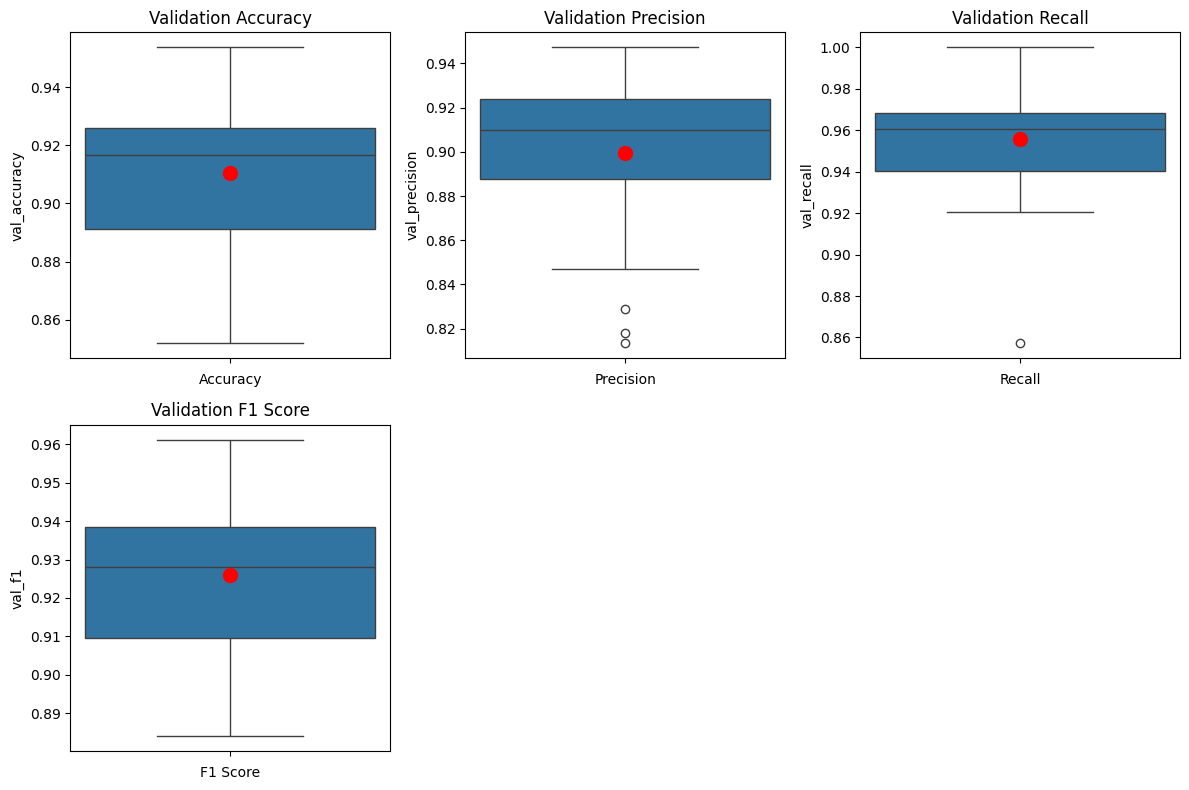

In [14]:
# Convert the metrics to a DataFrame for easier plotting
metrics_df = pd.DataFrame(all_metrics, columns=['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1'])

# Plot the box plots for each metric
plt.figure(figsize=(12, 8))

# Box plot for validation accuracy
plt.subplot(2, 3, 1)
sns.boxplot(y=metrics_df['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('Accuracy')
mean_val = metrics_df['val_accuracy'].mean()
plt.scatter(0, mean_val, color='red', s=100, zorder=10)

# Box plot for validation precision
plt.subplot(2, 3, 2)
sns.boxplot(y=metrics_df['val_precision'])
plt.title('Validation Precision')
plt.xlabel('Precision')
mean_val = metrics_df['val_precision'].mean()
plt.scatter(0, mean_val, color='red', s=100, zorder=10)

# Box plot for validation recall
plt.subplot(2, 3, 3)
sns.boxplot(y=metrics_df['val_recall'])
plt.title('Validation Recall')
plt.xlabel('Recall')
mean_val = metrics_df['val_recall'].mean()
plt.scatter(0, mean_val, color='red', s=100, zorder=10)

# Box plot for validation F1 score
plt.subplot(2, 3, 4)
sns.boxplot(y=metrics_df['val_f1'])
plt.title('Validation F1 Score')
plt.xlabel('F1 Score')
mean_val = metrics_df['val_f1'].mean()
plt.scatter(0, mean_val, color='red', s=100, zorder=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [15]:
# Save the metrics for later comparison
metrics_df.to_csv("fedMetrics/TCN_metrics.csv", index=False)

print("Finished Cross-Validation")

Finished Cross-Validation
